In [130]:
!pip install rasterio

In [131]:
# Import libraries
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point
from shapely import wkt
import numpy as np
import shapely
from shapely.geometry import shape
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mount on the Google Drive

In [132]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Hands-on Data Science/Hands-on Data Science_Project/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['data',
 'Carbon_emission_of_buildings_in_NYC_scale comparison.ipynb',
 'Carbon emission of buildings in NYC.ipynb',
 'figures',
 'results',
 'report',
 'src',
 'Perturbation Feature Importances (RandomForestRegressor).png',
 'Perturbation Feature Importances (XGBRegressor).png',
 'Perturbation Feature Importances (KNeighborsRegressor).png']

In [133]:

file_1_path = 'data/NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2022-Present__20241011.csv'

# Reading the CSV files
df_energy_all = pd.read_csv(file_1_path, low_memory=False)


In [134]:
print('NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present')
print(df_energy_all.head())
print('NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present Data shape')
print(df_energy_all.shape)

NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present
   Calendar Year  Property ID              Property Name  \
0           2022      6414946         58-01 Grand Avenue   
1           2022      9793770  1870 Pelham Parkway South   
2           2022     10177418           Central Building   
3           2022     13511507       215 East 99th Street   
4           2022     14009907            23-25 31 Street   

                    Parent Property ID                 Parent Property Name  \
0  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
1  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
2  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
3  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
4  Not Applicable: Standalone Property  Not Applicable: Standalone Property   

  Year Ending NYC Borough, Block and Lot (BBL)  \
0  12/31/2022                       40

In [135]:
print("Print all column names:\n",df_energy_all.columns)

Print all column names:
 Index(['Calendar Year', 'Property ID', 'Property Name', 'Parent Property ID',
       'Parent Property Name', 'Year Ending',
       'NYC Borough, Block and Lot (BBL)',
       'NYC Building Identification Number (BIN)', 'Address 1', 'City',
       ...
       'Aggregate Meter(s)-District Steam – Number of Individual Meters Included',
       'Report Generation Date', 'Report Submission Date', 'Borough',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract (2020)', 'Neighborhood Tabulation Area (NTA) (2020)'],
      dtype='object', length=265)


In [136]:
# selecting specific columns
columns_to_select = ['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude', 'Longitude', 'ENERGY STAR Score','Total (Location-Based) GHG Emissions (Metric Tons CO2e)','Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built','Borough','Neighborhood Tabulation Area (NTA) (2020)']
# Creating a new DataFrame with only the selected columns
df_energy = df_energy_all[columns_to_select]

print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  
0                                    QN0501  
1                                    BX1003  
2                                    QN1401  
3                                    MN1101  
4                                    QN0101

In [137]:
print('Filtered Data shape')
print(df_energy.shape)

Filtered Data shape
(64169, 11)


In [138]:
# Read in shapefile of NYC with NTA boundaries
db = gpd.read_file('data/NYC.shp')
# Set local crs in m
#db = db.to_crs(32618)

## Feature engineering - get a 'sum floor area' column

In [139]:
df_gross_floor_area = df_energy_all.filter(like='Gross Floor Area (ft²)')
# Display the first few rows to verify
df_gross_floor_area = df_gross_floor_area.drop(['Largest Property Use Type - Gross Floor Area (ft²)',
                                          '2nd Largest Property Use Type - Gross Floor Area (ft²)',
                                          '3rd Largest Property Use Type - Gross Floor Area (ft²)'], axis=1)


In [140]:
#calculating the sum floor area and store it in a column
df_gross_floor_area.replace('Not Available', 0, inplace=True)

df_gross_floor_area = df_gross_floor_area.apply(pd.to_numeric, errors='coerce')

df_gross_floor_area.fillna(0, inplace=True)

df_gross_floor_area_withsum = df_gross_floor_area.copy()

df_gross_floor_area_withsum['sum floor area'] = df_gross_floor_area_withsum.sum(axis=1)

print('Calculated sum floor area')
df_gross_floor_area_withsum.head()





<ipython-input-140-65f2f5eb4ff4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gross_floor_area.replace('Not Available', 0, inplace=True)


Calculated sum floor area


Data Center - Gross Floor Area (ft²)  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   Adult Education - Gross Floor Area (ft²)  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Ambulatory Surgical Center - Gross Floor Area (ft²)  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Vehicle Dealership - Gross Floor Area (ft²)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Bank Branch - Gross Floor Area (ft²)  Barracks- Gross Floor Area (ft²)  \
0                                   0.0                                 0   
1                                   0.0                                 0   
2                                   0.0                                 0   
3                                   0.0                                 0   
4                                   0.0                                 0   

   College/University - Gross Floor Area (ft²)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Convention Center - Gross Floor Area (ft²)  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   Courthouse - Gross Floor Area (ft²)  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   Distribution Center - Gross Floor Area (ft²)  ...  \
0                                           0.0  ...   
1                                           0.0  ...   
2                                           0.0  ...   
3                                           0.0  ...   
4                                           0.0  ...   

   Retail Store - Gross Floor Area (ft²)  \
0                                    0.0   
1                                    0.0   
2                                17598.0   
3                                    0.0   
4                                    0.0   

   Self-Storage Facility - Gross Floor Area (ft²)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Senior Living Community - Gross Floor Area (ft²)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Social/Meeting Hall - Gross Floor Area (ft²)  \
0                                             0   
1                                             0   
2                                             0   
3                                          

In [141]:
#add it to the df_energy
df_energy['sum floor area']=df_gross_floor_area_withsum['sum floor area']

<ipython-input-141-16d0ba587f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['sum floor area']=df_gross_floor_area_withsum['sum floor area']


In [142]:
print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  sum floor area  
0                                    QN0501         51749.0  
1                                    BX1003         52941.0  
2                                    QN1401         35196.0  
3                                    MN1101        107234.0  
4                                    QN0101         75191.0

In [143]:
# Simplify column names: Keep the part before ' - '
df_gross_floor_area.columns = [col.split('- ')[0] for col in df_gross_floor_area.columns]

# Apply one-hot encoding: Find the index of the maximum value and set that to the corresponding column name
df_gross_floor_area['major use type'] = df_gross_floor_area.apply(lambda row: row.idxmax(), axis=1)

# Display the first few rows to verify the result
print('First few rows with major use type:')
df_gross_floor_area[['major use type']].head()

First few rows with major use type:


major use type
0  Non-Refrigerated Warehouse 
1         Multifamily Housing 
2                      Office 
3         Multifamily Housing 
4              Medical Office

In [144]:
#add it to the df_energy
df_energy['major use type']=df_gross_floor_area['major use type']

<ipython-input-144-fcdb9ca9c1f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['major use type']=df_gross_floor_area['major use type']


In [145]:
print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  sum floor area  \
0                                    QN0501         51749.0   
1                                    BX1003         52941.0   
2                                    QN1401         35196.0   
3                                    MN1101        107234.0   
4                                    QN0101         75191.0   

                major use type  
0  Non-Refrigerated Warehouse   
1         Multifamily Housing   
2                      Office   
3         Multifamily Housing   
4              Medical Office

At this stage I already decide to do feature engineering to get sum floor area and major use type, which are 2 potential relevant variables to total GHG emissions.

#EDA
The goal of EDA is to gain an initial understanding of the dataset, identify patterns, detect missing data, and explore relationships between features.

##Summary Statistics:
###Continuous data:
'Latitude', 'Longitude',  'Total (Location-Based) GHG Emissions (Metric Tons CO2e)', 'Net Emissions (Metric Tons CO2e)', 'sum floor area' 'Year Built',
  
###Ordinal data:
'ENERGY STAR Score'  
  
###Categorical data:
'NYC Building Identification Number (BIN)', 'Property Name', 'Borough', 'Neighborhood Tabulation Area (NTA) (2020)', 'Calendar Year','major use type'

In [146]:
print(df_energy.dtypes)

NYC Building Identification Number (BIN)                    object
Property Name                                               object
Latitude                                                   float64
Longitude                                                  float64
ENERGY STAR Score                                           object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)     object
Net Emissions (Metric Tons CO2e)                            object
Calendar Year                                                int64
Year Built                                                   int64
Borough                                                     object
Neighborhood Tabulation Area (NTA) (2020)                   object
sum floor area                                             float64
major use type                                              object
dtype: object


In [147]:
# Converting the columns to float
df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')
df_energy['Net Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Net Emissions (Metric Tons CO2e)'], errors='coerce')

# Verifying the data types after conversion
print(df_energy.dtypes)
print(df_energy[['Total (Location-Based) GHG Emissions (Metric Tons CO2e)', 'Net Emissions (Metric Tons CO2e)']].dtypes)

NYC Building Identification Number (BIN)                    object
Property Name                                               object
Latitude                                                   float64
Longitude                                                  float64
ENERGY STAR Score                                           object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    float64
Net Emissions (Metric Tons CO2e)                           float64
Calendar Year                                                int64
Year Built                                                   int64
Borough                                                     object
Neighborhood Tabulation Area (NTA) (2020)                   object
sum floor area                                             float64
major use type                                              object
dtype: object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    float64
Net Emissions (Metric Tons CO2e)                

<ipython-input-147-f87d8c325fe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')
<ipython-input-147-f87d8c325fe3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['Net Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Net Emissions (Metric Tons CO2e)'], errors='coerce')


In [148]:
columns_continuous = ['Latitude', 'Longitude', 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
                      'Net Emissions (Metric Tons CO2e)','sum floor area','Year Built',]
df_energy[columns_continuous].describe()

Latitude     Longitude  \
count  61790.000000  61790.000000   
mean      40.747879    -73.936054   
std        0.078342      0.064506   
min       40.509037    -74.244118   
25%       40.697285    -73.978987   
50%       40.750050    -73.946978   
75%       40.810227    -73.900956   
max       40.912869    -73.700935   

       Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
count                                       6.271200e+04         
mean                                        9.141075e+02         
std                                         2.057174e+04         
min                                        -4.390000e+01         
25%                                         1.602000e+02         
50%                                         2.922000e+02         
75%                                         5.585000e+02         
max                                         3.139712e+06         

       Net Emissions (Metric Tons CO2e)  sum floor area    Year Built  
count                      6.322200e+04    6.416900e+04  64169.000000  
mean                       8.105927e+02    1.277157e+05   1951.318814  
std                        9.198873e+03    3.219850e+05     35.262775  
min                       -8.385100e+03    0.000000e+00   1051.000000  
25%                        1.819000e+02    3.600000e+04   1925.000000  
50%                        3.165000e+02    6.088300e+04   1941.000000  
75%                        6.089750e+02    1.168970e+05   1974.000000  
max                        2.206863e+06    2.204270e+07   2088.000000

In [149]:
# Frequency counts for ordinal data
df_energy['ENERGY STAR Score'].value_counts()


ENERGY STAR Score
Not Available    15130
100               3804
1                 1078
99                 823
86                 760
                 ...  
8                  237
9                  236
13                 233
7                  225
16                 225
Name: count, Length: 101, dtype: int64

In [150]:
# Summary statistics for ordinal data
df_energy['ENERGY STAR Score'].describe()


count             64169
unique              101
top       Not Available
freq              15130
Name: ENERGY STAR Score, dtype: object

In [151]:

columns_categorical = ['NYC Building Identification Number (BIN)', 'Property Name', 'Borough',
'Neighborhood Tabulation Area (NTA) (2020)', 'Calendar Year', 'major use type']
for column in columns_categorical:
    print(f"\nFrequency counts for {column}:")
    print(df_energy[column].value_counts())



Frequency counts for NYC Building Identification Number (BIN):
NYC Building Identification Number (BIN)
Not Available              627
2123911                    190
2999999                     93
4999999                     50
0                           49
                          ... 
3326541                      1
3326506                      1
3326556                      1
1078514;1078516;1078512      1
2085311                      1
Name: count, Length: 31136, dtype: int64

Frequency counts for Property Name:
Property Name
University Center                              6
Main Building                                  6
Cross Bronx Pres LLC - Baychester (2166bay)    6
Alumni Hall                                    6
29-07 31st Ave                                 6
                                              ..
247 Dumont Avenue                              1
190 Riverdale Avenue                           1
338 Bristol Street                             1
392 Bristol Street   

In [152]:
import pandas as pd
import os

# Define the folder to save the CSV files
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# Frequency count data as provided
frequency_counts = {
    "NYC_Building_Identification_Number_BIN": {
        "data": {
            "2123911": 190,
            "2999999": 93,
            "4999999": 50,
            "0": 49,
            "2109476": 32,
        },
        "total": 31135,
    },
    "Property_Name": {
        "data": {
            "University Center": 6,
            "Main Building": 6,
            "Cross Bronx Pres LLC - Baychester (2166bay)": 6,
            "Alumni Hall": 6,
            "29-07 31st Ave": 6,
        },
        "total": 36634,
    },
    "Borough": {
        "data": {
            "MANHATTAN": 22493,
            "BROOKLYN": 15362,
            "BRONX": 11998,
            "QUEENS": 10619,
            "STATEN IS": 1321,
        },
        "total": None,
    },
    "Neighborhood_Tabulation_Area_NTA_2020": {
        "data": {
            "MN0502": 1844,
            "MN0802": 1422,
            "MN0501": 1341,
            "MN0702": 1287,
            "MN0401": 1158,
        },
        "total": 230,
    },
    "Calendar_Year": {
        "data": {"2023": 33684, "2022": 30485},
        "total": None,
    },
    "major_use_type": {
        "data": {
            "Multifamily Housing": 42030,
            "Office": 5118,
            "K-12 School": 3780,
            "Data Center": 2903,
            "Hotel": 1299,
        },
        "total": None,
    },
}

# Create DataFrame and save each frequency count as a CSV
for column, freq_data in frequency_counts.items():
    df = pd.DataFrame(freq_data["data"].items(), columns=[column, "Frequency"])
    output_file = os.path.join(output_folder, f"{column}_frequency_counts.csv")
    df.to_csv(output_file, index=False)

print(f"Frequency counts saved as CSV files in the '{output_folder}' folder.")


Frequency counts saved as CSV files in the 'data' folder.


##Missing Data:
###Check for missing values using isnull().sum() and evaluate which columns have missing data.

  
###Plot missing data distribution using heatmaps (sns.heatmap()) to identify patterns  

In [153]:
df_energy.replace('Not Available', np.nan, inplace=True)
df_energy.isnull().sum()

<ipython-input-153-b51e0c231f9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy.replace('Not Available', np.nan, inplace=True)


NYC Building Identification Number (BIN)                     627
Property Name                                                  0
Latitude                                                    2379
Longitude                                                   2379
ENERGY STAR Score                                          15130
Total (Location-Based) GHG Emissions (Metric Tons CO2e)     1457
Net Emissions (Metric Tons CO2e)                             947
Calendar Year                                                  0
Year Built                                                     0
Borough                                                     2376
Neighborhood Tabulation Area (NTA) (2020)                   2378
sum floor area                                                 0
major use type                                                 0
dtype: int64

In [154]:
df_energy.to_csv('data/df_energy.csv', index=False)

In [155]:
# Calculate the fraction of null values in each column
null_fractions = df_energy.isnull().sum() / len(df_energy)

# Display the fraction of nulls
print("Fraction of null values in each column:")
print(null_fractions)

Fraction of null values in each column:
NYC Building Identification Number (BIN)                   0.009771
Property Name                                              0.000000
Latitude                                                   0.037074
Longitude                                                  0.037074
ENERGY STAR Score                                          0.235784
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    0.022706
Net Emissions (Metric Tons CO2e)                           0.014758
Calendar Year                                              0.000000
Year Built                                                 0.000000
Borough                                                    0.037027
Neighborhood Tabulation Area (NTA) (2020)                  0.037058
sum floor area                                             0.000000
major use type                                             0.000000
dtype: float64


In [156]:
null_values_data = {
    "Column": [
        "NYC Building Identification Number (BIN)",
        "Property Name",
        "Latitude",
        "Longitude",
        "ENERGY STAR Score",
        "Total (Location-Based) GHG Emissions (Metric Tons CO2e)",
        "Net Emissions (Metric Tons CO2e)",
        "Calendar Year",
        "Year Built",
        "Borough",
        "Neighborhood Tabulation Area (NTA) (2020)",
        "sum floor area",
        "major use type"
    ],
    "Fraction of Null Values": [
        0.009771, 0.000000, 0.037074, 0.037074, 0.235784,
        0.022706, 0.014758, 0.000000, 0.000000, 0.037027,
        0.037058, 0.000000, 0.000000
    ]
}

# Define output folder
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# Create a DataFrame and save as CSV
df_null_values = pd.DataFrame(null_values_data)
output_file = os.path.join(output_folder, "fraction_of_null_values.csv")
df_null_values.to_csv(output_file, index=False)

print(f"Fraction of null values saved as a CSV file: {output_file}")

Fraction of null values saved as a CSV file: data/fraction_of_null_values.csv


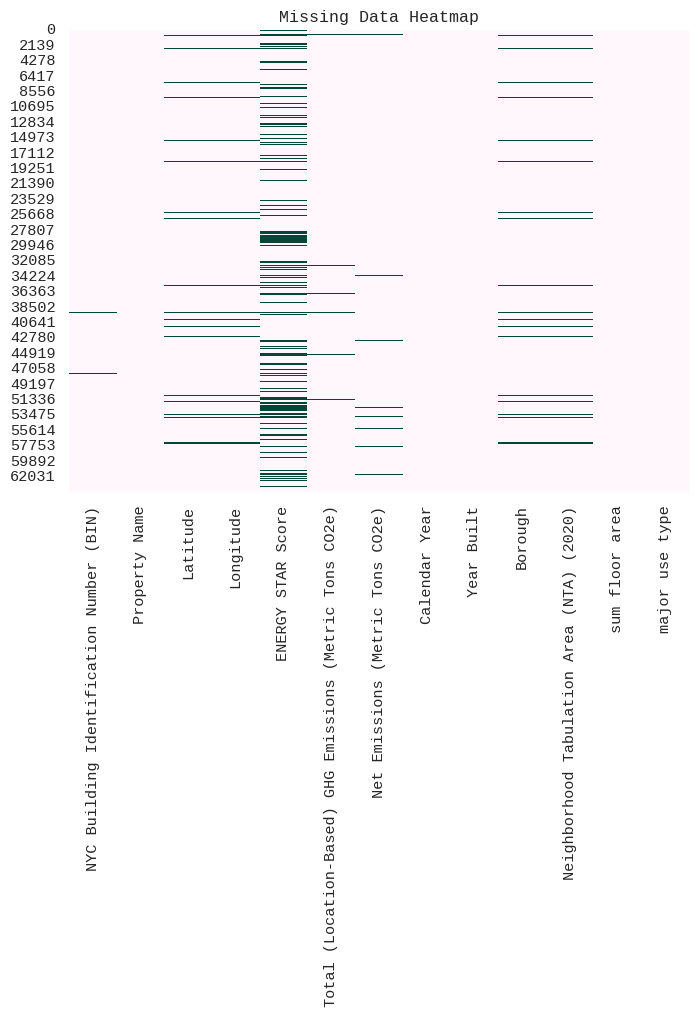

In [157]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the directory exists
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Increase the figure size for better readability
plt.figure(figsize=(8, 6))

# Heatmap with a different colormap for better contrast
sns.heatmap(df_energy.isnull(), cmap='PuBuGn', cbar=False)

plt.title('Missing Data Heatmap')
output_path = os.path.join(output_dir, 'Missing Data Heatmap.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


We can see that, for columns other than ENERBY STAR Score, only a small percentage of rows have missing data, so dropping them won't significantly reduce the size of your dataset.

Data imputation is not feasible especially for the data missing Latitude and Longtitude. For those which have Latitude and Longtituede but missing the important CO2 emission values, inferring them would be difficult without building model based on the some relevant factors.

When we need the building energy information as much as we can to calculate the effect of it on regional carbon emission, data imputation may be reasonable. However, the data imputation with mean or median may be very inaccurate based on that the CO2 emission varies greatly depending on size of the building, use types, etc. The reasonable data imputation needs a model. To build this model, dropping all the rows with missing values is the most efficient way of dealing with missing values before the model is built.

So I ignore 'ENERBY STAR Score' column first and drop all the rows have NA in other columns. This data do not lose completeness. Leaving some NA in 'ENERBY STAR Score' is better than unreasonable data imputation because the NAs in this columns is almost one fifth of the total data number.

In [158]:
df_clean = df_energy.dropna(subset=[col for col in df_energy.columns if col != 'ENERGY STAR Score'])

print('The shape of dataframe after dropping NAs (except ENERGY STAR Score) is:', df_clean.shape)

The shape of dataframe after dropping NAs (except ENERGY STAR Score) is: (59420, 13)


In [159]:


# Check to ensure there are no NaN values left in the 'ENERGY STAR Score' column
print(df_clean['ENERGY STAR Score'].isnull().sum(), "missing values left in 'ENERGY STAR Score'")


11945 missing values left in 'ENERGY STAR Score'


In [160]:
df_clean.to_csv('data/df_clean.csv', index=False)

## Data Engineering-adding the temperature

In [161]:
import rasterio
from rasterio.warp import transform
# Load the reprojected raster
raster_path = 'data/f_deviation_smooth_32618.tif'
raster = rasterio.open(raster_path)

# Convert the Lat/Lon columns in df_clean to geometry points (WGS84)
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert the GeoDataFrame to a consistent CRS (WGS84 EPSG:4326)
gdf_clean = gpd.GeoDataFrame(df_clean, geometry='geometry', crs='EPSG:4326')

# Reproject the points to the raster's CRS (EPSG:32618)
gdf_clean = gdf_clean.to_crs(32618)

# Function to extract the temperature at each point from the raster
def extract_temperature(point, raster):
    try:
        # Extract the pixel value at the point location
        coords = [(point.x, point.y)]
        for val in raster.sample(coords):
            if val[0] != raster.nodata:
                return val[0]
            else:
                return np.nan
    except Exception as e:
        print(f"Error extracting temperature for point {point}: {e}")
        return np.nan

# Apply the temperature extraction function to each row in the GeoDataFrame
gdf_clean['temperature'] = gdf_clean['geometry'].apply(lambda point: extract_temperature(point, raster))

# Convert back to the original DataFrame (dropping the 'geometry' column)
df_clean['temperature'] = gdf_clean['temperature']

# Display the first few rows to verify
print('Display the first few rows to verify the temperature is added to the building energy dataframe')
print(df_clean.head())




<ipython-input-161-c79b47a94d05>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['geometry'] = df_clean.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)


Display the first few rows to verify the temperature is added to the building energy dataframe
  NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009               NaN   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

   Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9         
1                                              216.1         
2        

<ipython-input-161-c79b47a94d05>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['temperature'] = gdf_clean['temperature']


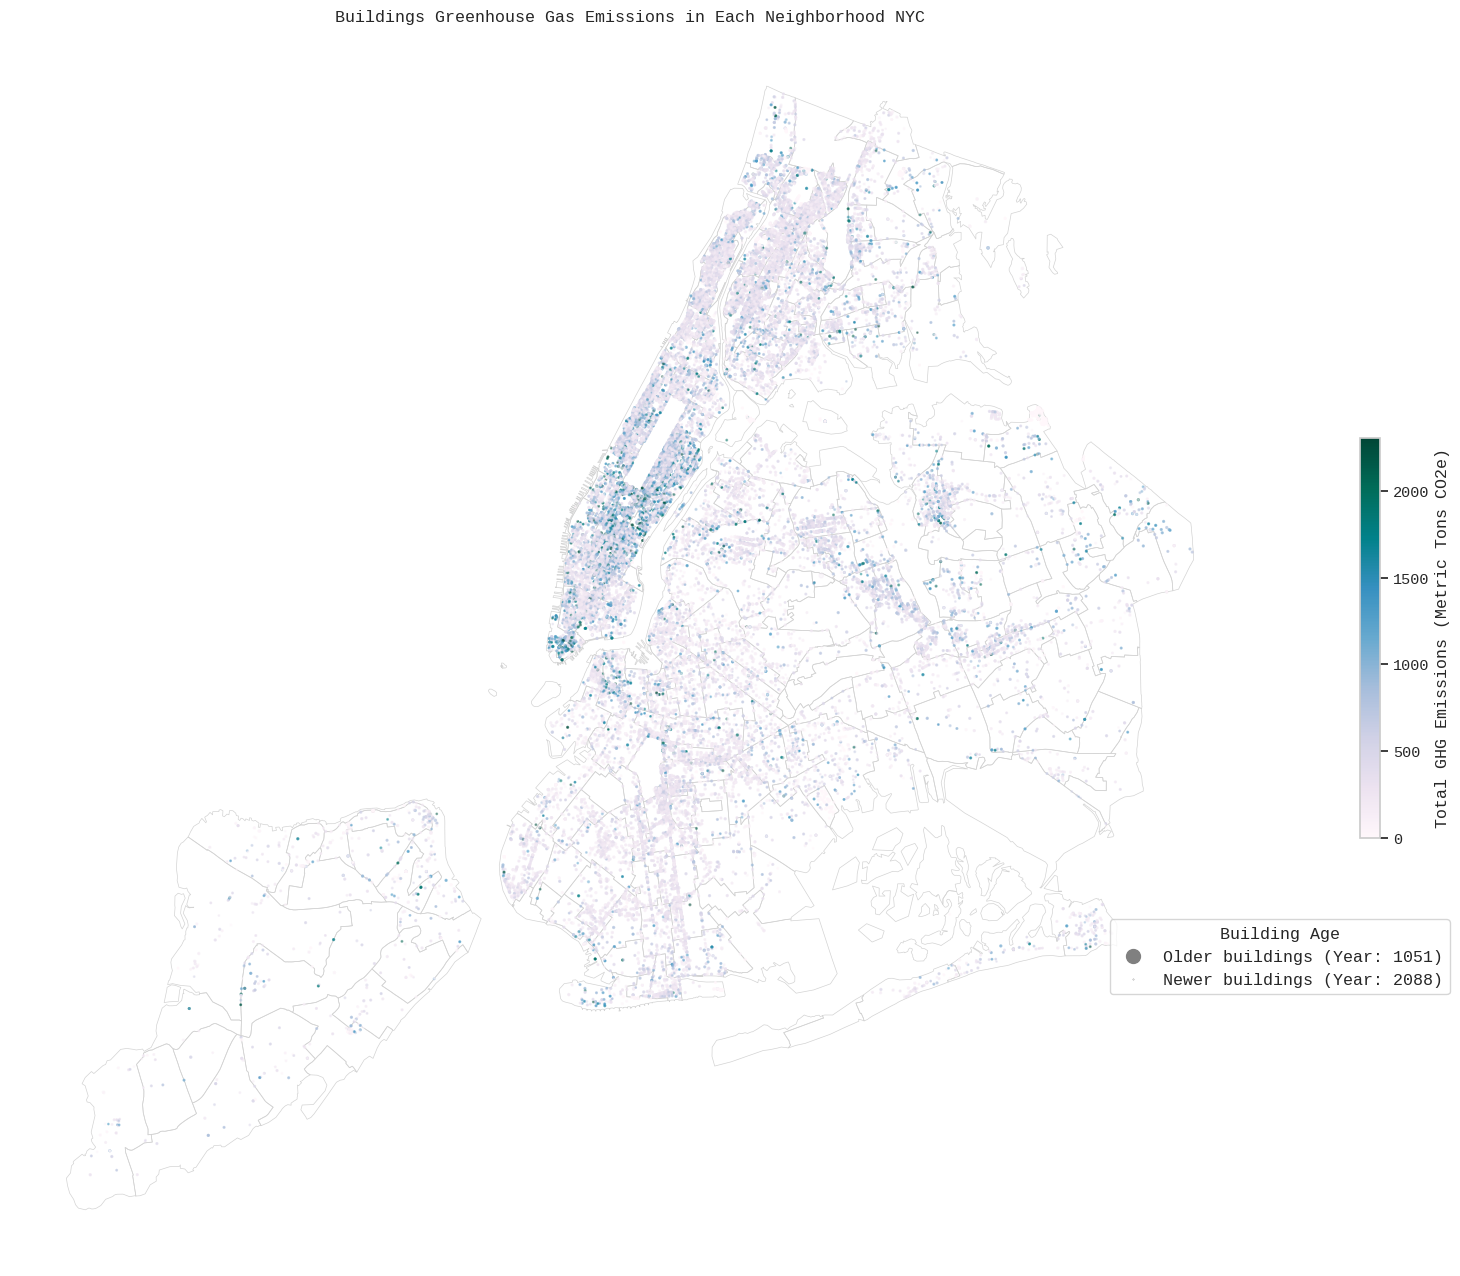

In [162]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.lines as mlines


plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18

# Define thresholds for GHG emissions and floor area
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)
sum_threshold = df_clean['sum floor area'].quantile(0.95)

# Filter the DataFrame
df_clean_filtered1 = df_clean[
    (df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold) &
    (df_clean['sum floor area'] <= sum_threshold)
]

# Ensure that the DataFrame has a valid geometry column
df_clean_filtered1.loc[:, 'geometry'] = df_clean_filtered1.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert df_clean to a GeoDataFrame
gdf_clean = gpd.GeoDataFrame(df_clean_filtered1, geometry='geometry')


gdf_clean.set_crs(epsg=4326, inplace=True)
db.set_crs(epsg=4326, inplace=True)

# Reverse scale 'Year Built' to range 0.25 to 3, where older buildings have larger markers
scaler = MinMaxScaler(feature_range=(-10, -0.25))  # Larger values for older years
gdf_clean['markersize'] = scaler.fit_transform(gdf_clean[['Year Built']])
gdf_clean['markersize'] = -gdf_clean['markersize']

# Plot the buildings with color based on GHG Emissions
fig, ax = plt.subplots(figsize=(20, 20))

db.plot(ax=ax, edgecolor="lightgrey", facecolor="none", linewidth=0.5)

# Plot buildings colored by 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
gdf_clean.plot(column='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               cmap='PuBuGn',  # Colormap for GHG Emissions
               legend=True,
               legend_kwds={'label': "Total GHG Emissions (Metric Tons CO2e)",
                            'orientation': "vertical", 'shrink': 0.3},
               ax=ax,
               markersize=gdf_clean['markersize'], alpha=0.4)

# Adjust the color bar position
cbar = ax.get_figure().get_axes()[1]
cbar.set_position([0.8, 0.4, 0.01, 0.2])  # Position: [left, bottom, width, height]

# Remove the main plot frame
ax.set_axis_off()

# Set plot title and axis labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Custom size legend based on marker size and year
min_year = int(gdf_clean['Year Built'].min())
max_year = int(gdf_clean['Year Built'].max())
min_marker = gdf_clean['markersize'].max()  # Larger marker for older buildings
max_marker = gdf_clean['markersize'].min()  # Smaller marker for newer buildings

# Create custom legend elements
legend_elements = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=min_marker,
                  label=f"Older buildings (Year: {min_year})"),
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=max_marker,
                  label=f"Newer buildings (Year: {max_year})")
]

# Add custom legend to the plot
ax.legend(handles=legend_elements, title="Building Age", fontsize=12, title_fontsize=12,
          loc='center left', bbox_to_anchor=(0.88, 0.25))

# Save the figure with transparent background
plt.title('Buildings Greenhouse Gas Emissions in Each Neighborhood NYC')
plt.savefig("figures/buildings_ghg_emissions_map.png", transparent=True, bbox_inches='tight', dpi=300)

plt.show()

The map shows that the buildings with the highest GHG emissions are concentrated in Manhattan, as indicated by the darker turquoise colors. This observation could be attributed to the concentration of larger buildings, commercial spaces, and office buildings in Manhattan, which tend to have higher energy demands and, consequently, higher emissions.

##Visualize Key Variables:


In [163]:
import matplotlib.cm as cm

In [164]:
print(df_clean.columns)


Index(['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude',
       'Longitude', 'ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built',
       'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
       'sum floor area', 'major use type', 'geometry', 'temperature'],
      dtype='object')


In [165]:
df_clean.columns = df_clean.columns.str.strip()


In [166]:
df_clean['ENERGY STAR Score'] = pd.to_numeric(df_clean['ENERGY STAR Score'], errors='coerce')
df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')


<ipython-input-166-0fb95536d8e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ENERGY STAR Score'] = pd.to_numeric(df_clean['ENERGY STAR Score'], errors='coerce')
<ipython-input-166-0fb95536d8e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')


In [167]:
!apt-get install -y fonts-roboto


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-roboto is already the newest version (2:0~20170802-3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [168]:
import matplotlib.font_manager as fm
# Get available fonts
fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
available_fonts = sorted(set(fm.FontProperties(fname=font).get_name() for font in fonts))

# Print available fonts
print(available_fonts)


['Humor Sans', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Serif', 'Roboto', 'Roboto Condensed']


see what columns now we have
Index(['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude',
       'Longitude', 'ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built',
       'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
       'sum floor area', 'major use type', 'geometry', 'temperature'],
      dtype='object')


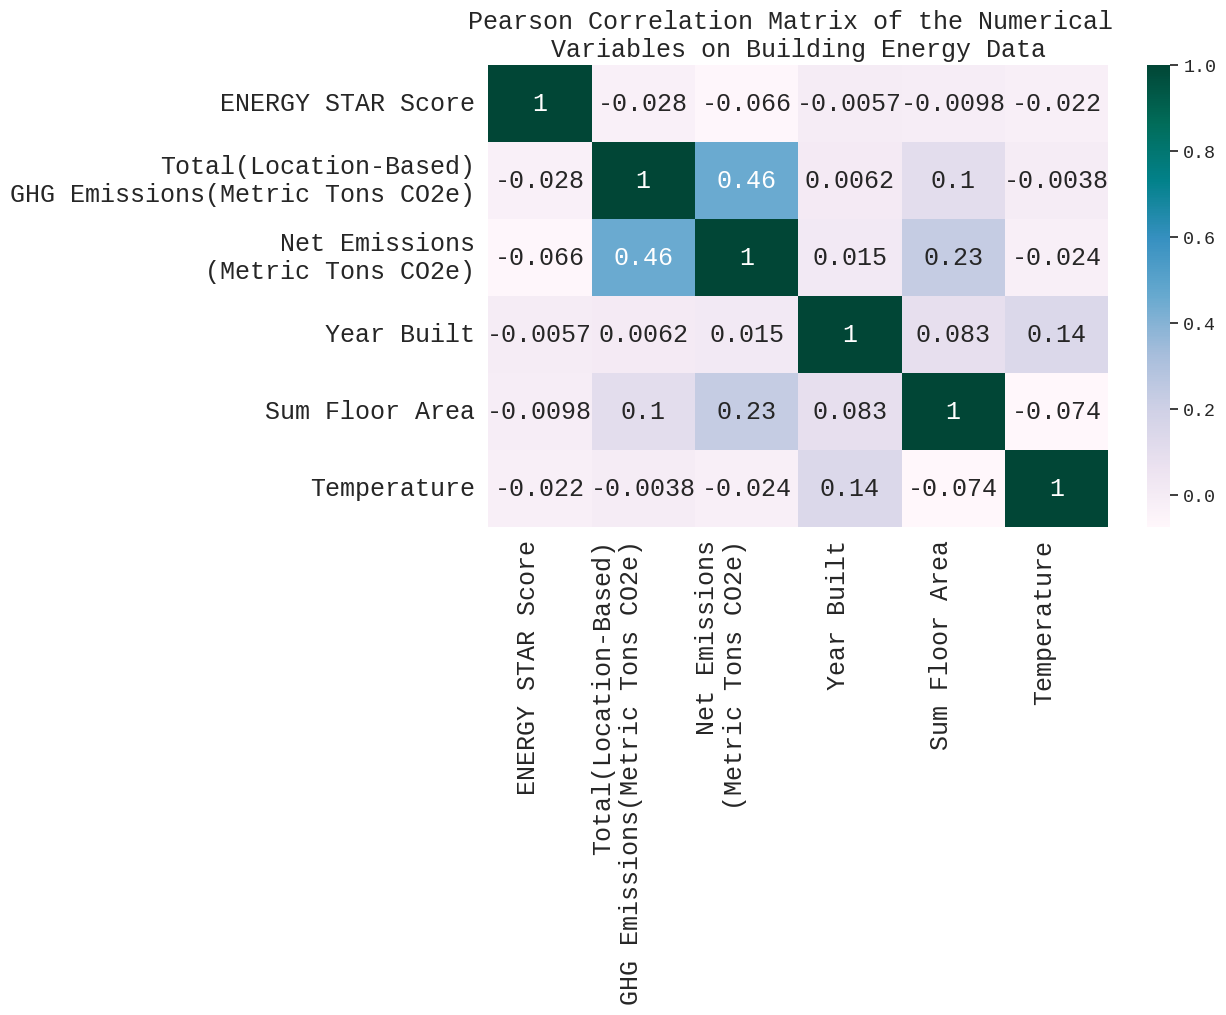

In [169]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(font_scale=1.2)  # Adjust the scale (1.2 is larger than default)
plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18


columns=df_clean.columns
print('see what columns now we have')
print(columns)

# Calculate the correlation matrix
pearson_corr_matrix = df_clean[['ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)',  'Year Built',
       'sum floor area', 'temperature']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
heatmap1=sns.heatmap(pearson_corr_matrix, annot=True, cmap='PuBuGn')
heatmap1.set_xticklabels([
    'ENERGY STAR Score',
    'Total(Location-Based)\nGHG Emissions(Metric Tons CO2e)',
    'Net Emissions\n(Metric Tons CO2e)',
    'Year Built',
    'Sum Floor Area',
    'Temperature'
], rotation=90, ha='right', fontsize=18)

heatmap1.set_yticklabels([
    'ENERGY STAR Score',
    'Total(Location-Based)\nGHG Emissions(Metric Tons CO2e)',
    'Net Emissions\n(Metric Tons CO2e)',
    'Year Built',
    'Sum Floor Area',
    'Temperature'
], rotation=0, ha='right', fontsize=18)
plt.title('Pearson Correlation Matrix of the Numerical \nVariables on Building Energy Data', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("figures/Pearson Correlation Matrix.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()

There are little linear relationship between each variables. except for Total GHG Emissions and Net Emissions. It might be better to explore non-linear relationship.

see what columns now we have
Index(['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude',
       'Longitude', 'ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built',
       'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
       'sum floor area', 'major use type', 'geometry', 'temperature'],
      dtype='object')


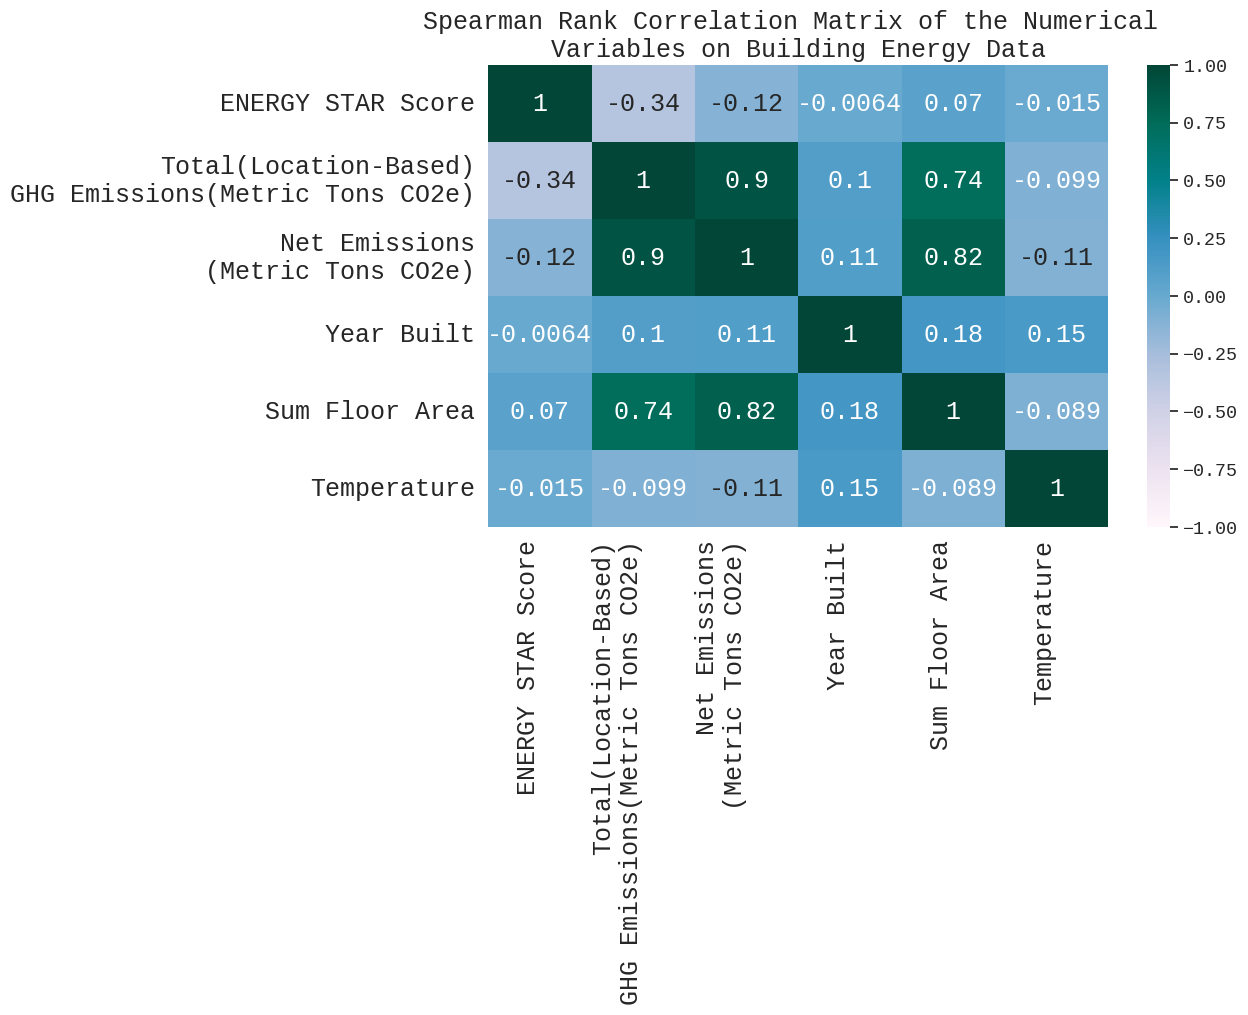

In [170]:


sns.set(font_scale=1.2)
plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18


columns=df_clean.columns
print('see what columns now we have')
print(columns)

# Calculate the Spearman correlation matrix
spearman_corr = df_clean[['ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)',  'Year Built',
       'sum floor area', 'temperature']].corr(method='spearman')


plt.figure(figsize=(10, 6))
heatmap2=sns.heatmap(spearman_corr, annot=True, cmap='PuBuGn', vmin=-1, vmax=1)
heatmap2.set_xticklabels([
    'ENERGY STAR Score',
    'Total(Location-Based)\nGHG Emissions(Metric Tons CO2e)',
    'Net Emissions\n(Metric Tons CO2e)',
    'Year Built',
    'Sum Floor Area',
    'Temperature'
], rotation=90, ha='right', fontsize=18)

heatmap2.set_yticklabels([
    'ENERGY STAR Score',
    'Total(Location-Based)\nGHG Emissions(Metric Tons CO2e)',
    'Net Emissions\n(Metric Tons CO2e)',
    'Year Built',
    'Sum Floor Area',
    'Temperature'
], rotation=0, ha='right', fontsize=18)


# Plot the heatmap


plt.title('Spearman Rank Correlation Matrix of the Numerical \nVariables on Building Energy Data', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("figures/Spearman Correlation Matrix.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()

From Spearman’s rank correlation matrix, we can see some non-linear relationships:

Total GHG Emissions and Net Emissions (0.9): This is a very high positive Spearman correlation, meaning that as one increases, the other tends to increase in a consistent manner. This relationship could be non-linear, but still monotonic.

Total GHG Emissions and Sum Floor Area (0.74): A strong positive monotonic relationship exists here. Larger floor areas tend to correspond to higher GHG emissions, even if the relationship isn't strictly linear.

Net Emissions and Sum Floor Area (0.82): Again, there's a strong positive monotonic relationship between the size of the building and its emissions, but this relationship might not be linear.

Total GHG Emissions and ENERGY STAR Score (-0.34): This negative correlation suggests that buildings with higher GHG emissions tend to have lower ENERGY STAR scores in a monotonic way. This could mean that increasing GHG emissions generally leads to lower scores, but not in a perfectly linear manner.

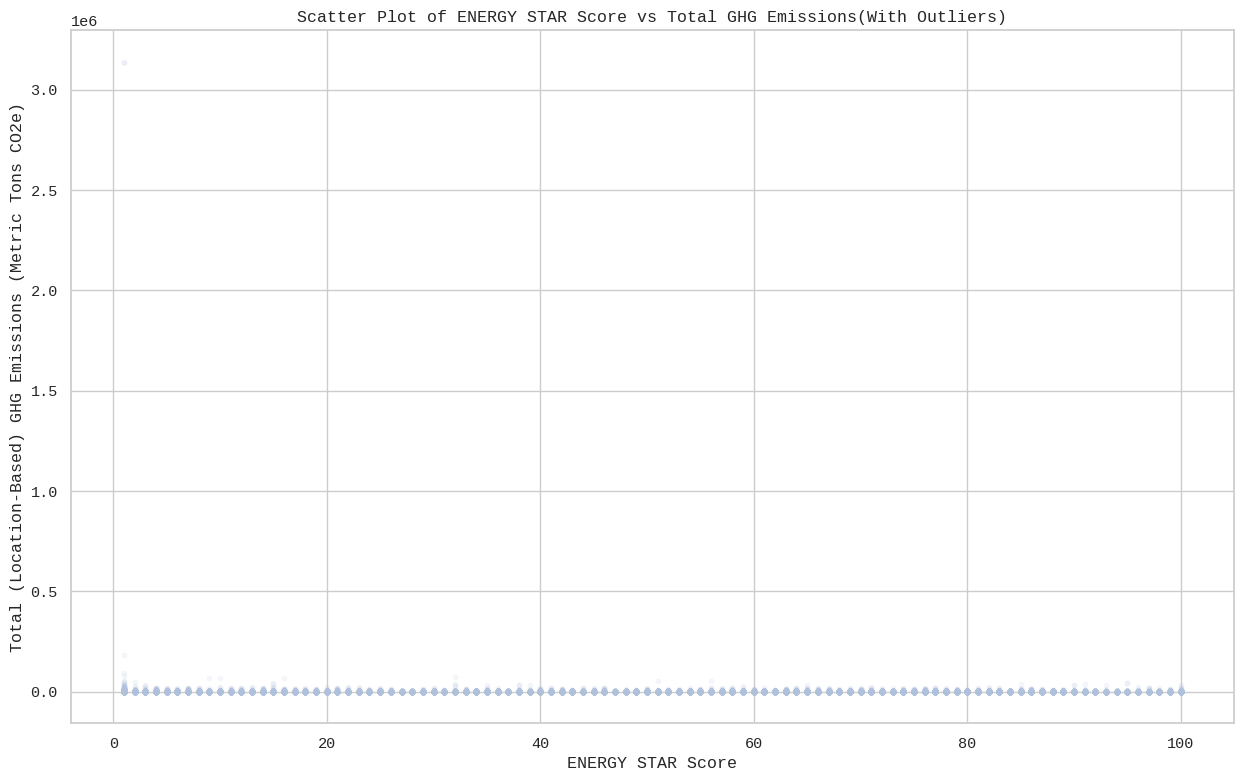

In [171]:
sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Liberation Mono'
df_clean.plot.scatter('ENERGY STAR Score','Total (Location-Based) GHG Emissions (Metric Tons CO2e)',figsize=(15,9),alpha=0.1,s=10,c='#afc1dd')
plt.xlabel('ENERGY STAR Score')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of ENERGY STAR Score vs Total GHG Emissions(With Outliers)')
plt.savefig('figures/Scatter Plot of ENERGY STAR Score vs Total GHG Emissions(With Outliers).png', dpi=300, bbox_inches='tight')
plt.show()


Seems like there is some outliers so the plot is not balanced.
So I remove the outlier and plot again.

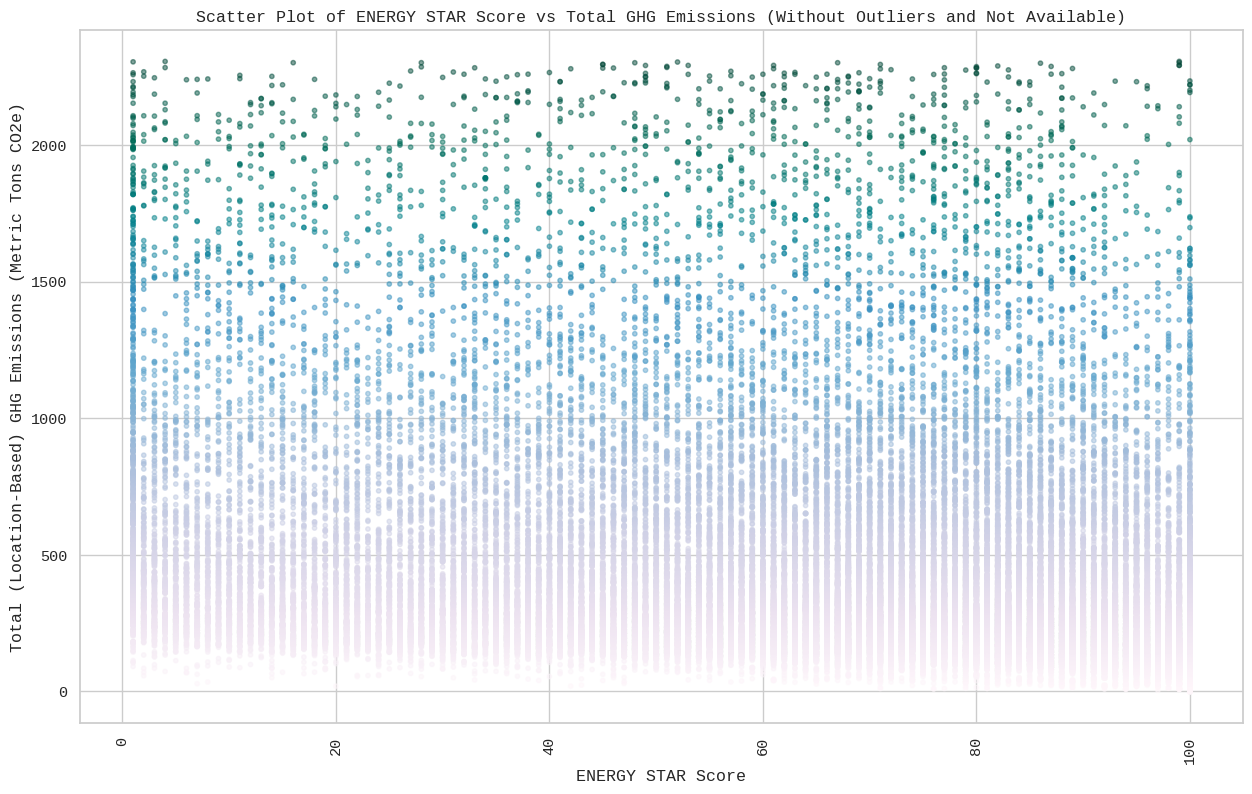

In [172]:

import matplotlib.colors as mcolors


sns.set(style='whitegrid')

# Define a threshold using the 95th percentile of the GHG Emissions column
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)

# Filter DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]
df_clean_filtered = df_clean_filtered[df_clean_filtered['ENERGY STAR Score'] != 'Not Available']

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = mcolors.Normalize(vmin=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                         vmax=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
cmap = plt.colormaps.get_cmap('PuBuGn')
colors = cmap(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))

# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.rcParams['font.family'] = 'Liberation Mono'
scatter = plt.scatter(df_clean_filtered['ENERGY STAR Score'],
                      df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
                      alpha=0.5, s=10, c=colors)
plt.xlabel('ENERGY STAR Score')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of ENERGY STAR Score vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)

# Add a colorbar with ScalarMappable
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
#plt.colorbar(sm, label='Total GHG Emissions (Metric Tons CO2e)')
plt.savefig("figures/Scatter Plot of ENERGY STAR Score vs Total GHG Emissions(Without Outliers and Not Available).png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()

No visible pattern can be seen between these 2 variables.

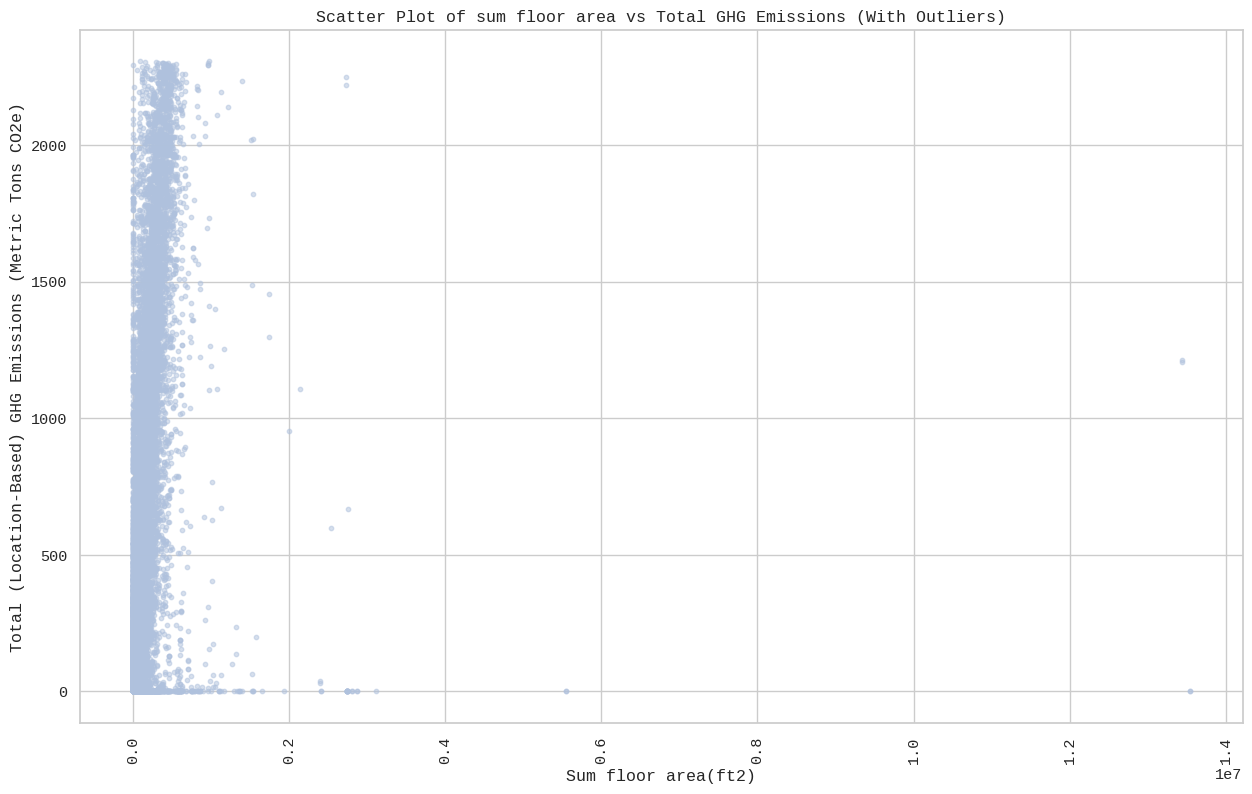

In [173]:
plt.rcParams['font.family'] = 'Liberation Mono'
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)


# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered2 = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]


# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered['sum floor area'],
            df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10,c='#afc1dd')
plt.xlabel('Sum floor area(ft2)')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of sum floor area vs Total GHG Emissions (With Outliers)')
plt.xticks(rotation=90)
plt.savefig('figures/Scatter Plot of sum floor area vs Total GHG Emissions (With Outliers).png', dpi=300, bbox_inches='tight')
plt.show()

We need to remove outliers in 'sum floor area' columns as well.

<ipython-input-174-8eed0e229683>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))


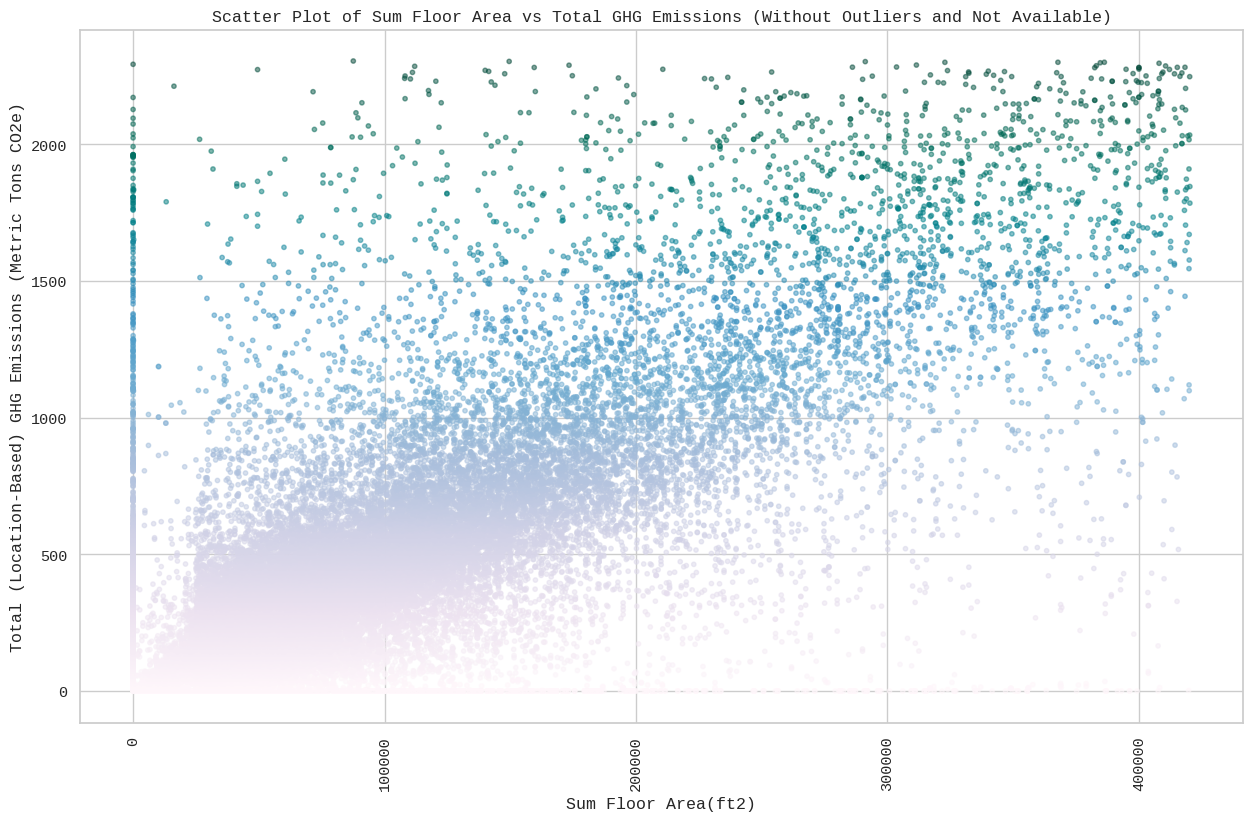

In [174]:


sns.set(style='whitegrid')

# Define thresholds
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)
sum_threshold = df_clean['sum floor area'].quantile(0.95)

# Filter the DataFrame based on both conditions
df_clean_filtered2 = df_clean[(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold) &
                              (df_clean['sum floor area'] <= sum_threshold)]

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                     vmax=df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))

# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.rcParams['font.family'] = 'Liberation Mono'
plt.scatter(df_clean_filtered2['sum floor area'], df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10, c=colors)

plt.xlabel('Sum Floor Area(ft2)')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of Sum Floor Area vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)

# Add a colorbar
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')
plt.savefig("figures/Scatter Plot of Sum Floor Area vs Total GHG Emissions(Without Outliers and Not Available).png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()

We can observe the general trend where the sum floor area increases alongside the GHG emissions, with some clustering around lower values.

<ipython-input-175-fbb61d3c9c1e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered2['Decade Built'] = (df_clean_filtered2['Year Built'] // 10) * 10
<ipython-input-175-fbb61d3c9c1e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Decade Built', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',


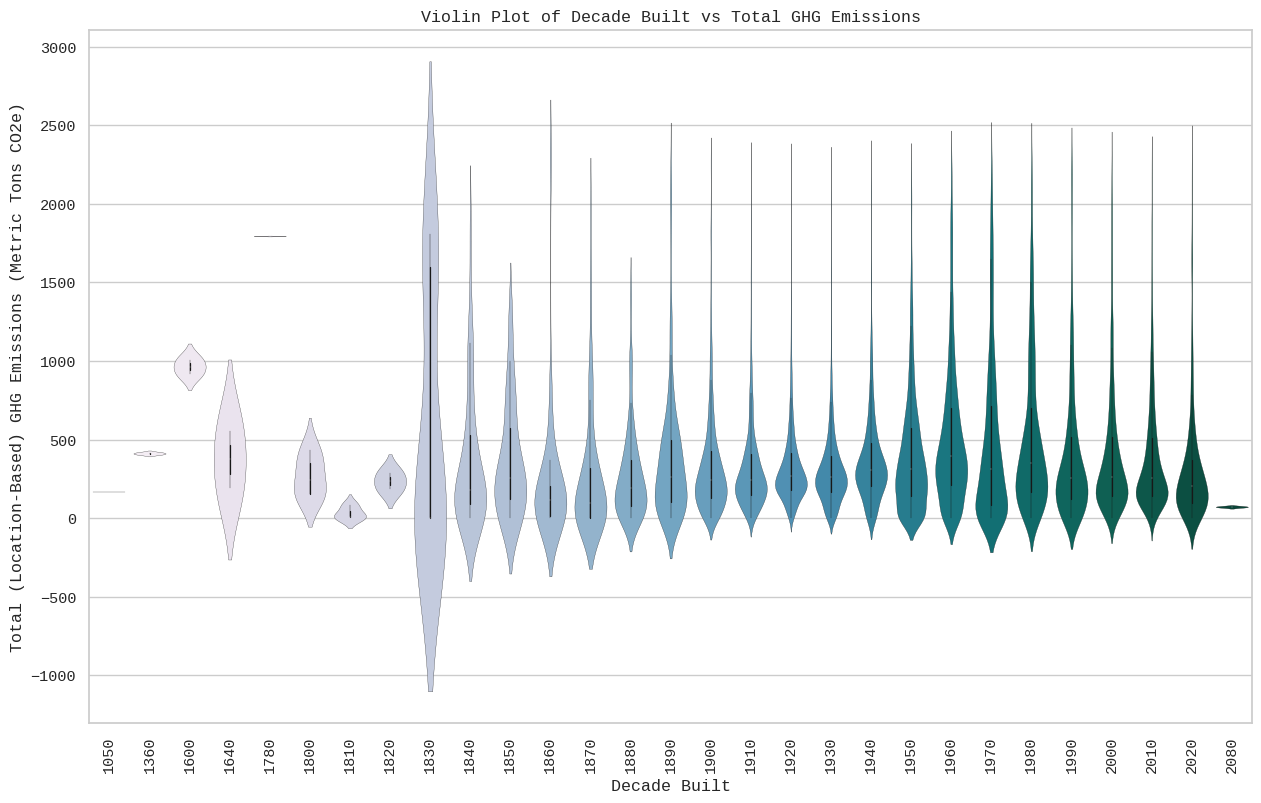

In [175]:
sns.set(style='whitegrid')

plt.rcParams['font.family'] = 'Liberation Mono'
# Create a new column for decade
df_clean_filtered2['Decade Built'] = (df_clean_filtered2['Year Built'] // 10) * 10

# Create the violin plot for Decade Built
plt.figure(figsize=(15, 9))
sns.violinplot(x='Decade Built', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               data=df_clean_filtered2, palette='PuBuGn',linewidth=0.2)

plt.xticks(rotation=90)
plt.xlabel('Decade Built')
#plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Violin Plot of Decade Built vs Total GHG Emissions')
plt.savefig("figures/Violin Plot of Decade Built vs Total GHG Emissions.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


The data suggests that buildings constructed in the 1830s show a spike in carbon emissions, possibly due to specific construction techniques or building materials used during that era. Another notable peak occurs around the 1970s, which might correspond to large building developments or inefficient energy usage practices during that period.

Additionally, the gradual decrease in carbon emissions for buildings constructed after the 1970s could reflect improvements in building regulations, energy efficiency standards, and construction practices aimed at reducing greenhouse gas emissions.

<ipython-input-176-1bc43570532a>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))


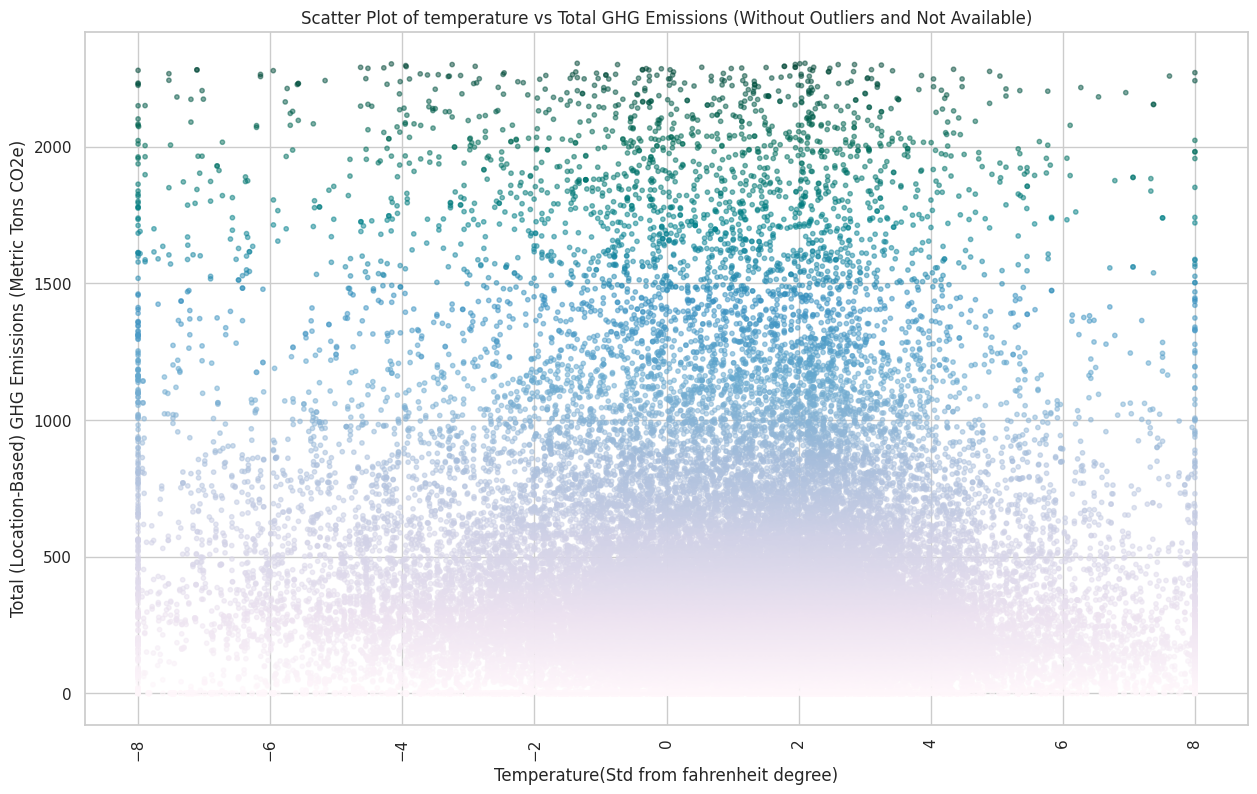

In [176]:
plt.rcParams['font.family'] = 'Liberation Mono'
sns.set(style='whitegrid')

# Define a threshold using the 95th percentile of the 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)

# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered3 = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]


# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                     vmax=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))



# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered['temperature'],
            df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10,c=colors)
plt.xlabel('Temperature(Std from fahrenheit degree)')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of temperature vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)
# Add a colorbar
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')
plt.savefig("figures/Scatter Plot of temperature vs Total GHG Emissions.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


<ipython-input-177-e61e38991f23>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='major use type', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',


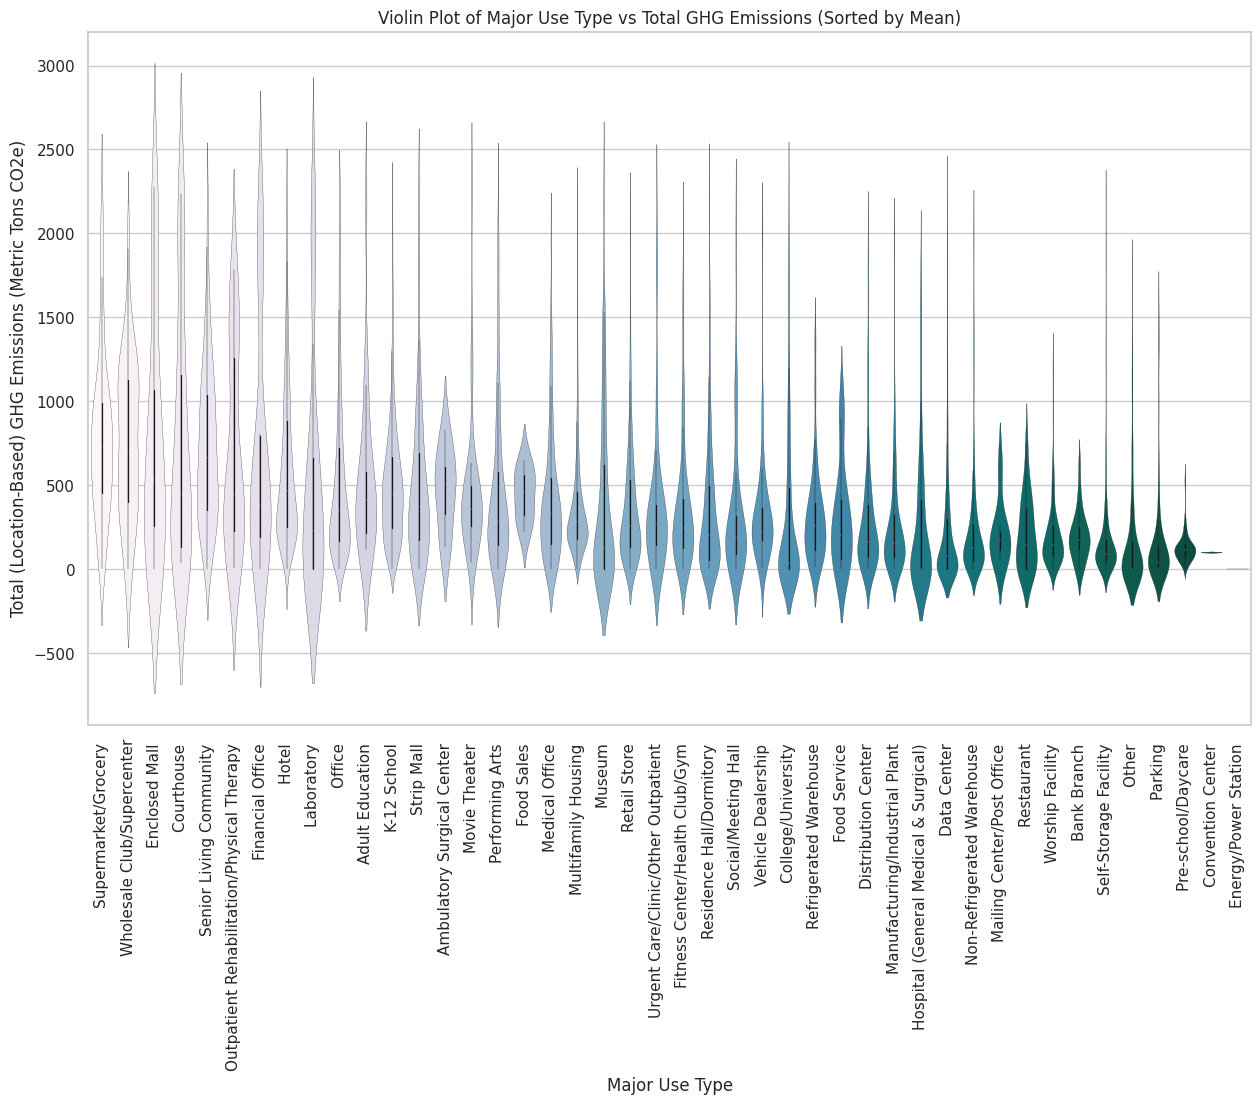

In [177]:
plt.rcParams['font.family'] = 'Liberation Mono'
sns.set(style='whitegrid')


# Calculate the mean of GHG emissions for each 'major use type'
mean_order = df_clean_filtered3.groupby('major use type')['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].mean().sort_values(ascending=False).index

# Create the violin plot with sorted x-axis
plt.figure(figsize=(15, 9))
sns.violinplot(x='major use type', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               data=df_clean_filtered3, palette='PuBuGn', linewidth=0.2, order=mean_order)

# Adjust the labels and plot aesthetics
plt.xticks(rotation=90)
plt.xlabel('Major Use Type')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Violin Plot of Major Use Type vs Total GHG Emissions (Sorted by Mean)')
plt.savefig("figures/Violin Plot of Major Use Type vs Total GHG Emissions (Sorted by Mean).png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


In [178]:
df_clean_filtered3.to_csv('data/df_clean_filtered3.csv', index=False)

The plot is sorted in descending order based on the mean value of GHG emissions for each major use type. We can see that some major use  type do contribute to higher GHG emissions.

In [179]:
# Group by NTA
df_nta = df_energy.groupby('Neighborhood Tabulation Area (NTA) (2020)').agg(
    avg_carbon_emission=('Total (Location-Based) GHG Emissions (Metric Tons CO2e)', np.mean),
    total_reported_buildings=('Neighborhood Tabulation Area (NTA) (2020)', 'size')
).reset_index()

# Display the first few rows of the new dataframe to verify the result
print('First few rows of df_nta:')
df_nta.head()

First few rows of df_nta:


<ipython-input-179-e7c8365541f1>:2: FutureWarning: The provided callable <function mean at 0x7c48b5de95a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nta = df_energy.groupby('Neighborhood Tabulation Area (NTA) (2020)').agg(


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  
0                       232  
1                       708  
2                       337  
3                       473  
4                       356

<ipython-input-180-ee5e906cc1aa>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_nta_filtered['avg_carbon_emission']))


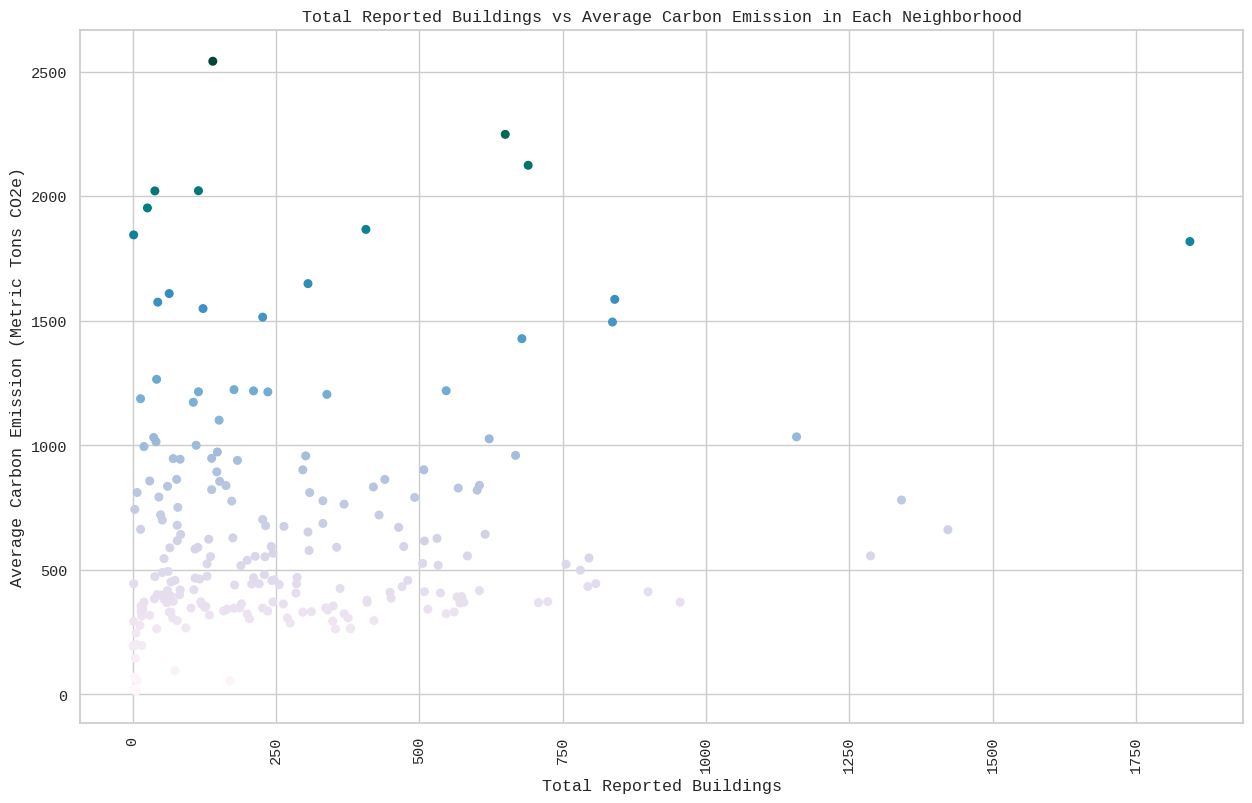

In [180]:

plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18


# Define a threshold using the 95th percentile of the 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
avgcarbon_threshold = df_nta['avg_carbon_emission'].quantile(0.95)

# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_nta_filtered = df_nta[df_nta['avg_carbon_emission'] <= avgcarbon_threshold]

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_nta_filtered['avg_carbon_emission'].min(),
                     vmax=df_nta_filtered['avg_carbon_emission'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_nta_filtered['avg_carbon_emission']))



# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_nta_filtered['total_reported_buildings'],
            df_nta_filtered['avg_carbon_emission'],
            alpha=1, s=30,c=colors)
plt.xlabel('Total Reported Buildings')
plt.ylabel('Average Carbon Emission (Metric Tons CO2e)')
plt.title('Total Reported Buildings vs Average Carbon Emission in Each Neighborhood')
plt.xticks(rotation=90)
# Add a colorbar
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='avg_carbon_emission)')
plt.savefig("figures/Total Reported Buildings vs Average Carbon Emission in Each Neighborhood.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


# Read in race demography by NTA of NYC


In [181]:

file_2_path = 'data/racebyNTA_NYC.csv'

# Reading the CSV files
df_racebyNTA = pd.read_csv(file_2_path, low_memory=False)

In [182]:
print('NYC Race Demography by NTA(neighborhood)')
print(df_racebyNTA.head())
print(df_racebyNTA.shape)

NYC Race Demography by NTA(neighborhood)
   Year  GeoType   Borough   GeoID  BCT2020                Name  CDType  \
0  2020  NTA2020  Brooklyn  BK0101      NaN          Greenpoint     NaN   
1  2020  NTA2020  Brooklyn  BK0102      NaN        Williamsburg     NaN   
2  2020  NTA2020  Brooklyn  BK0103      NaN  South Williamsburg     NaN   
3  2020  NTA2020  Brooklyn  BK0104      NaN   East Williamsburg     NaN   
4  2020  NTA2020  Brooklyn  BK0201      NaN    Brooklyn Heights     NaN   

   NTAType    Pop2  Pop2P  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP    ONH  \
0        0  38,980  100.0  ...  27,496  70.5  1,025   2.6  2,477   6.4    339   
1        0  64,444  100.0  ...  36,709  57.0  2,340   3.6  4,974   7.7    762   
2        0  47,703  100.0  ...  39,714  83.3  1,217   2.6    363   0.8  1,329   
3        0  52,998  100.0  ...  20,363  38.4  6,110  11.5  5,817  11.0    526   
4        0  25,092  100.0  ...  18,446  73.5    886   3.5  2,282   9.1    161   

   ONHP TwoPlNH  TwoP

The names are simplified in the data as below:  
Total population	Pop2  
Hispanic	Hsp1  
White non-Hispanic	WNH  
Black non-Hispanic	BNH  
Asian non-Hispanic	ANH  
Some other race non-Hispanic	ONH  
Non-Hispanic of two or more races	TwoPlNH  
Ending with P means percentage.  

In [183]:
# Merge df_nta and df_racebyNTA on 'Neighborhood Tabulation Area (NTA) (2020)' and 'GeoID'
df_combined = pd.merge(
    df_nta,
    df_racebyNTA,
    left_on='Neighborhood Tabulation Area (NTA) (2020)',
    right_on='GeoID',
    how='left'
)

# Display the first few rows of the merged dataframe
print('First few rows of the merged dataframe df_combined:')
df_combined.head()


First few rows of the merged dataframe df_combined:


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  Year  GeoType   Borough   GeoID  BCT2020  \
0                       232  2020  NTA2020  Brooklyn  BK0101      NaN   
1                       708  2020  NTA2020  Brooklyn  BK0102      NaN   
2                       337  2020  NTA2020  Brooklyn  BK0103      NaN   
3                       473  2020  NTA2020  Brooklyn  BK0104      NaN   
4                       356  2020  NTA2020  Brooklyn  BK0201      NaN   

                 Name  CDType  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP  \
0          Greenpoint     NaN  ...  27,496  70.5  1,025   2.6  2,477   6.4   
1        Williamsburg     NaN  ...  36,709  57.0  2,340   3.6  4,974   7.7   
2  South Williamsburg     NaN  ...  39,714  83.3  1,217   2.6    363   0.8   
3   East Williamsburg     NaN  ...  20,363  38.4  6,110  11.5  5,817  11.0   
4    Brooklyn Heights     NaN  ...  18,446  73.5    886   3.5  2,282   9.1   

     ONH ONHP  TwoPlNH TwoPlNHP  
0    339  0.9    1,636      4.2  
1    762  1.2    2,647      4.1  
2  1,329  2.8      945      2.0  
3    526  1.0    1,860      3.5  
4    161  0.6    1,356      5.4  

[5 rows x 25 columns]

In [184]:
df_combined.columns

Index(['Neighborhood Tabulation Area (NTA) (2020)', 'avg_carbon_emission',
       'total_reported_buildings', 'Year', 'GeoType', 'Borough', 'GeoID',
       'BCT2020', 'Name', 'CDType', 'NTAType', 'Pop2', 'Pop2P', 'Hsp1',
       'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP',
       'TwoPlNH', 'TwoPlNHP'],
      dtype='object')

In [185]:
df_combined.drop(columns=['GeoID','BCT2020','CDType','NTAType'], inplace=True)

##Summary Statistics:
###Continuous data:
 'avg_carbon_emission',
       'total_reported_buildings', 'Year' 'Pop2', 'Pop2P', 'Hsp1',
       'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP',
       'TwoPlNH', 'TwoPlNHP'
  
###Ordinal data:
nothing

  
###Categorical data:
'Neighborhood Tabulation Area (NTA) (2020)','Name', 'GeoType', 'Borough'

In [186]:
print('First few rows of the merged dataframe df_combined:')
df_combined.head()

First few rows of the merged dataframe df_combined:


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  Year  GeoType   Borough                Name  \
0                       232  2020  NTA2020  Brooklyn          Greenpoint   
1                       708  2020  NTA2020  Brooklyn        Williamsburg   
2                       337  2020  NTA2020  Brooklyn  South Williamsburg   
3                       473  2020  NTA2020  Brooklyn   East Williamsburg   
4                       356  2020  NTA2020  Brooklyn    Brooklyn Heights   

     Pop2  Pop2P    Hsp1  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP    ONH  \
0  38,980  100.0   6,007  ...  27,496  70.5  1,025   2.6  2,477   6.4    339   
1  64,444  100.0  17,012  ...  36,709  57.0  2,340   3.6  4,974   7.7    762   
2  47,703  100.0   4,135  ...  39,714  83.3  1,217   2.6    363   0.8  1,329   
3  52,998  100.0  18,322  ...  20,363  38.4  6,110  11.5  5,817  11.0    526   
4  25,092  100.0   1,961  ...  18,446  73.5    886   3.5  2,282   9.1    161   

  ONHP  TwoPlNH TwoPlNHP  
0  0.9    1,636      4.2  
1  1.2    2,647      4.1  
2  2.8      945      2.0  
3  1.0    1,860      3.5  
4  0.6    1,356      5.4  

[5 rows x 21 columns]

In [187]:
columns_continuous_nta = ['avg_carbon_emission', 'total_reported_buildings', 'Year', 'Pop2', 'Pop2P', 'Hsp1', 'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP', 'TwoPlNH', 'TwoPlNHP']
df_combined[columns_continuous_nta].describe()



avg_carbon_emission  total_reported_buildings    Year  Pop2P  \
count           230.000000                230.000000   230.0  227.0   
mean           1091.548428                268.656522  2020.0  100.0   
std            2730.393196                282.334790     0.0    0.0   
min              12.983333                  1.000000  2020.0  100.0   
25%             363.863536                 64.000000  2020.0  100.0   
50%             518.185477                177.500000  2020.0  100.0   
75%             856.885667                380.000000  2020.0  100.0   
max           30170.497500               1844.000000  2020.0  100.0   

            Hsp1P        WNHP        BNHP        ANHP        ONHP    TwoPlNHP  
count  225.000000  217.000000  219.000000  209.000000  208.000000  219.000000  
mean    30.285333   30.579263   20.964840   15.608612    1.928365    4.551598  
std     21.208594   25.330464   22.109197   15.748047    2.994409    6.076586  
min      5.600000    1.100000    0.600000    0.300000    0.300000    0.300000  
25%     12.800000    6.800000    3.450000    3.900000    0.900000    2.000000  
50%     22.400000   23.200000   12.400000   10.600000    1.100000    3.300000  
75%     42.900000   52.300000   29.950000   21.300000    1.500000    4.750000  
max    100.000000  100.000000   84.500000   77.500000   28.600000   50.000000

In [188]:

columns_categorical_nta = ['Neighborhood Tabulation Area (NTA) (2020)','Name', 'GeoType', 'Borough']
for column in columns_categorical_nta:
    print(f"\nFrequency counts for {column}:")
    print(df_combined[column].value_counts())


Frequency counts for Neighborhood Tabulation Area (NTA) (2020):
Neighborhood Tabulation Area (NTA) (2020)
SI9592    1
BK0101    1
BK0102    1
BK0103    1
BK0104    1
         ..
BK0301    1
BK0302    1
BK0401    1
BK0402    1
BK0501    1
Name: count, Length: 230, dtype: int64

Frequency counts for Name:
Name
Miller Field                 1
Greenpoint                   1
Williamsburg                 1
South Williamsburg           1
East Williamsburg            1
                            ..
Bedford-Stuyvesant (West)    1
Bedford-Stuyvesant (East)    1
Bushwick (West)              1
Bushwick (East)              1
Cypress Hills                1
Name: count, Length: 230, dtype: int64

Frequency counts for GeoType:
GeoType
NTA2020    230
Name: count, dtype: int64

Frequency counts for Borough:
Borough
Queens           70
Brooklyn         59
Bronx            45
Manhattan        36
Staten Island    20
Name: count, dtype: int64


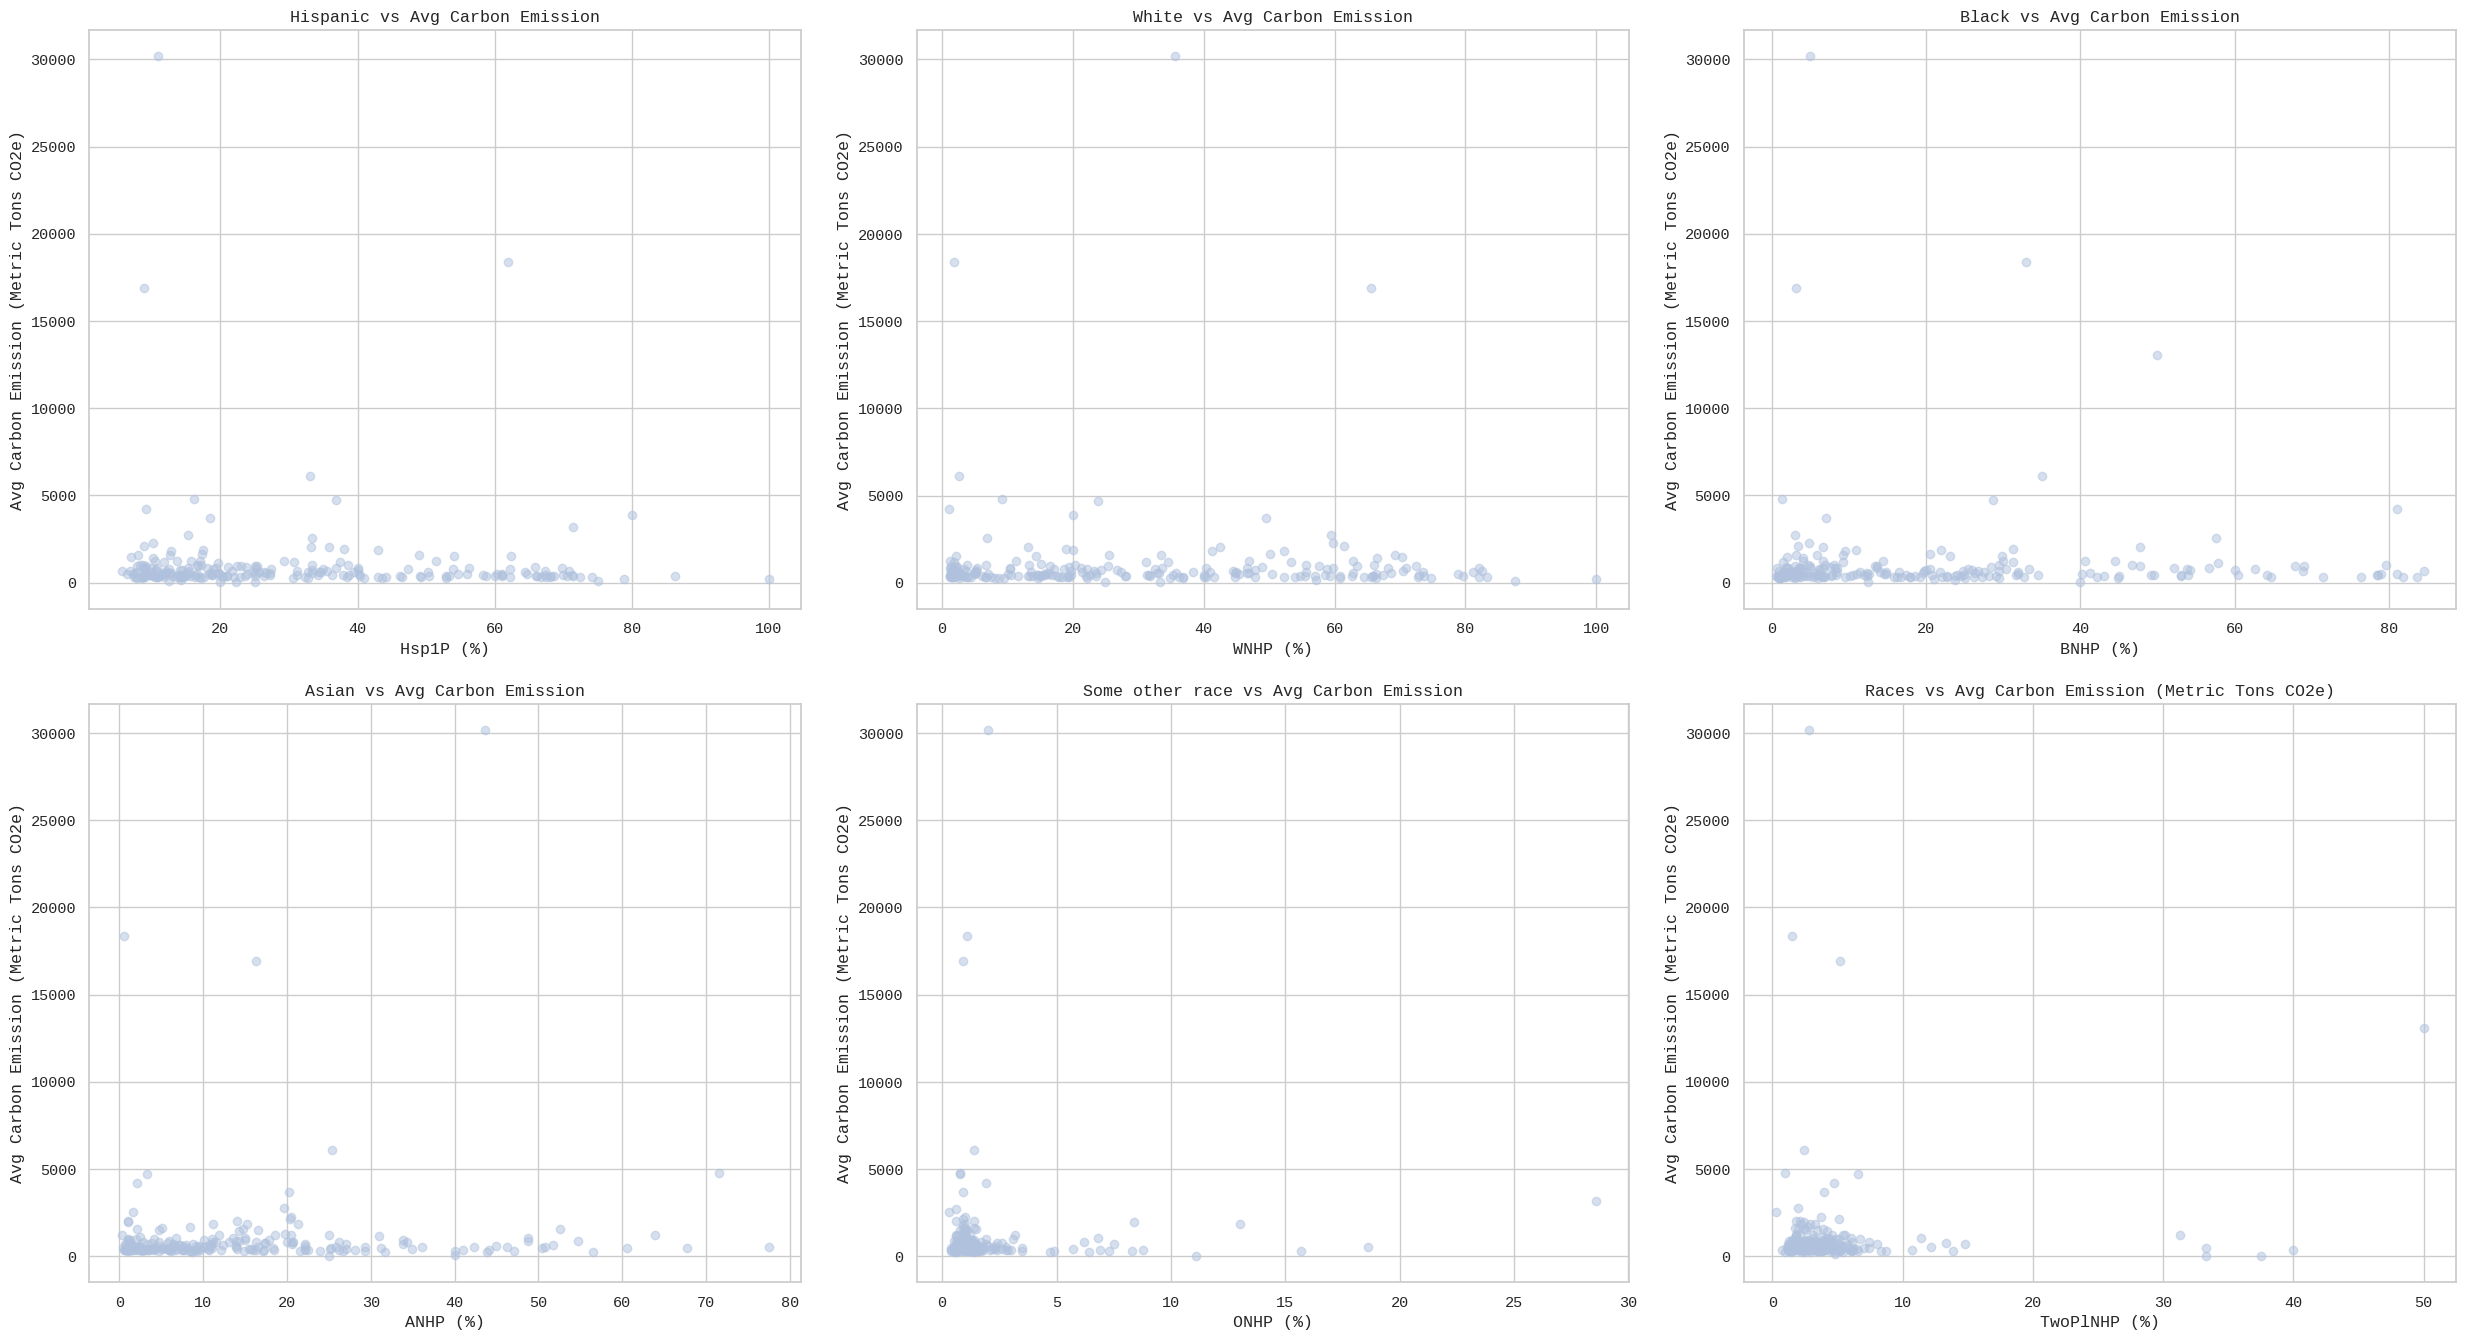

In [189]:

plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18


race_percentage_columns = ['Hsp1P', 'WNHP', 'BNHP', 'ANHP', 'ONHP', 'TwoPlNHP']
race_names = ['Hispanic', 'White', 'Black', 'Asian', 'Some other race', 'Two or more races']




plt.figure(figsize=(25, 20))

for i, race_col in enumerate(race_percentage_columns, 1):
    plt.subplot(3, 3, i)
    # Using plt.scatter with the specified color
    plt.scatter(x=df_combined[race_col], y=df_combined['avg_carbon_emission'], c='#afc1dd',alpha=0.5)
    plt.xlabel(f'{race_col} (%)')
    plt.ylabel('Avg Carbon Emission (Metric Tons CO2e)')
    plt.title(f'{race_names[i - 1]} vs Avg Carbon Emission')

plt.tight_layout()
plt.title('Races vs Avg Carbon Emission (Metric Tons CO2e)')
plt.savefig("figures/Races vs Avg Carbon Emission (Metric Tons CO2e).png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()


There doesn’t appear to be a strong linear relationship between the percentage of any specific racial group and carbon emissions.

#Data Preprocessing
###Handle Missing Data:
* Identify missing data and decide on appropriate imputation methods
I decide to drop columns with excessive missing data since they aren't critical for the analysis.  


###Outliers:
* There are significant outliers in total GHG emission and sum floor area.  If we do not filter it, the distribution on the plots will be skewed and the training and testing result would has very high MSE.

###Feature Engineering:
* I create new features from a temperature GIS data by getting the relative temperature of each building based on location. I also get the sum floor area and major use type from gross floor area of different use types. I also created a new data after categorization based on NTA.

###Categorization:
* I tried categorizing based on NTA to figure out the relationship between carbon emission and building counts and race demography.


###Scale:
* I do MinMax Scale later with data splitting to improve the model performance.

###One-hot encoding
* I do one hot encoding for major use type because in the EDA we can see that this is an important variable affecting the total GHG emissions and it is categorical.

#Data Splitting
Simply select the total GHG emissions as target, and major use type and sum floor area as X, do basic 80-20 split, use gradient boost to test if the split is reasonable

In [190]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

X = df_clean_filtered3[['major use type', 'sum floor area','Year Built']]  # Features
y = df_clean_filtered3['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']  # Target variable

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['sum floor area','Year Built']),
        ('cat', OneHotEncoder(), ['major use type'])
    ]
)

model = GradientBoostingRegressor(random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
     ('model', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shapes:')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

Shapes:
X_train shape: (45159, 3)
X_test shape: (11290, 3)
y_train shape: (45159,)
y_test shape: (11290,)


# Test on Regression

In [191]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 56682.601254393674
R-squared (R²): 0.6344662339237471
Mean Absolute Error (MAE): 141.87946561627652
Root Mean Squared Error (RMSE): 238.08108126097224


#New Attempt with more reasonable split


1.   Group data by 'major use type'. because I need to make sure every major use type present in both train and test sets.
2.   Split the data into training and test sets, ensuring that 'NYC Building Identification Number (BIN)' does not overlap between them. This is because we want each building only present in either train or test, not both, to prevent data leakage.
3.   Use KFold for cross-validation, but keep the 'major use type' for stratification. This is preventing overfitting through cross-validation.


In [192]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedGroupKFold

df_clean_filtered3_=df_clean_filtered3.drop_duplicates()

# Filter the dataset based on the mask
X = df_clean_filtered3_.drop(columns=['Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
                                     'Latitude', 'Longitude', 'Calendar Year', 'ENERGY STAR Score', 'temperature',
                                     'Property Name', 'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
                                     'geometry', 'Net Emissions (Metric Tons CO2e)','Total (Location-Based) GHG Emissions (Metric Tons CO2e)'])  # Ensure the building ID is dropped
y = df_clean_filtered3_['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']

print('X columns before preprocessing:')
print(X.columns)

print('The shape of X:')
print(X.shape)

print('Missing data in X:')
X.isnull().sum()



X columns before preprocessing:
Index(['NYC Building Identification Number (BIN)', 'Year Built',
       'sum floor area', 'major use type'],
      dtype='object')
The shape of X:
(55932, 4)
Missing data in X:


NYC Building Identification Number (BIN)    0
Year Built                                  0
sum floor area                              0
major use type                              0
dtype: int64

In [193]:
print('y target variable:')
print(y.name)

print('The shape of y:')
print(y.shape)

print('Missing data in y:')
y.isnull().sum()

y target variable:
Total (Location-Based) GHG Emissions (Metric Tons CO2e)
The shape of y:
(55932,)
Missing data in y:


0

In [194]:

help(StratifiedGroupKFold)

Help on class StratifiedGroupKFold in module sklearn.model_selection._split:

class StratifiedGroupKFold(GroupsConsumerMixin, _BaseKFold)
 |  StratifiedGroupKFold(n_splits=5, shuffle=False, random_state=None)
 |  
 |  Stratified K-Fold iterator variant with non-overlapping groups.
 |  
 |  This cross-validation object is a variation of StratifiedKFold attempts to
 |  return stratified folds with non-overlapping groups. The folds are made by
 |  preserving the percentage of samples for each class.
 |  
 |  Each group will appear exactly once in the test set across all folds (the
 |  number of distinct groups has to be at least equal to the number of folds).
 |  
 |  The difference between :class:`GroupKFold`
 |  and `StratifiedGroupKFold` is that
 |  the former attempts to create balanced folds such that the number of
 |  distinct groups is approximately the same in each fold, whereas
 |  `StratifiedGroupKFold` attempts to create folds which preserve the
 |  percentage of samples for ea

In [195]:
print('X columns before preprocessing:')
print(X.columns)

print('The shape of X:')
print(X.shape)

print('Missing data in X:')
X.isnull().sum()

print('y target variable:')
print(y.name)

print('The shape of y:')
print(y.shape)

print('Missing data in y:')
y.isnull().sum()

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

X columns before preprocessing:
Index(['NYC Building Identification Number (BIN)', 'Year Built',
       'sum floor area', 'major use type'],
      dtype='object')
The shape of X:
(55932, 4)
Missing data in X:
y target variable:
Total (Location-Based) GHG Emissions (Metric Tons CO2e)
The shape of y:
(55932,)
Missing data in y:


In [196]:


# Function to count occurrences and filter types
def filter_types(X, min_samples=2):
    type_ids = X['major use type']
    type_counts = type_ids.value_counts()
    print('Counts in each major use type:', type_counts)
    print('How many Types in total: ', len(type_counts))

    mask = type_ids.notna()
    type_ids = type_ids[mask]
    building_ids = X.loc[mask, 'NYC Building Identification Number (BIN)']

    return type_ids, building_ids, mask

# Function to check consistent building IDs
def check_consistent_ids(X, mask):
    def check_same_id(group):
        return group['NYC Building Identification Number (BIN)'].nunique() == 1

    id_check = X.loc[mask].groupby('major use type').apply(check_same_id)
    return id_check[id_check == True].index

# Initial processing
type_ids, building_ids, mask = filter_types(X)
consistent_ids = check_consistent_ids(X, mask)

# Separate consistent and inconsistent data
consistent_mask = X['major use type'].isin(consistent_ids)
X_consistent = X[consistent_mask]
y_consistent = y[consistent_mask]
building_ids_consistent = building_ids[consistent_mask]

inconsistent_mask = ~consistent_mask
X_inconsistent = X[inconsistent_mask]
y_inconsistent = y[inconsistent_mask]
type_ids_inconsistent = type_ids[inconsistent_mask]
building_ids_inconsistent = building_ids[inconsistent_mask]

# Stratified group K-fold object
n_splits = 5
stratified_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare for the split
train_indices_split=[]
val_indices_split=[]
test_indices_split=[]

randomstate=[42, 52, 62, 72, 82]

base_folder = 'data'



# Perform the stratified group split
for split_i, (i_train, i_test) in enumerate(stratified_group_kfold.split(X_inconsistent, type_ids_inconsistent, building_ids_inconsistent)):
    X_train_inconsistent, y_train_inconsistent = X_inconsistent.iloc[i_train], y_inconsistent.iloc[i_train]
    X_test_inconsistent, y_test_inconsistent = X_inconsistent.iloc[i_test], y_inconsistent.iloc[i_test]

    X_train_part, X_val, y_train_part, y_val = train_test_split(
        X_train_inconsistent,
        y_train_inconsistent,
        test_size=0.25,
        random_state=randomstate[split_i],
        stratify=type_ids_inconsistent.iloc[i_train]  # Stratify based on the training part
    )

    # Combine the consistent data with the training part of the inconsistent data
    X_train = pd.concat([X_consistent, X_train_part])
    y_train = pd.concat([y_consistent, y_train_part])

    # Prepare the test set
    X_test = X_test_inconsistent
    y_test = y_test_inconsistent

    train_type_ids = X_train['major use type']
    train_type_counts = train_type_ids.value_counts()
    print('Counts in each major use type in X_train:', train_type_counts)
    print('How many Types in total in X_train: ', len(train_type_counts))
    val_type_ids = X_val['major use type']
    val_type_counts = val_type_ids.value_counts()
    print('Counts in each major use type in X_val:', val_type_counts)
    print('How many Types in total in X_val: ', len(val_type_counts))
    test_type_ids = X_test['major use type']
    test_type_counts = test_type_ids.value_counts()
    print('Counts in each major use type in X_test:', test_type_counts)
    print('How many Types in total in X_test: ', len(test_type_counts))

    # Drop the building ID column from training and test sets if present
    for df in [X_train, X_test]:
        if 'NYC Building Identification Number (BIN)' in df.columns:
            df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)

    # One-Hot Encoding
    onehot_ftrs = ['major use type']
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    enc.fit(X[onehot_ftrs])

    # Transform datasets
    X_train_encoded = enc.transform(X_train[onehot_ftrs])
    X_val_encoded = enc.transform(X_val[onehot_ftrs])
    X_test_encoded = enc.transform(X_test[onehot_ftrs])

    # Convert to DataFrame
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=enc.get_feature_names_out(onehot_ftrs), index=X_train.index)
    X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=enc.get_feature_names_out(onehot_ftrs), index=X_val.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=enc.get_feature_names_out(onehot_ftrs), index=X_test.index)
    print('X_train_encoded_df head:', X_train_encoded_df.head)
    print('X_val_encoded_df head:', X_val_encoded_df.head)
    print('X_test_encoded_df head:', X_test_encoded_df.head)


    # Concatenate encoded features
    common_columns = X_train.columns.difference(onehot_ftrs)
    X_train = pd.concat([X_train[common_columns], X_train_encoded_df], axis=1)
    X_val = pd.concat([X_val[common_columns], X_val_encoded_df], axis=1)
    X_test = pd.concat([X_test[common_columns], X_test_encoded_df], axis=1)


    # Store indices
    train_indices_split.append(X_train.index)
    val_indices_split.append(X_val.index)
    test_indices_split.append(X_test.index)

    # Save fold data to CSV
    fold_folder = os.path.join(base_folder, f'fold_{split_i + 1}')
    os.makedirs(fold_folder, exist_ok=True)

    X_train.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}X_train.csv'), index=False)
    X_val.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}X_val.csv'), index=False)
    X_test.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}X_test.csv'), index=False)
    y_train.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}y_train.csv'), index=False)
    y_val.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}y_val.csv'), index=False)
    y_test.to_csv(os.path.join(fold_folder, f'fold_{split_i + 1}y_test.csv'), index=False)






Counts in each major use type: major use type
Multifamily Housing                            37675
Office                                          4084
K-12 School                                     3603
Data Center                                     2366
Hotel                                           1101
Non-Refrigerated Warehouse                       843
College/University                               726
Retail Store                                     606
Self-Storage Facility                            516
Residence Hall/Dormitory                         428
Worship Facility                                 398
Manufacturing/Industrial Plant                   356
Distribution Center                              313
Pre-school/Daycare                               300
Senior Living Community                          286
Medical Office                                   241
Strip Mall                                       204
Supermarket/Grocery                              203


<ipython-input-196-4775dead3c66>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_check = X.loc[mask].groupby('major use type').apply(check_same_id)


Counts in each major use type in X_train: major use type
Multifamily Housing                            22654
Office                                          2444
K-12 School                                     2177
Data Center                                     1447
Hotel                                            629
Non-Refrigerated Warehouse                       530
College/University                               442
Retail Store                                     364
Self-Storage Facility                            307
Residence Hall/Dormitory                         261
Worship Facility                                 232
Manufacturing/Industrial Plant                   211
Pre-school/Daycare                               187
Distribution Center                              184
Senior Living Community                          171
Medical Office                                   147
Strip Mall                                       129
Parking                                   

<ipython-input-196-4775dead3c66>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)


Counts in each major use type in X_train: major use type
Multifamily Housing                            22478
Office                                          2437
K-12 School                                     2188
Data Center                                     1339
Hotel                                            687
Non-Refrigerated Warehouse                       498
College/University                               434
Retail Store                                     364
Self-Storage Facility                            310
Residence Hall/Dormitory                         265
Worship Facility                                 252
Manufacturing/Industrial Plant                   217
Distribution Center                              200
Pre-school/Daycare                               177
Senior Living Community                          170
Medical Office                                   146
Parking                                          126
Fitness Center/Health Club/Gym            

<ipython-input-196-4775dead3c66>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)


Counts in each major use type in X_train: major use type
Multifamily Housing                            22688
Office                                          2464
K-12 School                                     2120
Data Center                                     1468
Hotel                                            673
Non-Refrigerated Warehouse                       505
College/University                               428
Retail Store                                     367
Self-Storage Facility                            310
Residence Hall/Dormitory                         255
Worship Facility                                 232
Manufacturing/Industrial Plant                   206
Distribution Center                              182
Pre-school/Daycare                               176
Senior Living Community                          163
Medical Office                                   138
Other                                            122
Supermarket/Grocery                       

<ipython-input-196-4775dead3c66>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)


Counts in each major use type in X_train: major use type
Multifamily Housing                            22593
Office                                          2474
K-12 School                                     2152
Data Center                                     1387
Hotel                                            652
Non-Refrigerated Warehouse                       499
College/University                               420
Retail Store                                     352
Self-Storage Facility                            322
Residence Hall/Dormitory                         262
Worship Facility                                 226
Manufacturing/Industrial Plant                   220
Distribution Center                              192
Senior Living Community                          175
Pre-school/Daycare                               171
Medical Office                                   135
Supermarket/Grocery                              126
Parking                                   

<ipython-input-196-4775dead3c66>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)


Counts in each major use type in X_train: major use type
Multifamily Housing                            22611
Office                                          2432
K-12 School                                     2171
Data Center                                     1455
Hotel                                            661
Non-Refrigerated Warehouse                       496
College/University                               454
Retail Store                                     370
Self-Storage Facility                            298
Worship Facility                                 250
Residence Hall/Dormitory                         241
Manufacturing/Industrial Plant                   213
Pre-school/Daycare                               189
Distribution Center                              181
Senior Living Community                          178
Medical Office                                   157
Other                                            132
Strip Mall                                

<ipython-input-196-4775dead3c66>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)


Plotting one-hot encoded data for Fold 1


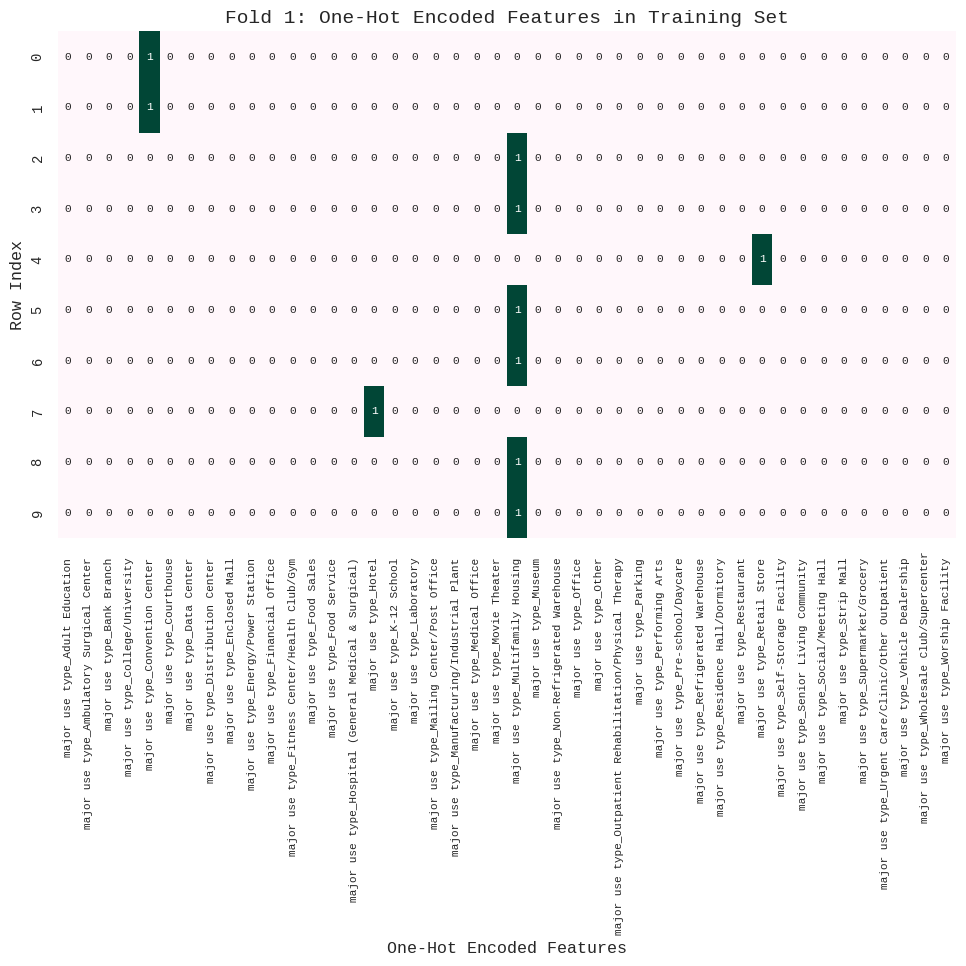

Plotting one-hot encoded data for Fold 2


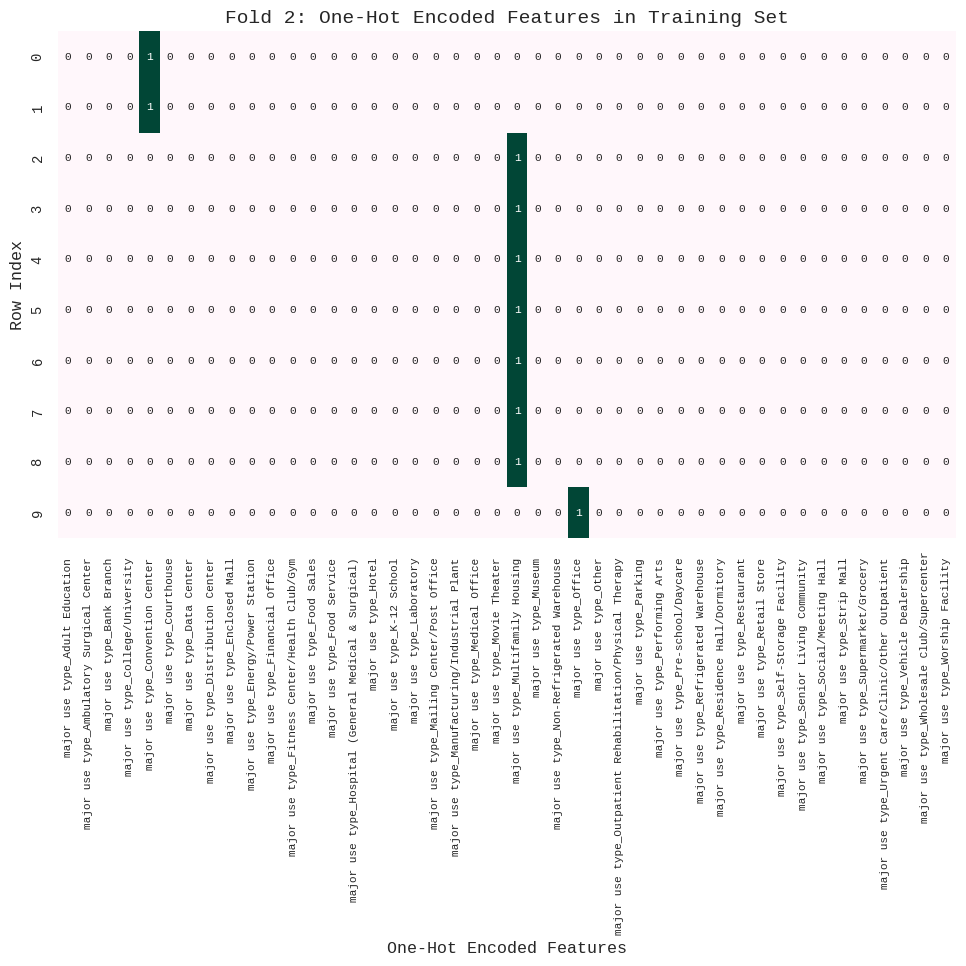

Plotting one-hot encoded data for Fold 3


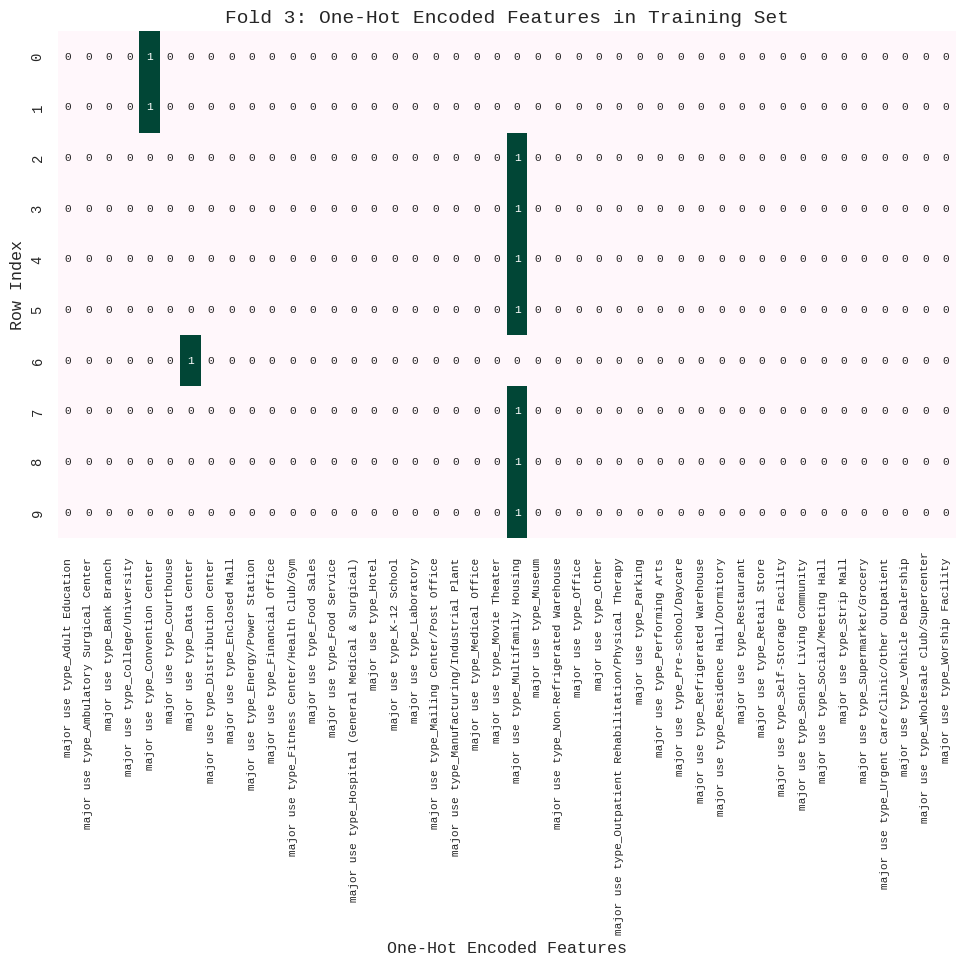

Plotting one-hot encoded data for Fold 4


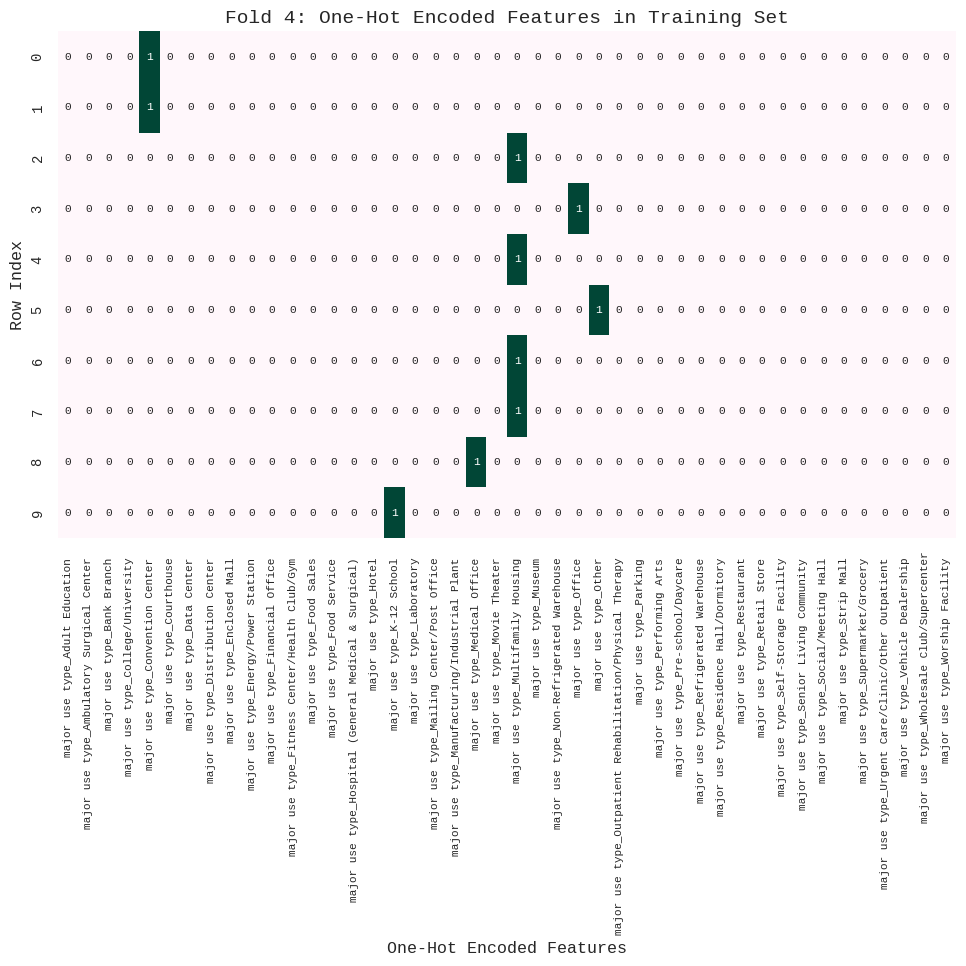

Plotting one-hot encoded data for Fold 5


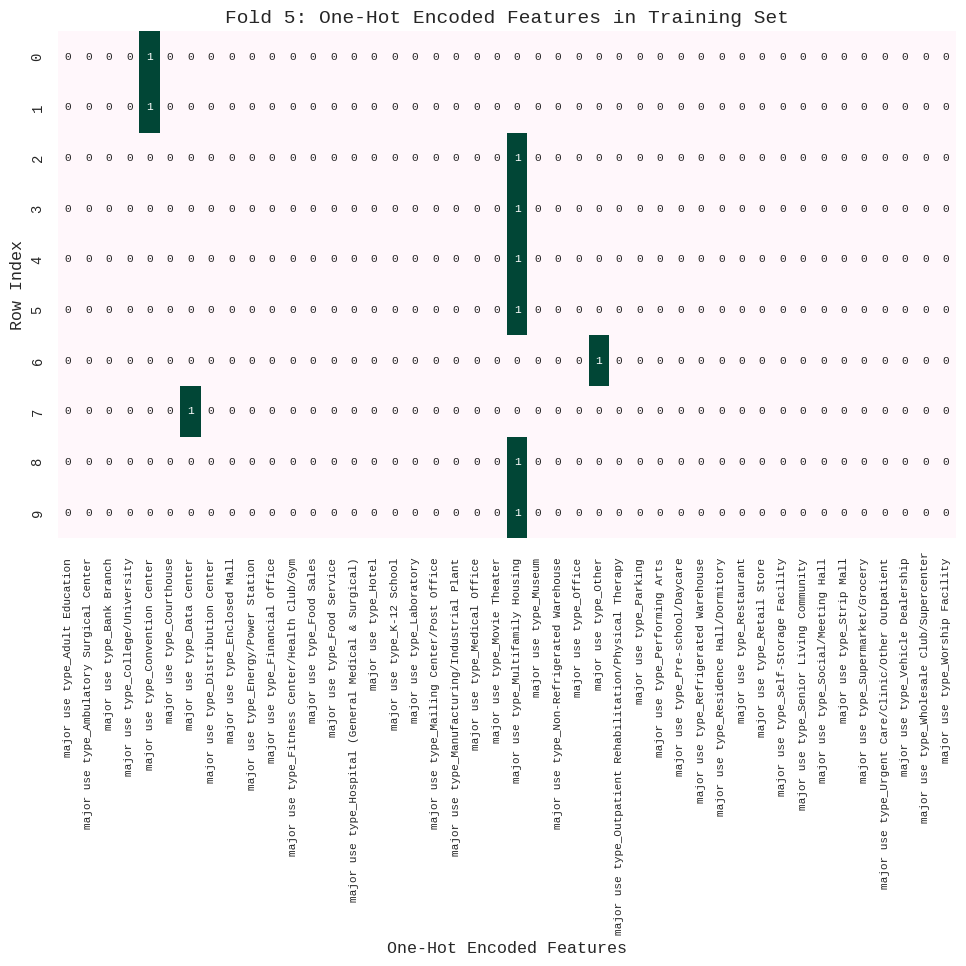

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Loop through each fold to visualize one-hot encoded data
for split_i in range(n_splits):
    print(f"Plotting one-hot encoded data for Fold {split_i + 1}")

    # Load the one-hot encoded training data for this fold
    train_indices = train_indices_split[split_i]

    X_train_split = X.loc[train_indices]

    # Apply one-hot encoding to the training dataset
    X_train_encoded = enc.transform(X_train_split[onehot_ftrs])

    # Convert to DataFrame for visualization
    train_encoded_df = pd.DataFrame(X_train_encoded, columns=enc.get_feature_names_out(onehot_ftrs))

    # Select the first 10 rows for visualization
    train_sample = train_encoded_df.iloc[:10]  # Keep this as a DataFrame

    # Create a heatmap for the training set
    plt.figure(figsize=(10, 10))  # Wider figure size for better column spacing
    sns.heatmap(
        train_sample,
        cmap="PuBuGn",
        cbar=False,
        annot=True,  # Display 0.0 and 1.0 in the cells
        fmt='.0f',  # Format floats as integers
        annot_kws={"size": 8},  # Smaller text in cells
        linewidths=0,  # Add spacing between cells for better readability
        linecolor='gray'
    )
    plt.title(f'Fold {split_i + 1}: One-Hot Encoded Features in Training Set', fontsize=14)
    plt.xlabel('One-Hot Encoded Features', fontsize=12)
    plt.ylabel('Row Index', fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=10)
    plt.savefig(f"figures/Fold {split_i + 1}: One-Hot Encoded Features in Training Set.png", transparent=True, bbox_inches='tight', dpi=300)

    plt.tight_layout()
    plt.show()


In [198]:
print('X columns before preprocessing:')
print(X.columns)

print('The shape of X_train:')
print(X_train.shape)

print('The shape of X_val:')
print(X_val.shape)

print('The shape of X_test:')
print(X_test.shape)

print('X columns after preprocessing:')
print(X_train.columns)

print('Missing data in X:')
X.isnull().sum()

print('y target variable:')
print(y.name)

print('The shape of y:')
print(y.shape)

print('Missing data in y:')
y.isnull().sum()

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

X columns before preprocessing:
Index(['NYC Building Identification Number (BIN)', 'Year Built',
       'sum floor area', 'major use type'],
      dtype='object')
The shape of X_train:
(33614, 46)
The shape of X_val:
(11205, 46)
The shape of X_test:
(11113, 46)
X columns after preprocessing:
Index(['Year Built', 'sum floor area', 'major use type_Adult Education ',
       'major use type_Ambulatory Surgical Center ',
       'major use type_Bank Branch ', 'major use type_College/University ',
       'major use type_Convention Center ', 'major use type_Courthouse ',
       'major use type_Data Center ', 'major use type_Distribution Center ',
       'major use type_Enclosed Mall ', 'major use type_Energy/Power Station ',
       'major use type_Financial Office ',
       'major use type_Fitness Center/Health Club/Gym ',
       'major use type_Food Sales ', 'major use type_Food Service ',
       'major use type_Hospital (General Medical & Surgical) ',
       'major use type_Hotel ', 'major u

In [199]:
print(X_train.head)

<bound method NDFrame.head of        Year Built  sum floor area  major use type_Adult Education   \
15144        1921         31680.0                              0.0   
31984        1921         31680.0                              0.0   
9356         1926        206009.0                              0.0   
52559        1929         53460.0                              0.0   
36729        1928         76500.0                              0.0   
...           ...             ...                              ...   
25632        1949         90060.0                              0.0   
45224        1980         43000.0                              0.0   
50458        1961        129325.0                              0.0   
19992        1965        265625.0                              0.0   
38997        1930         95807.0                              0.0   

       major use type_Ambulatory Surgical Center   \
15144                                         0.0   
31984                  

In [200]:
# Function to calculate R2 score
def R2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def create_pipeline(categorical_features, numerical_features, ML_algo):
    # Define the preprocessor for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )

    # Create the complete pipeline
    pipeline = make_pipeline(
        preprocessor,
        ML_algo
    )

    return pipeline




In [201]:
import pickle
import os
# Function to save models
def save_models_to_pickle(trained_models, ML_algo_name, directory="results/saved_models"):
    # Create a directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    for i, model in enumerate(trained_models):
        # Define the filename using the ML_algo name and fold index
        filename = os.path.join(directory, f"{ML_algo_name}_model_fold_{i+1}.pkl")

        # Save the model
        with open(filename, 'wb') as f:
            pickle.dump(model, f)


In [202]:
print(X.columns)
print(X.head)
print(y.head)


Index(['NYC Building Identification Number (BIN)', 'Year Built',
       'sum floor area', 'major use type'],
      dtype='object')
<bound method NDFrame.head of       NYC Building Identification Number (BIN)  Year Built  sum floor area  \
0                                      4059918        1930         51749.0   
1                                      2047795        1960         52941.0   
2                                      4300145        1941         35196.0   
3                                      1052383        1898        107234.0   
4                                      4017180        1911         75191.0   
...                                        ...         ...             ...   
55927                                  4450746        1951        285876.0   
55928                                  4079606        1931        104982.0   
55929                                  1064074        1912         54268.0   
55930                                  3100246        1927 

In [203]:
from scipy.sparse import csr_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_model_pipeline(ML_algo):
    """
    Create a pipeline that includes only the ML algorithm, assuming preprocessing is already done.
    """
    return make_pipeline(
        ML_algo
    )

def preprocess_with_train_encoder(pipeline, X_train, X_val, X_test,categorical_features, numerical_features):
    """
    Preprocess validation and test data using the fitted encoder and scaler from the pipeline.
    Align features with the training set.
    """
    print('preprocess with train encoder')
    # Extract the preprocessor from the pipeline
    preprocessor = pipeline.named_steps['columntransformer']

    # Fit the pipeline on the training data
    preprocessor.fit(X_train)


    # Transform training data
    X_train_transformed = preprocessor.transform(X_train)

    # Get the feature names generated from training data
    feature_names = (
        preprocessor.named_transformers_['cat']
        .get_feature_names_out(input_features=categorical_features)
    )
    all_feature_names = list(numerical_features) + list(feature_names)

    # Transform and align validation and test data
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)

    # Convert transformed data back to DataFrame for easier alignment (optional)
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
    X_val_transformed = pd.DataFrame(X_val_transformed, columns=all_feature_names)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_feature_names)
    print('preprocess with train encoder completed')

    return X_train_transformed, X_val_transformed, X_test_transformed



def MLpipe_StratifiedGroupKFold_R2(X, y, categorical_features, numerical_features, ML_algo, param_grid):
    val_r2_scores = []
    test_r2_scores = []
    trained_models = []

    for split_i in range(len(train_indices_split)):
        print(f"\n--- Fold {split_i + 1}/{len(train_indices_split)} ---")
        train_indices = train_indices_split[split_i]
        val_indices = val_indices_split[split_i]
        test_indices = test_indices_split[split_i]

        X_train = X.loc[train_indices]
        y_train = y.loc[train_indices]
        X_val = X.loc[val_indices]
        y_val = y.loc[val_indices]
        X_test = X.loc[test_indices]
        y_test = y.loc[test_indices]




        # Debugging: Print shapes and indices
        print("Initial Data Shapes:")
        print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
        print("X_val.shape:", X_val.shape, "y_val.shape:", y_val.shape)
        print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

        # Drop unwanted columns
        for df in [X_train, X_test, X_val]:
            if 'NYC Building Identification Number (BIN)' in df.columns:
                df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)

        # Create pipeline
        pipeline = create_pipeline(categorical_features, numerical_features, ML_algo)

        # Preprocess data
        X_train_transformed, X_val_transformed, X_test_transformed = preprocess_with_train_encoder(
            pipeline, X_train, X_val, X_test, categorical_features, numerical_features
        )

        # Convert sparse matrices to dense arrays (if applicable)
        if isinstance(X_train_transformed, csr_matrix):
            X_train_transformed = X_train_transformed.toarray()
        if isinstance(X_val_transformed, csr_matrix):
            X_val_transformed = X_val_transformed.toarray()
        if isinstance(X_test_transformed, csr_matrix):
            X_test_transformed = X_test_transformed.toarray()

        y_train = y_train.values if hasattr(y_train, 'values') else y_train
        y_val = y_val.values if hasattr(y_val, 'values') else y_val
        y_test = y_test.values if hasattr(y_test, 'values') else y_test

        print('X_train_transformed.shape:', X_train_transformed.shape)
        print("y_train.shape:", y_train.shape)
        print('X_val_transformed.shape:', X_val_transformed.shape)
        print("y_val.shape:", y_val.shape)
        print('X_test_transformed.shape:', X_test_transformed.shape)
        print("y_test.shape:", y_test.shape)

        pipeline = create_model_pipeline(ML_algo)

        # Define fit parameters if model supports eval_set
        fit_params = {}
        if isinstance(ML_algo, XGBRegressor):
            fit_params = {
                "xgbregressor__eval_set": [(X_val_transformed, y_val)],
                "xgbregressor__verbose": True
            }
            print(f"Using early stopping with eval_set and early_stopping_rounds=50 for XGBRegressor.")

        # Use GridSearchCV
        print(f"Running GridSearchCV for fold {split_i + 1}...")
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='r2',  # Use R² as the scoring metric
            cv=5,
            n_jobs=-1
        )

        # Fit the model using GridSearchCV
        grid_search.fit(X_train_transformed, y_train, **fit_params)

        # Best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Validate on validation set
        y_val_pred = best_model.predict(X_val_transformed)  # Use transformed X_val
        val_r2 = best_model.score(X_val_transformed, y_val)  # Calculate R²
        val_r2_scores.append(val_r2)

        # Test on test set
        y_test_pred = best_model.predict(X_test_transformed)  # Use transformed X_test
        test_r2 = best_model.score(X_test_transformed, y_test)  # Calculate R²
        test_r2_scores.append(test_r2)

        # Store the trained model
        trained_models.append(best_model)

    return val_r2_scores, test_r2_scores, trained_models



In [204]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# test your function with a linear regression model (l1 regularization)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


ML_algo = Lasso()
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10],
    'lasso__fit_intercept': [True, False]
}


# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...

--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (335

In [ ]:
import pickle
import os
# Function to save models
def save_models_to_pickle(trained_models, ML_algo_name, directory="results/saved_models"):
    # Create a directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    for i, model in enumerate(trained_models):
        # Define the filename using the ML_algo name and fold index
        filename = os.path.join(directory, f"{ML_algo_name}_model_fold_{i+1}.pkl")

        # Save the model
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")

Models saved to the 'saved_models' directory.


In [ ]:
from xgboost import XGBRegressor


# Instantiate model
ML_algo = XGBRegressor(objective='reg:squarederror', random_state=42, tree_method="hist", device="cuda", early_stopping_rounds=50)

# Define parameter grid
param_grid = {
    "xgbregressor__learning_rate": [0.03],
    "xgbregressor__n_estimators": [10000],
    "xgbregressor__reg_alpha":  [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "xgbregressor__reg_lambda":  [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "xgbregressor__max_depth": [3, 10],
    "xgbregressor__colsample_bytree": [0.9],
    "xgbregressor__subsample": [0.66]
}

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")



--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Using early stopping with eval_set and early_stopping_rounds=50 for XGBRegressor.
Running GridSearchCV for fold 1...
[0]	validation_0-rmse:380.23436
[1]	validation_0-rmse:373.31924
[2]	validation_0-rmse:366.75424
[3]	validation_0-rmse:360.36541
[4]	validation_0-rmse:354.24755
[5]	validation_0-rmse:348.40543
[6]	validation_0-rmse:342.74499
[7]	validation_0-rmse:337.37262
[8]	validation_0-rmse:332.11811
[9]	validation_0-rmse:327.15479
[10]	validation_0-rmse:322.54296
[11]	validation_0-rmse:318.12394
[12]	validation_0-rmse:313.79637
[13]	validation_0-rmse:309.8

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


ML_algo=Ridge(fit_intercept=True)
param_grid={
        'ridge__alpha': [0.01, 0.1, 1, 10],
        'ridge__fit_intercept': [True, False]
        }

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...

--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (335

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

ML_algo=ElasticNet(max_iter=10000)
param_grid={
        'elasticnet__alpha': [0.01, 0.1, 1, 10],
        'elasticnet__l1_ratio': [0,0.2,0.4,0.8,1]
        }

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...

--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (335

In [ ]:
from sklearn.ensemble import RandomForestRegressor
ML_algo=RandomForestRegressor(random_state=42)
param_grid = {
    'randomforestregressor__max_depth': [1, 3, 10, 30, 100],
    'randomforestregressor__max_features': [1, 3, 10, 30, 100]
}

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (33599, 4) y_train.shape: (33599,)
X_val.shape: (11200, 4) y_val.shape: (11200,)
X_test.shape: (11133, 4) y_test.shape: (11133,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33599, 46)
y_train.shape: (33599,)
X_val_transformed.shape: (11200, 46)
y_val.shape: (11200,)
X_test_transformed.shape: (11133, 46)
y_test.shape: (11133,)
Running GridSearchCV for fold 3...

--- Fold 4/5 ---
Initial Data Shapes:
X_train.shape: (334

In [ ]:
from sklearn.svm import SVR
ML_algo=SVR()
param_grid={
    'svr__gamma': [1e-3, 1e-1, 1e1, 1e3],
    'svr__C': [1e-2, 1e-1, 1e0, 1e1, 1e2]
        }

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...

--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (335

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
ML_algo=KNeighborsRegressor()
param_grid={
    'kneighborsregressor__n_neighbors': [ 1, 3, 10, 30, 100],
        }

# Run the function
val_r2_scores, test_r2_scores, trained_models = MLpipe_StratifiedGroupKFold_R2(
    X, y, cat_features, num_features, ML_algo, param_grid
)

print('Validation R2 Scores:', val_r2_scores)
print('Average Validation R2:', np.mean(val_r2_scores))
print('Standard Deviation of Validation R2:', np.std(val_r2_scores))
print('Test R2 Scores:', test_r2_scores)
print('Average Test R2:', np.mean(test_r2_scores))
print('Standard Deviation of Test R2:', np.std(test_r2_scores))

print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_r2_scores)])
print('corresponding validation score:',np.max(val_r2_scores))

# Define the algorithm name for saving
ML_algo_name = ML_algo.__class__.__name__

# Save all trained models
save_models_to_pickle(trained_models, ML_algo_name)

print(f"Models saved to the 'saved_models' directory.")


--- Fold 1/5 ---
Initial Data Shapes:
X_train.shape: (33664, 4) y_train.shape: (33664,)
X_val.shape: (11221, 4) y_val.shape: (11221,)
X_test.shape: (11047, 4) y_test.shape: (11047,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33664, 46)
y_train.shape: (33664,)
X_val_transformed.shape: (11221, 46)
y_val.shape: (11221,)
X_test_transformed.shape: (11047, 46)
y_test.shape: (11047,)
Running GridSearchCV for fold 1...

--- Fold 2/5 ---
Initial Data Shapes:
X_train.shape: (33422, 4) y_train.shape: (33422,)
X_val.shape: (11141, 4) y_val.shape: (11141,)
X_test.shape: (11369, 4) y_test.shape: (11369,)
preprocess with train encoder
preprocess with train encoder completed
X_train_transformed.shape: (33422, 46)
y_train.shape: (33422,)
X_val_transformed.shape: (11141, 46)
y_val.shape: (11141,)
X_test_transformed.shape: (11369, 46)
y_test.shape: (11369,)
Running GridSearchCV for fold 2...

--- Fold 3/5 ---
Initial Data Shapes:
X_train.shape: (335

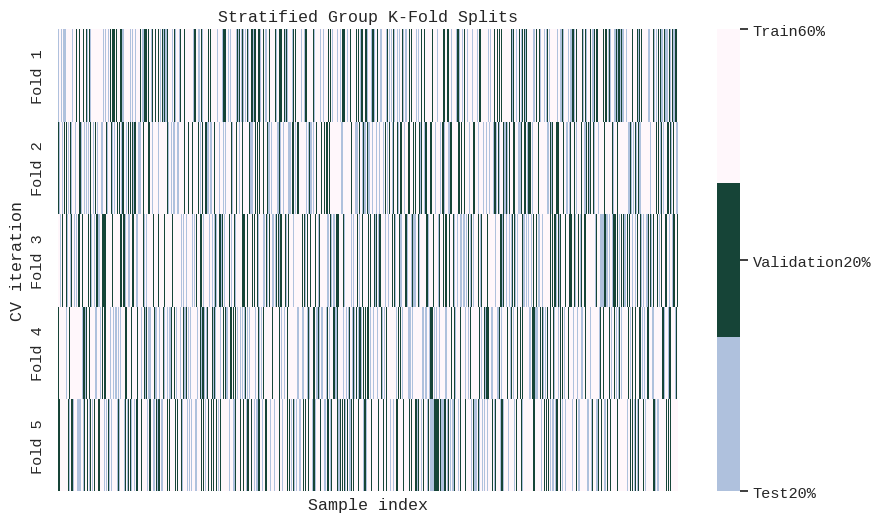

In [208]:


plt.rcParams['font.family'] = 'Liberation Mono'
plt.rcParams['font.size'] = 18


# Visualization of splits
splits = np.zeros((n_splits, len(X)), dtype=int)
for split_index in range(n_splits):
    splits[split_index, train_indices_split[split_index]] = 2
    splits[split_index, val_indices_split[split_index]] = 1
    splits[split_index, test_indices_split[split_index]] = 0

# Visualization
cmap = sns.color_palette(['#afc1dd', '#164437', '#fff7fb'], as_cmap=True)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(splits, cmap=cmap, cbar=True, vmin=0, vmax=2, yticklabels=[f'Fold {i}' for i in range(1, n_splits + 1)], xticklabels=False)

# Customize the colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks([2, 1, 0])
cbar.set_ticklabels(['Train60%', 'Validation20%', 'Test20%'])

plt.xlabel('Sample index')
plt.ylabel('CV iteration')
plt.title('Stratified Group K-Fold Splits')
plt.savefig(f"figures/Stratified Group K-Fold Splits.png", transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [209]:
for split_i, (i_train, i_test) in enumerate(stratified_group_kfold.split(X_inconsistent, type_ids_inconsistent, building_ids_inconsistent)):
    print(f'Fold {split_i+1}')
    print(f'Train indices: {i_train[:5]}')  # Print first 10 train indices (or more if needed)
    print(f'Test indices: {i_test[:5]}')


Fold 1
Train indices: [0 1 2 3 4]
Test indices: [ 8 14 19 25 46]
Fold 2
Train indices: [0 1 2 3 4]
Test indices: [13 15 17 18 24]
Fold 3
Train indices: [0 3 4 6 7]
Test indices: [ 1  2  5  9 11]
Fold 4
Train indices: [0 1 2 5 6]
Test indices: [ 3  4 10 20 22]
Fold 5
Train indices: [1 2 3 4 5]
Test indices: [ 0  6  7 16 23]


In [210]:
import pickle
import os

def load_models_from_pickle(directory="results/saved_models", ML_algo_name=None):
    """
    Load a specific saved model or models from a directory.

    Parameters:
    - directory: Directory where models are saved.
    - ML_algo_name: Optional. Specific algorithm name to load (e.g., 'XGBRegressor').

    Returns:
    - List of loaded models or a single model if only one matches.
    """
    model_files = [
        os.path.join(directory, filename)
        for filename in sorted(os.listdir(directory))
        if filename.endswith(".pkl") and (ML_algo_name is None or ML_algo_name in filename)
    ]

    if not model_files:
        raise FileNotFoundError(f"No matching models found in {directory} for {ML_algo_name}")

    models = []
    for model_file in model_files:
        print(f"Loading model from {model_file}...")
        with open(model_file, 'rb') as f:
            models.append(pickle.load(f))

    print(f"Loaded {len(models)} models for {ML_algo_name}.")
    return models


In [211]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def calculate_scores_for_models(models, train_splits, val_splits, test_splits, X, y, cat_features, num_features):
    """
    Calculate train, validation, and test R² and RMSE scores for each model.

    Parameters:
    - models: List of trained models.
    - train_splits, val_splits, test_splits: Lists of indices for train, validation, and test sets.
    - X: Feature DataFrame.
    - y: Target Series.
    - cat_features: List of categorical features.
    - num_features: List of numerical features.

    Returns:
    - Dictionary with train, validation, and test R² and RMSE scores for each fold.
    """
    scores = {
        "train_r2": [], "validation_r2": [], "test_r2": [],
        "train_rmse": [], "validation_rmse": [], "test_rmse": []
    }

    for i, model in enumerate(models):
        print(f"Evaluating model for Fold {i+1}...")

        # Get indices for the current fold
        train_indices = train_splits[i]
        val_indices = val_splits[i]
        test_indices = test_splits[i]

        # Get corresponding data
        X_train, y_train = X.loc[train_indices], y.loc[train_indices]
        X_val, y_val = X.loc[val_indices], y.loc[val_indices]
        X_test, y_test = X.loc[test_indices], y.loc[test_indices]

        # Debugging: Print shapes and indices
        print("Initial Data Shapes:")
        print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
        print("X_val.shape:", X_val.shape, "y_val.shape:", y_val.shape)
        print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

        # Drop unwanted columns
        for df in [X_train, X_test, X_val]:
            if 'NYC Building Identification Number (BIN)' in df.columns:
                df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)

        fold_folder = os.path.join(base_folder, f'unprocessed_fold_{i + 1}')
        os.makedirs(fold_folder, exist_ok=True)

        X_train.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_X_train.csv'), index=False)
        X_val.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_X_val.csv'), index=False)
        X_test.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_X_test.csv'), index=False)
        y_train.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_y_train.csv'), index=False)
        y_val.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_y_val.csv'), index=False)
        y_test.to_csv(os.path.join(fold_folder, f'unprocessed_fold_{i + 1}_y_test.csv'), index=False)



        # Create pipeline
        pipeline = create_pipeline(cat_features, num_features, model)

        # Preprocess data
        X_train_transformed, X_val_transformed, X_test_transformed = preprocess_with_train_encoder(
            pipeline, X_train, X_val, X_test, cat_features, num_features
        )

        # Convert sparse matrices to dense arrays (if applicable)
        if isinstance(X_train_transformed, csr_matrix):
            X_train_transformed = X_train_transformed.toarray()
        if isinstance(X_val_transformed, csr_matrix):
            X_val_transformed = X_val_transformed.toarray()
        if isinstance(X_test_transformed, csr_matrix):
            X_test_transformed = X_test_transformed.toarray()

        y_train = y_train.values if hasattr(y_train, 'values') else y_train
        y_val = y_val.values if hasattr(y_val, 'values') else y_val
        y_test = y_test.values if hasattr(y_test, 'values') else y_test

        print('X_train_transformed.shape:', X_train_transformed.shape)
        print("y_train.shape:", y_train.shape)
        print('X_val_transformed.shape:', X_val_transformed.shape)
        print("y_val.shape:", y_val.shape)
        print('X_test_transformed.shape:', X_test_transformed.shape)
        print("y_test.shape:", y_test.shape)

        # Predict and calculate R² scores
        train_r2 = r2_score(y_train, model.predict(X_train_transformed))
        val_r2 = r2_score(y_val, model.predict(X_val_transformed))
        test_r2 = r2_score(y_test, model.predict(X_test_transformed))

        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train_transformed)))
        val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val_transformed)))
        test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_transformed)))

        # Store scores
        scores["train_r2"].append(train_r2)
        scores["validation_r2"].append(val_r2)
        scores["test_r2"].append(test_r2)

        scores["train_rmse"].append(train_rmse)
        scores["validation_rmse"].append(val_rmse)
        scores["test_rmse"].append(test_rmse)

        print(f"Fold {i+1}: Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"Fold {i+1}: Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

        # Compute the mean of y_train
        y_mean_infold = np.mean(y_train)

        # Predict the mean for all y_test samples (baseline prediction)
        baseline_pred_infold = np.full_like(y_test, y_mean_infold)

        # Calculate baseline R² and RMSE
        baseline_r2_infold = r2_score(y_test, baseline_pred_infold)
        baseline_rmse_infold = np.sqrt(mean_squared_error(y_test, baseline_pred_infold))

        print(f"Baseline R² Score based on fold {i}:", baseline_r2_infold)
        print(f"Baseline RMSE based on fold {i}:", baseline_rmse_infold)
    return scores

In [212]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scores(scores, title="Model Scores Across Folds"):
    """
    Plot train, validation, and test scores for each fold.

    Parameters:
    - scores: Dictionary containing train, validation, and test scores.
    - title: Title of the plot.
    """
    folds = np.arange(1, len(scores["train_r2"]) + 1)
    colors = ['#afc1dd', '#164437', '#268bb0']

    plt.figure(figsize=(12, 6))
    plt.plot(folds, scores["train_r2"], marker='o', label='Train R²',color=colors[0], linestyle='-', linewidth=2)
    plt.plot(folds, scores["validation_r2"], marker='s', label='Validation R²',color=colors[1],  linestyle='-', linewidth=2)
    plt.plot(folds, scores["test_r2"], marker='^', label='Test R²',color=colors[2], linestyle='-', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel('R² Score', fontsize=14)
    plt.xticks(folds)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/Mean and Standard Deviation of R² Scores for {ML_algo_name}.png", transparent=True, bbox_inches='tight', dpi=300)
    plt.show()




Loading results from pickle file...






Hyperparameters for XGBRegressor:
Loading model from results/saved_models/XGBRegressor_model_fold_1.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_2.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_3.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_4.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_5.pkl...
Loaded 5 models for XGBRegressor.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('xgbregressor', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_c

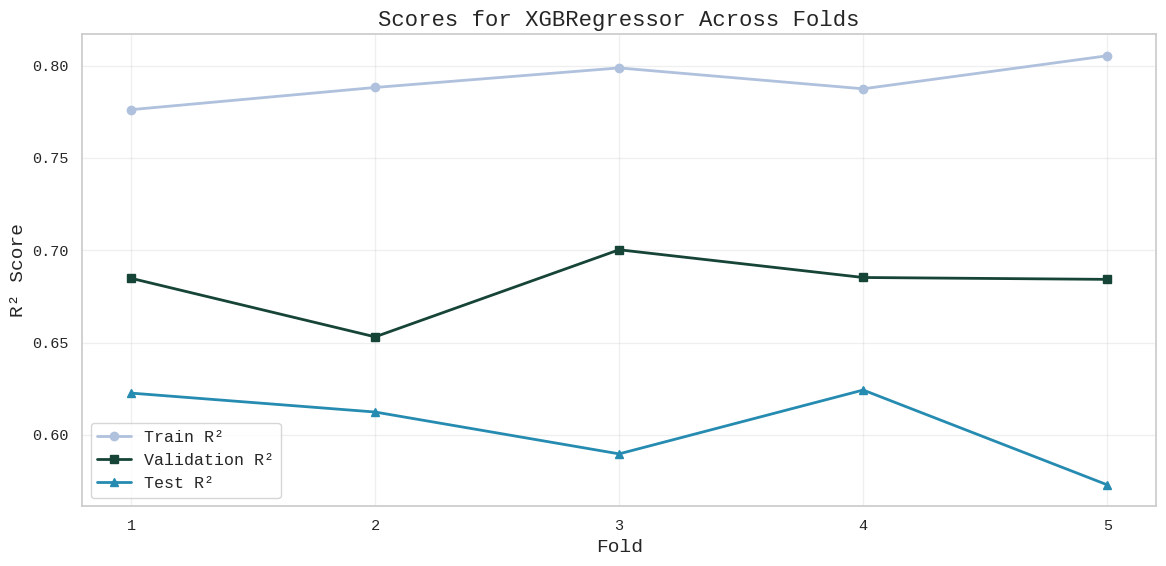







Hyperparameters for Lasso:
Loading model from results/saved_models/Lasso_model_fold_1.pkl...
Loading model from results/saved_models/Lasso_model_fold_2.pkl...
Loading model from results/saved_models/Lasso_model_fold_3.pkl...
Loading model from results/saved_models/Lasso_model_fold_4.pkl...
Loading model from results/saved_models/Lasso_model_fold_5.pkl...
Loaded 5 models for Lasso.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('lasso', Lasso(alpha=0.01))], 'verbose': False, 'lasso': Lasso(alpha=0.01), 'lasso__alpha': 0.01, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': None, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False}
Fold 2 Hyperparameters: {'memory': None, 'steps': [('lasso', Lasso(alpha=0.01))], 'verbose': False, 'lasso': Lasso(alpha=0.01), 'lasso__alpha': 0.01, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter

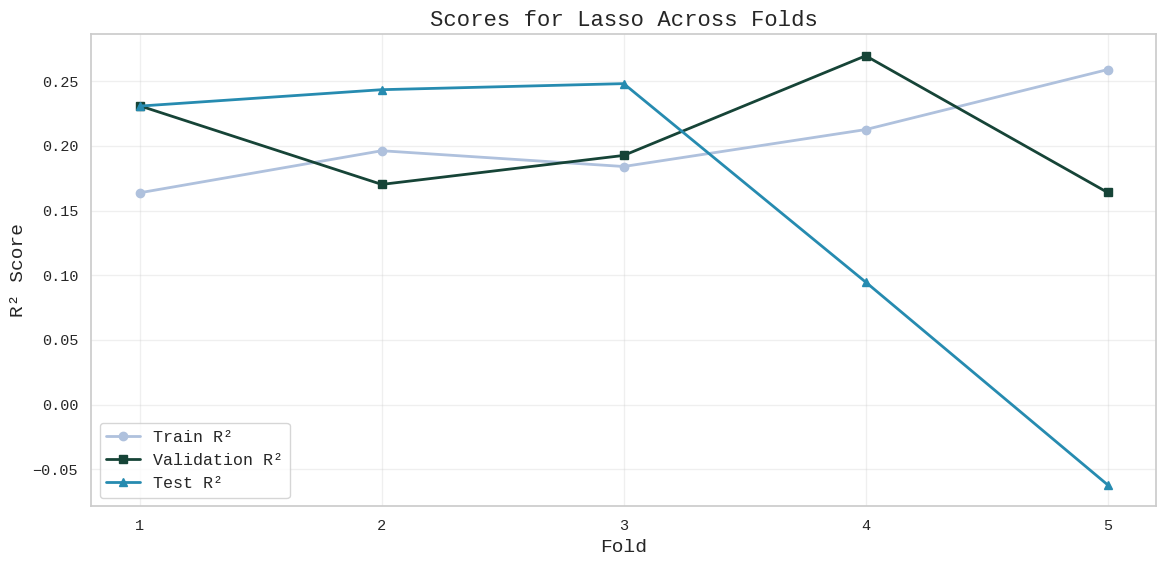







Hyperparameters for Ridge:
Loading model from results/saved_models/Ridge_model_fold_1.pkl...
Loading model from results/saved_models/Ridge_model_fold_2.pkl...
Loading model from results/saved_models/Ridge_model_fold_3.pkl...
Loading model from results/saved_models/Ridge_model_fold_4.pkl...
Loading model from results/saved_models/Ridge_model_fold_5.pkl...
Loaded 5 models for Ridge.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('ridge', Ridge(alpha=1))], 'verbose': False, 'ridge': Ridge(alpha=1), 'ridge__alpha': 1, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.0001}
Fold 2 Hyperparameters: {'memory': None, 'steps': [('ridge', Ridge(alpha=10))], 'verbose': False, 'ridge': Ridge(alpha=10), 'ridge__alpha': 10, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solv

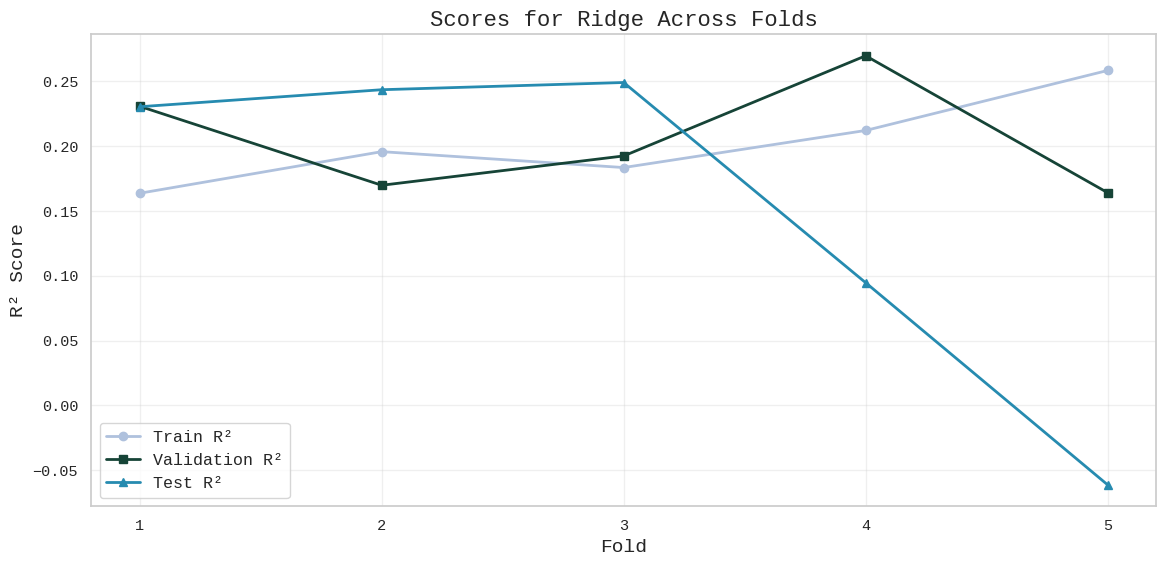







Hyperparameters for ElasticNet:
Loading model from results/saved_models/ElasticNet_model_fold_1.pkl...
Loading model from results/saved_models/ElasticNet_model_fold_2.pkl...
Loading model from results/saved_models/ElasticNet_model_fold_3.pkl...
Loading model from results/saved_models/ElasticNet_model_fold_4.pkl...
Loading model from results/saved_models/ElasticNet_model_fold_5.pkl...
Loaded 5 models for ElasticNet.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('elasticnet', ElasticNet(alpha=0.01, l1_ratio=1, max_iter=10000))], 'verbose': False, 'elasticnet': ElasticNet(alpha=0.01, l1_ratio=1, max_iter=10000), 'elasticnet__alpha': 0.01, 'elasticnet__copy_X': True, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 1, 'elasticnet__max_iter': 10000, 'elasticnet__positive': False, 'elasticnet__precompute': False, 'elasticnet__random_state': None, 'elasticnet__selection': 'cyclic', 'elasticnet__tol': 0.0001, 'elasticnet__warm_start': False}
Fold 2 Hyperparameters: {'memo

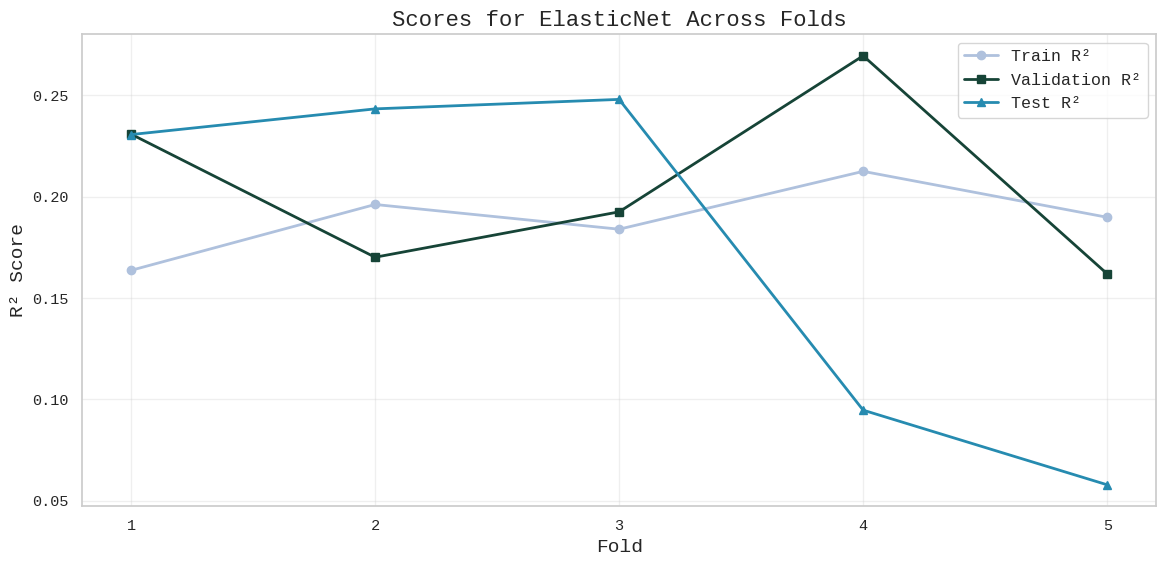







Hyperparameters for RandomForestRegressor:
Loading model from results/saved_models/RandomForestRegressor_model_fold_1.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_2.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_3.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_4.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_5.pkl...
Loaded 5 models for RandomForestRegressor.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('randomforestregressor', RandomForestRegressor(max_depth=30, max_features=10, random_state=42))], 'verbose': False, 'randomforestregressor': RandomForestRegressor(max_depth=30, max_features=10, random_state=42), 'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0.0, 'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 10, 'randomforestre

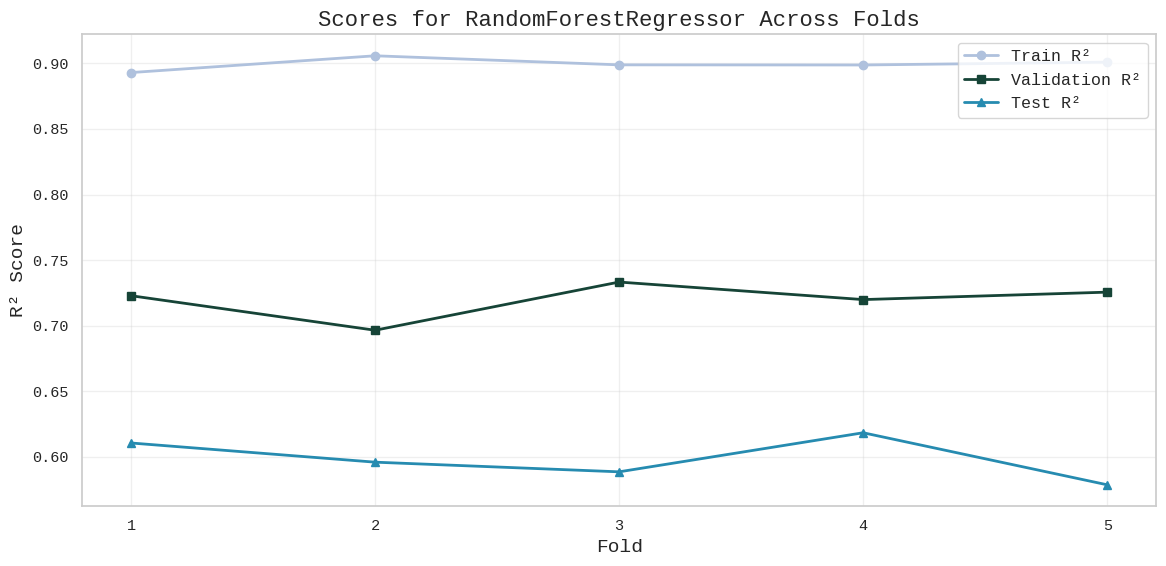







Hyperparameters for SVR:
Loading model from results/saved_models/SVR_model_fold_1.pkl...
Loading model from results/saved_models/SVR_model_fold_2.pkl...
Loading model from results/saved_models/SVR_model_fold_3.pkl...
Loading model from results/saved_models/SVR_model_fold_4.pkl...
Loading model from results/saved_models/SVR_model_fold_5.pkl...
Loaded 5 models for SVR.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('svr', SVR(C=100.0, gamma=0.1))], 'verbose': False, 'svr': SVR(C=100.0, gamma=0.1), 'svr__C': 100.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.1, 'svr__gamma': 0.1, 'svr__kernel': 'rbf', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}
Fold 2 Hyperparameters: {'memory': None, 'steps': [('svr', SVR(C=100.0, gamma=0.1))], 'verbose': False, 'svr': SVR(C=100.0, gamma=0.1), 'svr__C': 100.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.1, 'svr__gamma': 0.1, 'svr__k

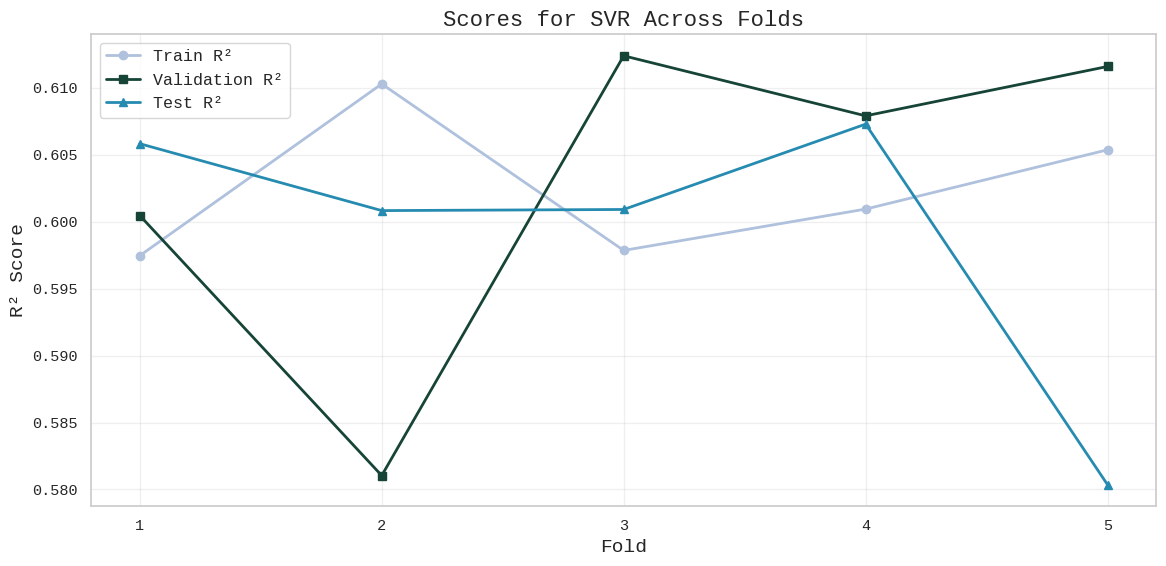







Hyperparameters for KNeighborsRegressor:
Loading model from results/saved_models/KNeighborsRegressor_model_fold_1.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_2.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_3.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_4.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_5.pkl...
Loaded 5 models for KNeighborsRegressor.
Fold 1 Hyperparameters: {'memory': None, 'steps': [('kneighborsregressor', KNeighborsRegressor(n_neighbors=10))], 'verbose': False, 'kneighborsregressor': KNeighborsRegressor(n_neighbors=10), 'kneighborsregressor__algorithm': 'auto', 'kneighborsregressor__leaf_size': 30, 'kneighborsregressor__metric': 'minkowski', 'kneighborsregressor__metric_params': None, 'kneighborsregressor__n_jobs': None, 'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'uniform'}
Fol

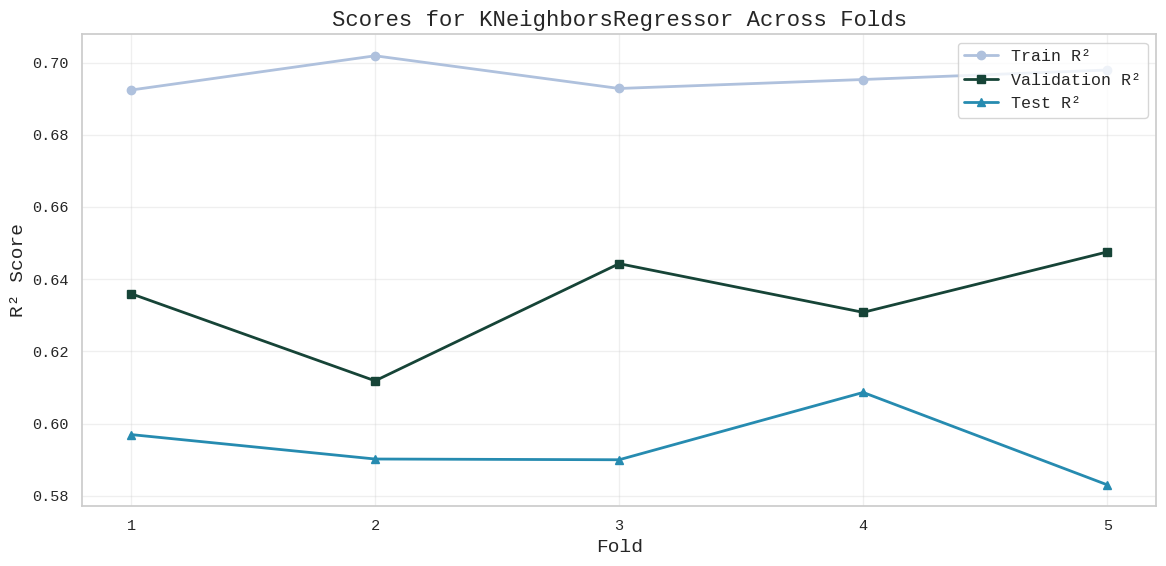

Results are ready for analysis.


In [213]:
from sklearn.model_selection import ParameterGrid
import os

results_pickle_file = "results/model_scores.pkl"
# Check if the pickle file exists
if os.path.exists(results_pickle_file):
    print("Loading results from pickle file...")
    with open(results_pickle_file, "rb") as f:
        saved_data = pickle.load(f)
        all_scores = saved_data["all_scores"]
        mean_scores = saved_data["mean_scores"]
        std_scores = saved_data["std_scores"]
        algo_names = saved_data["algo_names"]

    ML_algo_names = ["XGBRegressor", "Lasso", "Ridge", "ElasticNet", "RandomForestRegressor", "SVR", "KNeighborsRegressor"]

    for ML_algo_name in ML_algo_names:
        print('\n\n\n\n')
        # Store scores
        scores = all_scores[ML_algo_name]
        print(f"\nHyperparameters for {ML_algo_name}:")
        trained_models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=ML_algo_name)
        for i, model in enumerate(trained_models):
            print(f"Fold {i+1} Hyperparameters:", model.get_params())

        print('train_r2:', scores['train_r2'])
        print('validation_r2:', scores['validation_r2'])
        print('test_r2:', scores['test_r2'])



        # Plot scores for the current algorithm
        plot_scores(scores, title=f"Scores for {ML_algo_name} Across Folds")


else:
    print("Pickle file not found. Calculating results...")

    # Initialize results storage
    all_scores = {}

    mean_scores = {
        "train_r2": [], "validation_r2": [], "test_r2": [],
        "train_rmse": [], "validation_rmse": [], "test_rmse": []
    }
    std_scores = {
        "train_r2": [], "validation_r2": [], "test_r2": [],
        "train_rmse": [], "validation_rmse": [], "test_rmse": []
    }

    algo_names = []

    # Iterate through the list of algorithms
    ML_algo_names = ["XGBRegressor", "Lasso", "Ridge", "ElasticNet", "RandomForestRegressor", "SVR", "KNeighborsRegressor"]

    for ML_algo_name in ML_algo_names:
        print('\n\n\n\n')
        print(f"\nEvaluating {ML_algo_name}...")

        # Load trained models for the current algorithm
        trained_models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=ML_algo_name)

        # Print hyperparameters for each fold
        print(f"\nHyperparameters for {ML_algo_name}:")
        for i, model in enumerate(trained_models):
            print(f"Fold {i+1} Hyperparameters:", model.get_params())

        X_1 = X.reset_index(drop=True)
        y_1 = y.reset_index(drop=True)

        # Calculate scores for the current algorithm
        scores = calculate_scores_for_models(
            trained_models, train_indices_split, val_indices_split, test_indices_split, X_1, y_1, cat_features, num_features
        )

        # Store scores
        all_scores[ML_algo_name] = scores


        # Plot scores for the current algorithm
        plot_scores(scores, title=f"Scores for {ML_algo_name} Across Folds")



        # Store mean and std for each dataset split
        algo_names.append(ML_algo_name)
        for split in ["train_r2", "validation_r2", "test_r2", "train_rmse", "validation_rmse", "test_rmse"]:
            mean_scores[split].append(np.mean(scores[split]))
            std_scores[split].append(np.std(scores[split]))

    # Save the results to a pickle file
    print("Saving results to pickle file...")
    with open(results_pickle_file, "wb") as f:
        pickle.dump({
            "all_scores": all_scores,
            "mean_scores": mean_scores,
            "std_scores": std_scores,
            "algo_names": algo_names
        }, f)

    print("Results saved successfully.")

# Use the loaded or calculated results
print("Results are ready for analysis.")


In [214]:


print("Saving results to pickle file...")
with open(results_pickle_file, "wb") as f:
        pickle.dump({
            "all_scores": all_scores,
            "mean_scores": mean_scores,
            "std_scores": std_scores,
            "algo_names": algo_names
        }, f)

print("Results saved successfully.")

Saving results to pickle file...
Results saved successfully.


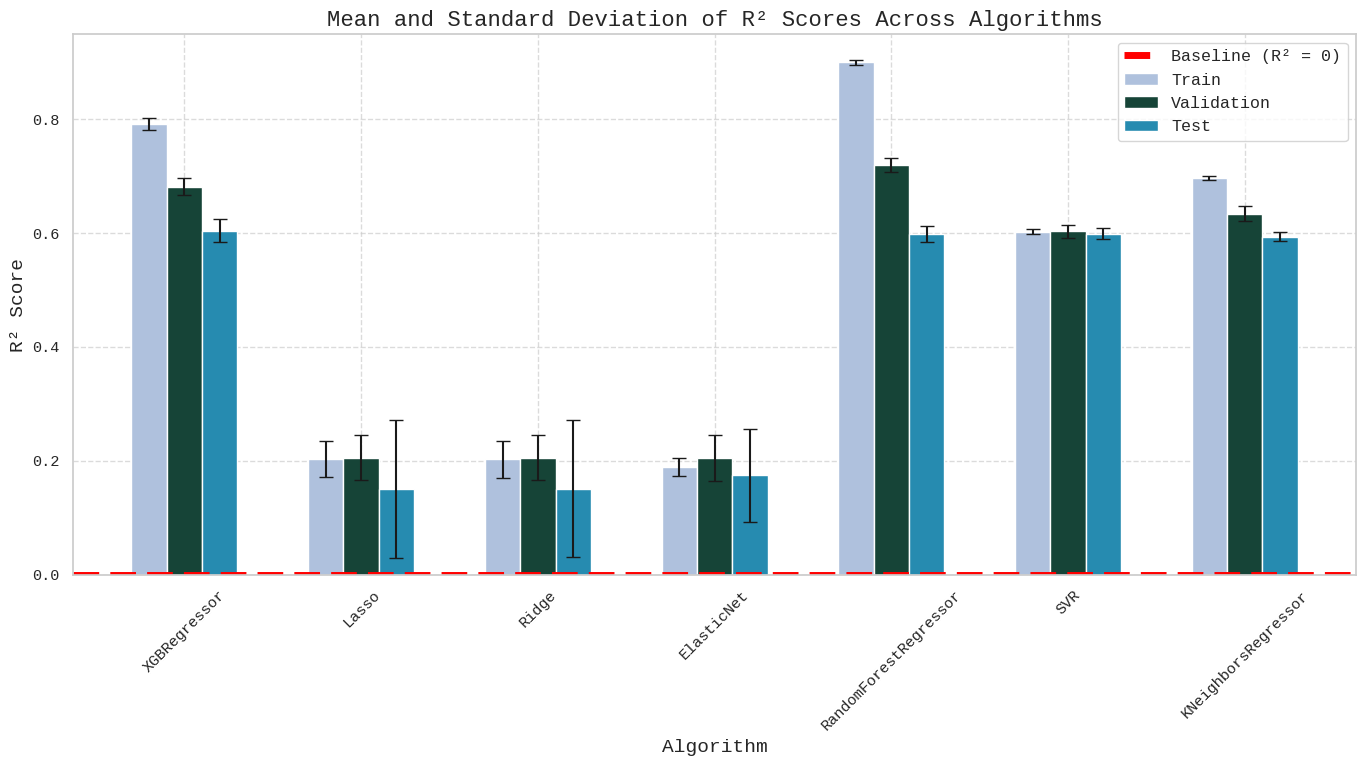

In [223]:
# Plot mean and std deviation for each algorithm
def plot_mean_std(mean_scores, std_scores, algo_names):
    """
    Plot mean and standard deviation of R² scores across algorithms, with a baseline at R²=0.

    Parameters:
    - mean_scores: Dictionary with mean scores for train, validation, and test sets.
    - std_scores: Dictionary with standard deviation of scores for train, validation, and test sets.
    - algo_names: List of algorithm names.
    """
    x = np.arange(len(algo_names))  # Algorithm indices
    width = 0.2  # Bar width
    colors = ['#afc1dd', '#164437', '#268bb0']

    # Plot for train, validation, and test
    plt.figure(figsize=(14, 8))

    # Add bars for train, validation, and test
    plt.bar(x - width, mean_scores["train_r2"], width, yerr=std_scores["train_r2"], label="Train", color=colors[0], capsize=5)
    plt.bar(x, mean_scores["validation_r2"], width, yerr=std_scores["validation_r2"], label="Validation", color=colors[1], capsize=5)
    plt.bar(x + width, mean_scores["test_r2"], width, yerr=std_scores["test_r2"], label="Test", color=colors[2], capsize=5)

    # Add baseline (R² = 0)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=5, label="Baseline (R² = 0)")

    # Add title, labels, and legend
    plt.title("Mean and Standard Deviation of R² Scores Across Algorithms", fontsize=16)
    plt.xlabel("Algorithm", fontsize=14)
    plt.ylabel("R² Score", fontsize=14)
    plt.xticks(x, algo_names, rotation=45)
    plt.legend(fontsize=12)

    # Grid and layout adjustments
    plt.grid(axis='y', alpha=0.7, linestyle='--')  # Adjust transparency for horizontal grid lines
    plt.grid(axis='x', alpha=0.7, linestyle='--')  # Adjust transparency for vertical grid lines
    plt.tight_layout()

    # Save figure
    plt.savefig("figures/Mean and Standard Deviation of R² Scores Across Algorithms.png", transparent=True, bbox_inches='tight', dpi=300)

    # Show plot
    plt.show()

# Call the plot function
plot_mean_std(mean_scores, std_scores, algo_names)


Best algorithms are Random Forest Regressor, XGBoost Regressor, and KNNeighbors Regressor.

baseline

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Compute the mean of y_train
y_mean = np.mean(y)
y_baseline=y.copy()

# Predict the mean for all y_test samples (baseline prediction)
baseline_pred = np.full_like(y_baseline, y_mean)

# Calculate baseline R² and RMSE
baseline_r2 = r2_score(y_baseline, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_baseline, baseline_pred))

print("Baseline R² Score based on all y:", baseline_r2)
print("Baseline RMSE based on all y:", baseline_rmse)


Baseline R² Score based on all y: 0.0
Baseline RMSE based on all y: 392.7755340281269


#Feature Importance

##Permutation Importance

In [ ]:
print(mean_scores["test_r2"])

[0.604332176518392, 0.1509717817464513, 0.15133187110086063, 0.1749305573492118, 0.5985147226648648, 0.5990450207198715, 0.5936800199059649]


In [ ]:
print(all_scores['RandomForestRegressor']['test_r2'][0])

0.6106489765254035



Calculating permutation importance for RandomForestRegressor...
Loading model from results/saved_models/RandomForestRegressor_model_fold_1.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_2.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_3.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_4.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_5.pkl...
Loaded 5 models for RandomForestRegressor.
Evaluating model for Fold 1...
Shuffling feature: sum floor area...
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder comp

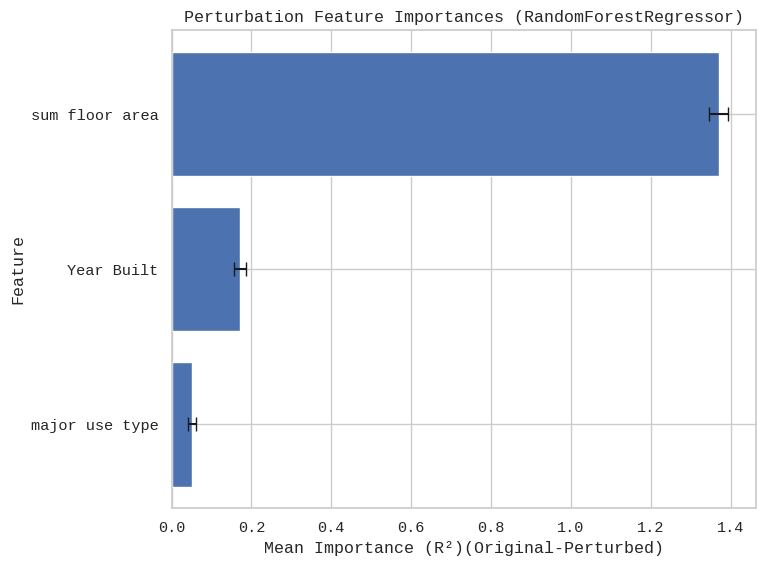


Calculating permutation importance for XGBRegressor...
Loading model from results/saved_models/XGBRegressor_model_fold_1.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_2.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_3.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_4.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_5.pkl...
Loaded 5 models for XGBRegressor.
Evaluating model for Fold 1...
Shuffling feature: sum floor area...
preprocess with train encoder
preprocess with train encoder completed


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:30:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
Shuffling feature: Year Built...
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encod

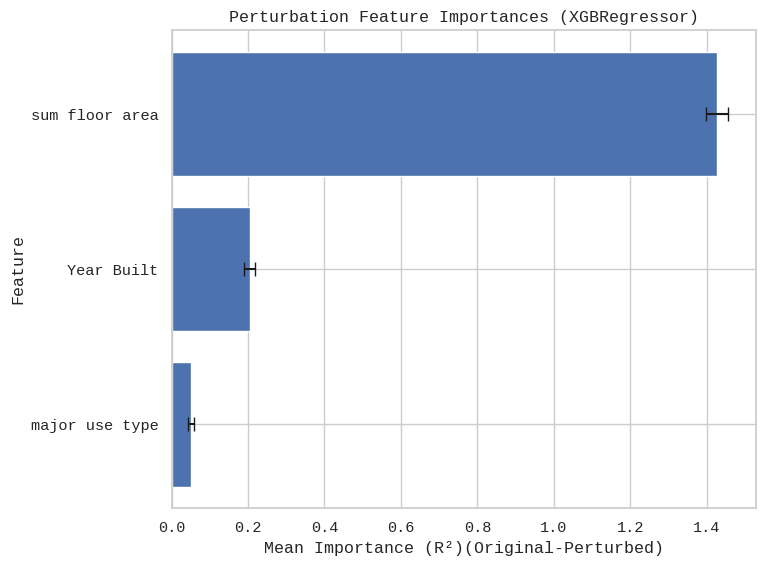


Calculating permutation importance for KNeighborsRegressor...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_1.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_2.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_3.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_4.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_5.pkl...
Loaded 5 models for KNeighborsRegressor.
Evaluating model for Fold 1...
Shuffling feature: sum floor area...
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preprocess with train encoder
preprocess with train encoder completed
preproce

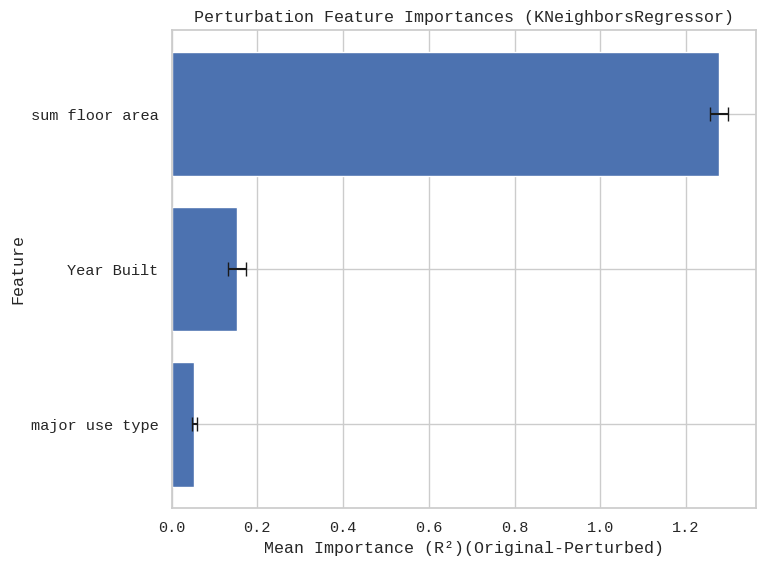

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

def calculate_permutation_importance_raw(
    model, X_train, y_train, X_val, y_val, X_test, y_test, pipeline, feature_names,
    cat_features, num_features, nr_runs=10, baseline_score=None
):
    """
    Calculate permutation importance for raw features before preprocessing.

    Parameters:
    - model: Trained model.
    - X_train, X_val, X_test: Raw feature DataFrames for train, validation, and test sets.
    - y_train, y_val, y_test: Ground truth labels for train, validation, and test sets.
    - pipeline: Preprocessing pipeline (including one-hot encoding, scaling, etc.).
    - feature_names: List of raw feature names (before preprocessing).
    - cat_features: List of categorical features.
    - num_features: List of numerical features.
    - nr_runs: Number of permutation runs.
    - baseline_score: Precomputed baseline R² score.

    Returns:
    - DataFrame containing feature names and their permutation importances.
    """
    np.random.seed(42)
    importances = np.zeros(len(feature_names))

    for i, feature in enumerate(feature_names):
        print(f"Shuffling feature: {feature}...")
        shuffled_scores = []

        for _ in range(nr_runs):
            # Shuffle the raw feature
            X_test_shuffled = X_test.copy()
            X_test_shuffled[feature] = np.random.permutation(X_test[feature].values)

            # Preprocess the shuffled dataset
            _, _, X_test_transformed = preprocess_with_train_encoder(
                pipeline, X_train, X_val, X_test_shuffled, cat_features, num_features
            )

            # Evaluate the model on shuffled data
            score = model.score(X_test_transformed, y_test)
            shuffled_scores.append(score)

        # Calculate the mean drop in performance
        importances[i] = baseline_score - np.mean(shuffled_scores)

    # Create DataFrame with the results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df



best_models = [
    "RandomForestRegressor",
    "XGBRegressor",
    "KNeighborsRegressor"
]

for algo_name in best_models:
    print(f"\nCalculating permutation importance for {algo_name}...")

    models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=algo_name)

    # Initialize list for importances
    all_folds_importances = []

    for i, model in enumerate(models):
        print(f"Evaluating model for Fold {i+1}...")

        # Get indices for the current fold
        train_indices = train_indices_split[i]
        val_indices = val_indices_split[i]
        test_indices = test_indices_split[i]

        # Get corresponding data
        X_train, y_train = X.loc[train_indices], y.loc[train_indices]
        X_val, y_val = X.loc[val_indices], y.loc[val_indices]
        X_test, y_test = X.loc[test_indices], y.loc[test_indices]

        # Drop unwanted columns
        for df in [X_train, X_test, X_val]:
            if 'NYC Building Identification Number (BIN)' in df.columns:
                df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)

        # Create pipeline
        pipeline = create_pipeline(cat_features, num_features, model)

        # Get baseline score for this fold
        baseline_score = all_scores[algo_name]['test_r2'][i]

        # Calculate permutation importance for this fold
        fold_importances = calculate_permutation_importance_raw(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            X_test=X_test,
            y_test=y_test,
            pipeline=pipeline,
            feature_names=X_test.columns,
            cat_features=cat_features,
            num_features=num_features,

            baseline_score=baseline_score
        )

        # Extract only the numeric 'Importance' column and append
        all_folds_importances.append(fold_importances['Importance'].values)

    # Convert to a NumPy array
    all_folds_importances = np.array(all_folds_importances)

    # Calculate mean and std for feature importances across folds
    mean_importances = np.mean(all_folds_importances, axis=0)
    std_importances = np.std(all_folds_importances, axis=0)

    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        "Feature": X_test.columns,
        "Mean Importance": mean_importances,
        "Std Importance": std_importances
    }).sort_values(by="Mean Importance", ascending=False)

    # Plot all features
    plt.figure(figsize=(8, 6))
    plt.barh(
        importance_df['Feature'],
        importance_df['Mean Importance'],
        xerr=importance_df['Std Importance'],
        align='center',
        capsize=5
    )
    plt.xlabel('Mean Importance (R²)(Original-Perturbed)')
    plt.ylabel('Feature')
    plt.title(f'Perturbation Feature Importances ({algo_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"Perturbation Feature Importances ({algo_name}).png", transparent=True, bbox_inches='tight', dpi=300)
    plt.show()



Calculating permutation importance for RandomForestRegressor...
Loading model from results/saved_models/RandomForestRegressor_model_fold_1.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_2.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_3.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_4.pkl...
Loading model from results/saved_models/RandomForestRegressor_model_fold_5.pkl...
Loaded 5 models for RandomForestRegressor.
progress[algo_name] [                                              Feature    Importance
0                                      sum floor area  1.387940e+00
1                                          Year Built  5.706760e-02
8                         major use type_Data Center   5.314921e-02
41                major use type_Supermarket/Grocery   9.971074e-03
37              major use type_Self-Storage Facility   8.789509e-03
17                              major use type_Hotel 

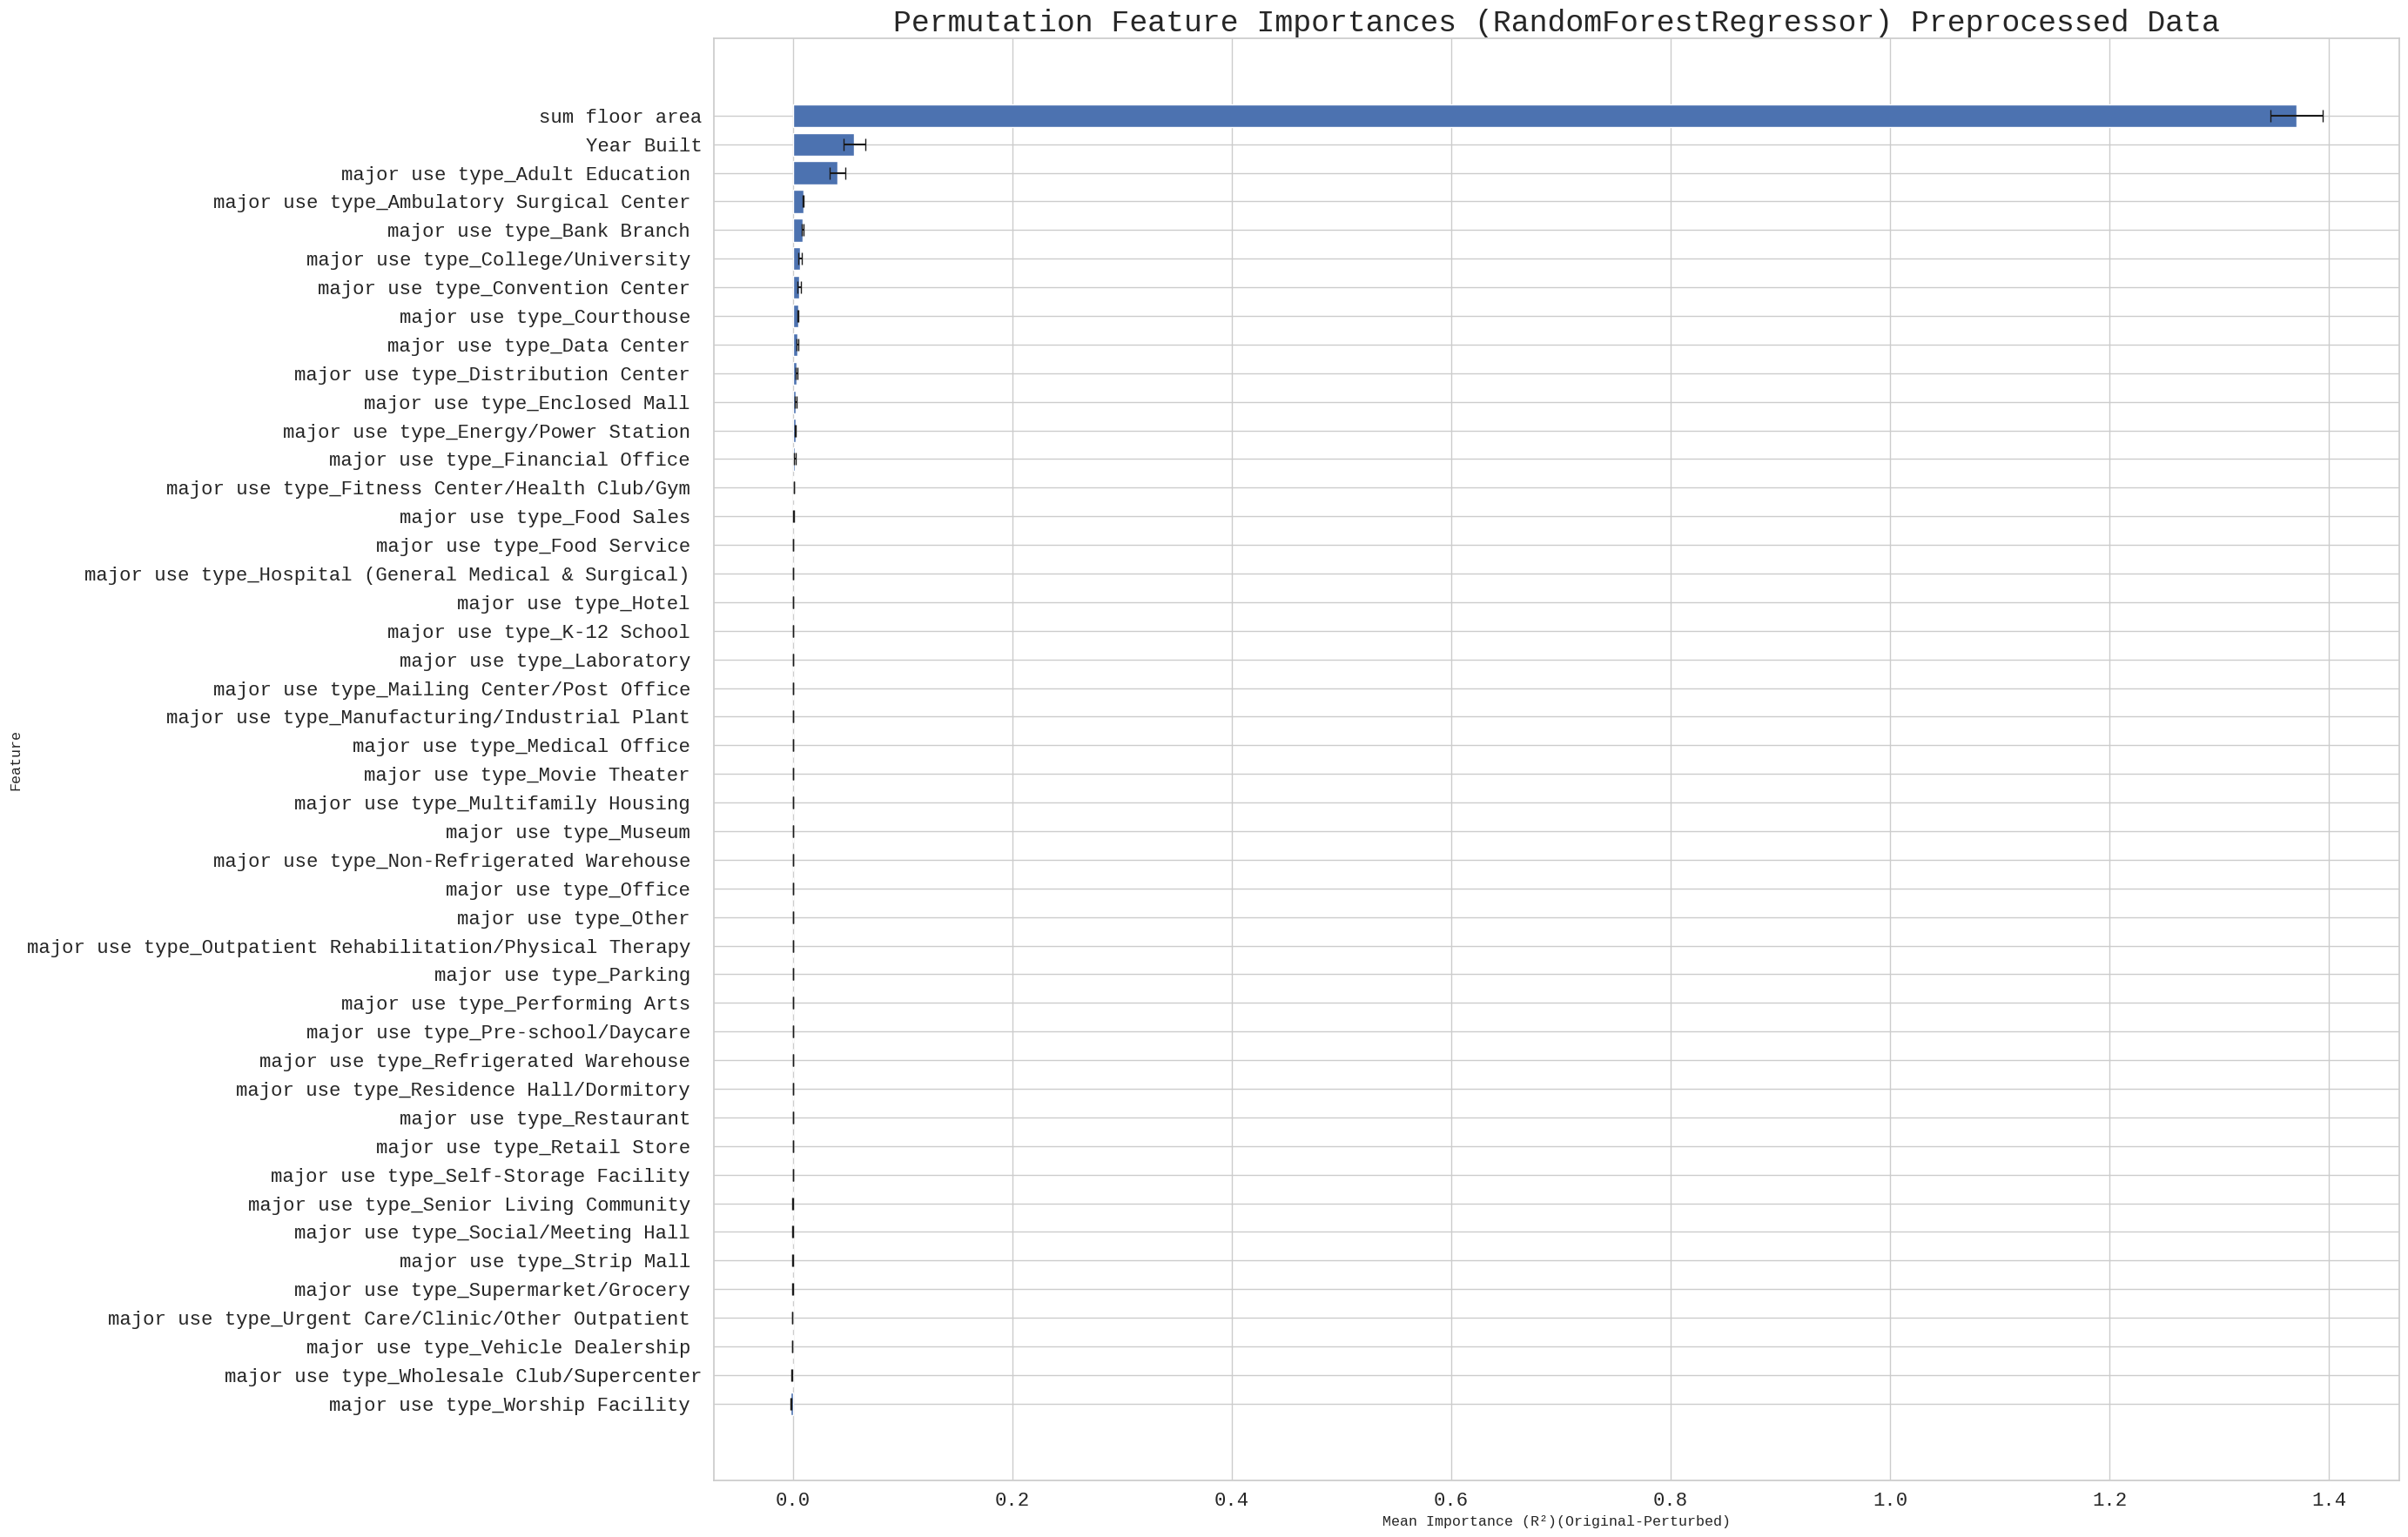

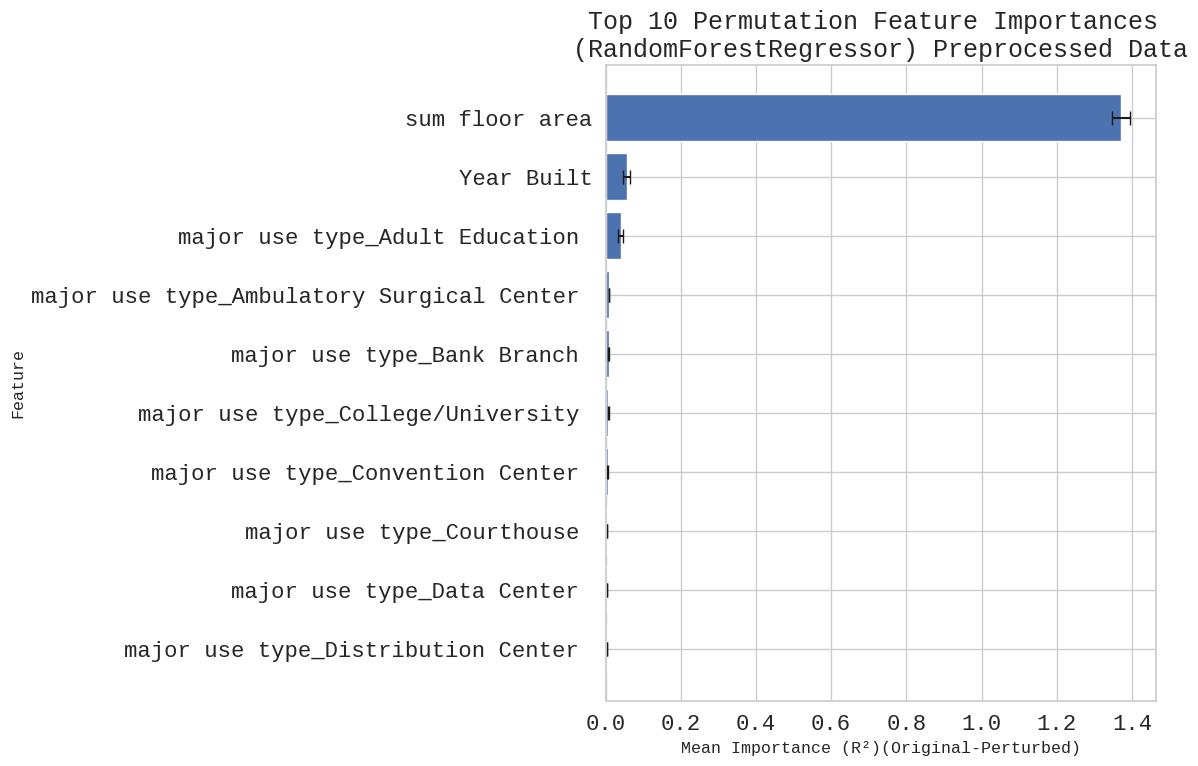


Calculating permutation importance for XGBRegressor...
Loading model from results/saved_models/XGBRegressor_model_fold_1.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_2.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_3.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_4.pkl...
Loading model from results/saved_models/XGBRegressor_model_fold_5.pkl...
Loaded 5 models for XGBRegressor.
progress[algo_name] [                                              Feature  Importance
0                                      sum floor area    1.430982
8                         major use type_Data Center     0.104570
1                                          Year Built    0.048252
41                major use type_Supermarket/Grocery     0.015743
37              major use type_Self-Storage Facility     0.012082
17                              major use type_Hotel     0.008887
26         major use type_Non-Refrigerated Warehouse     0.004

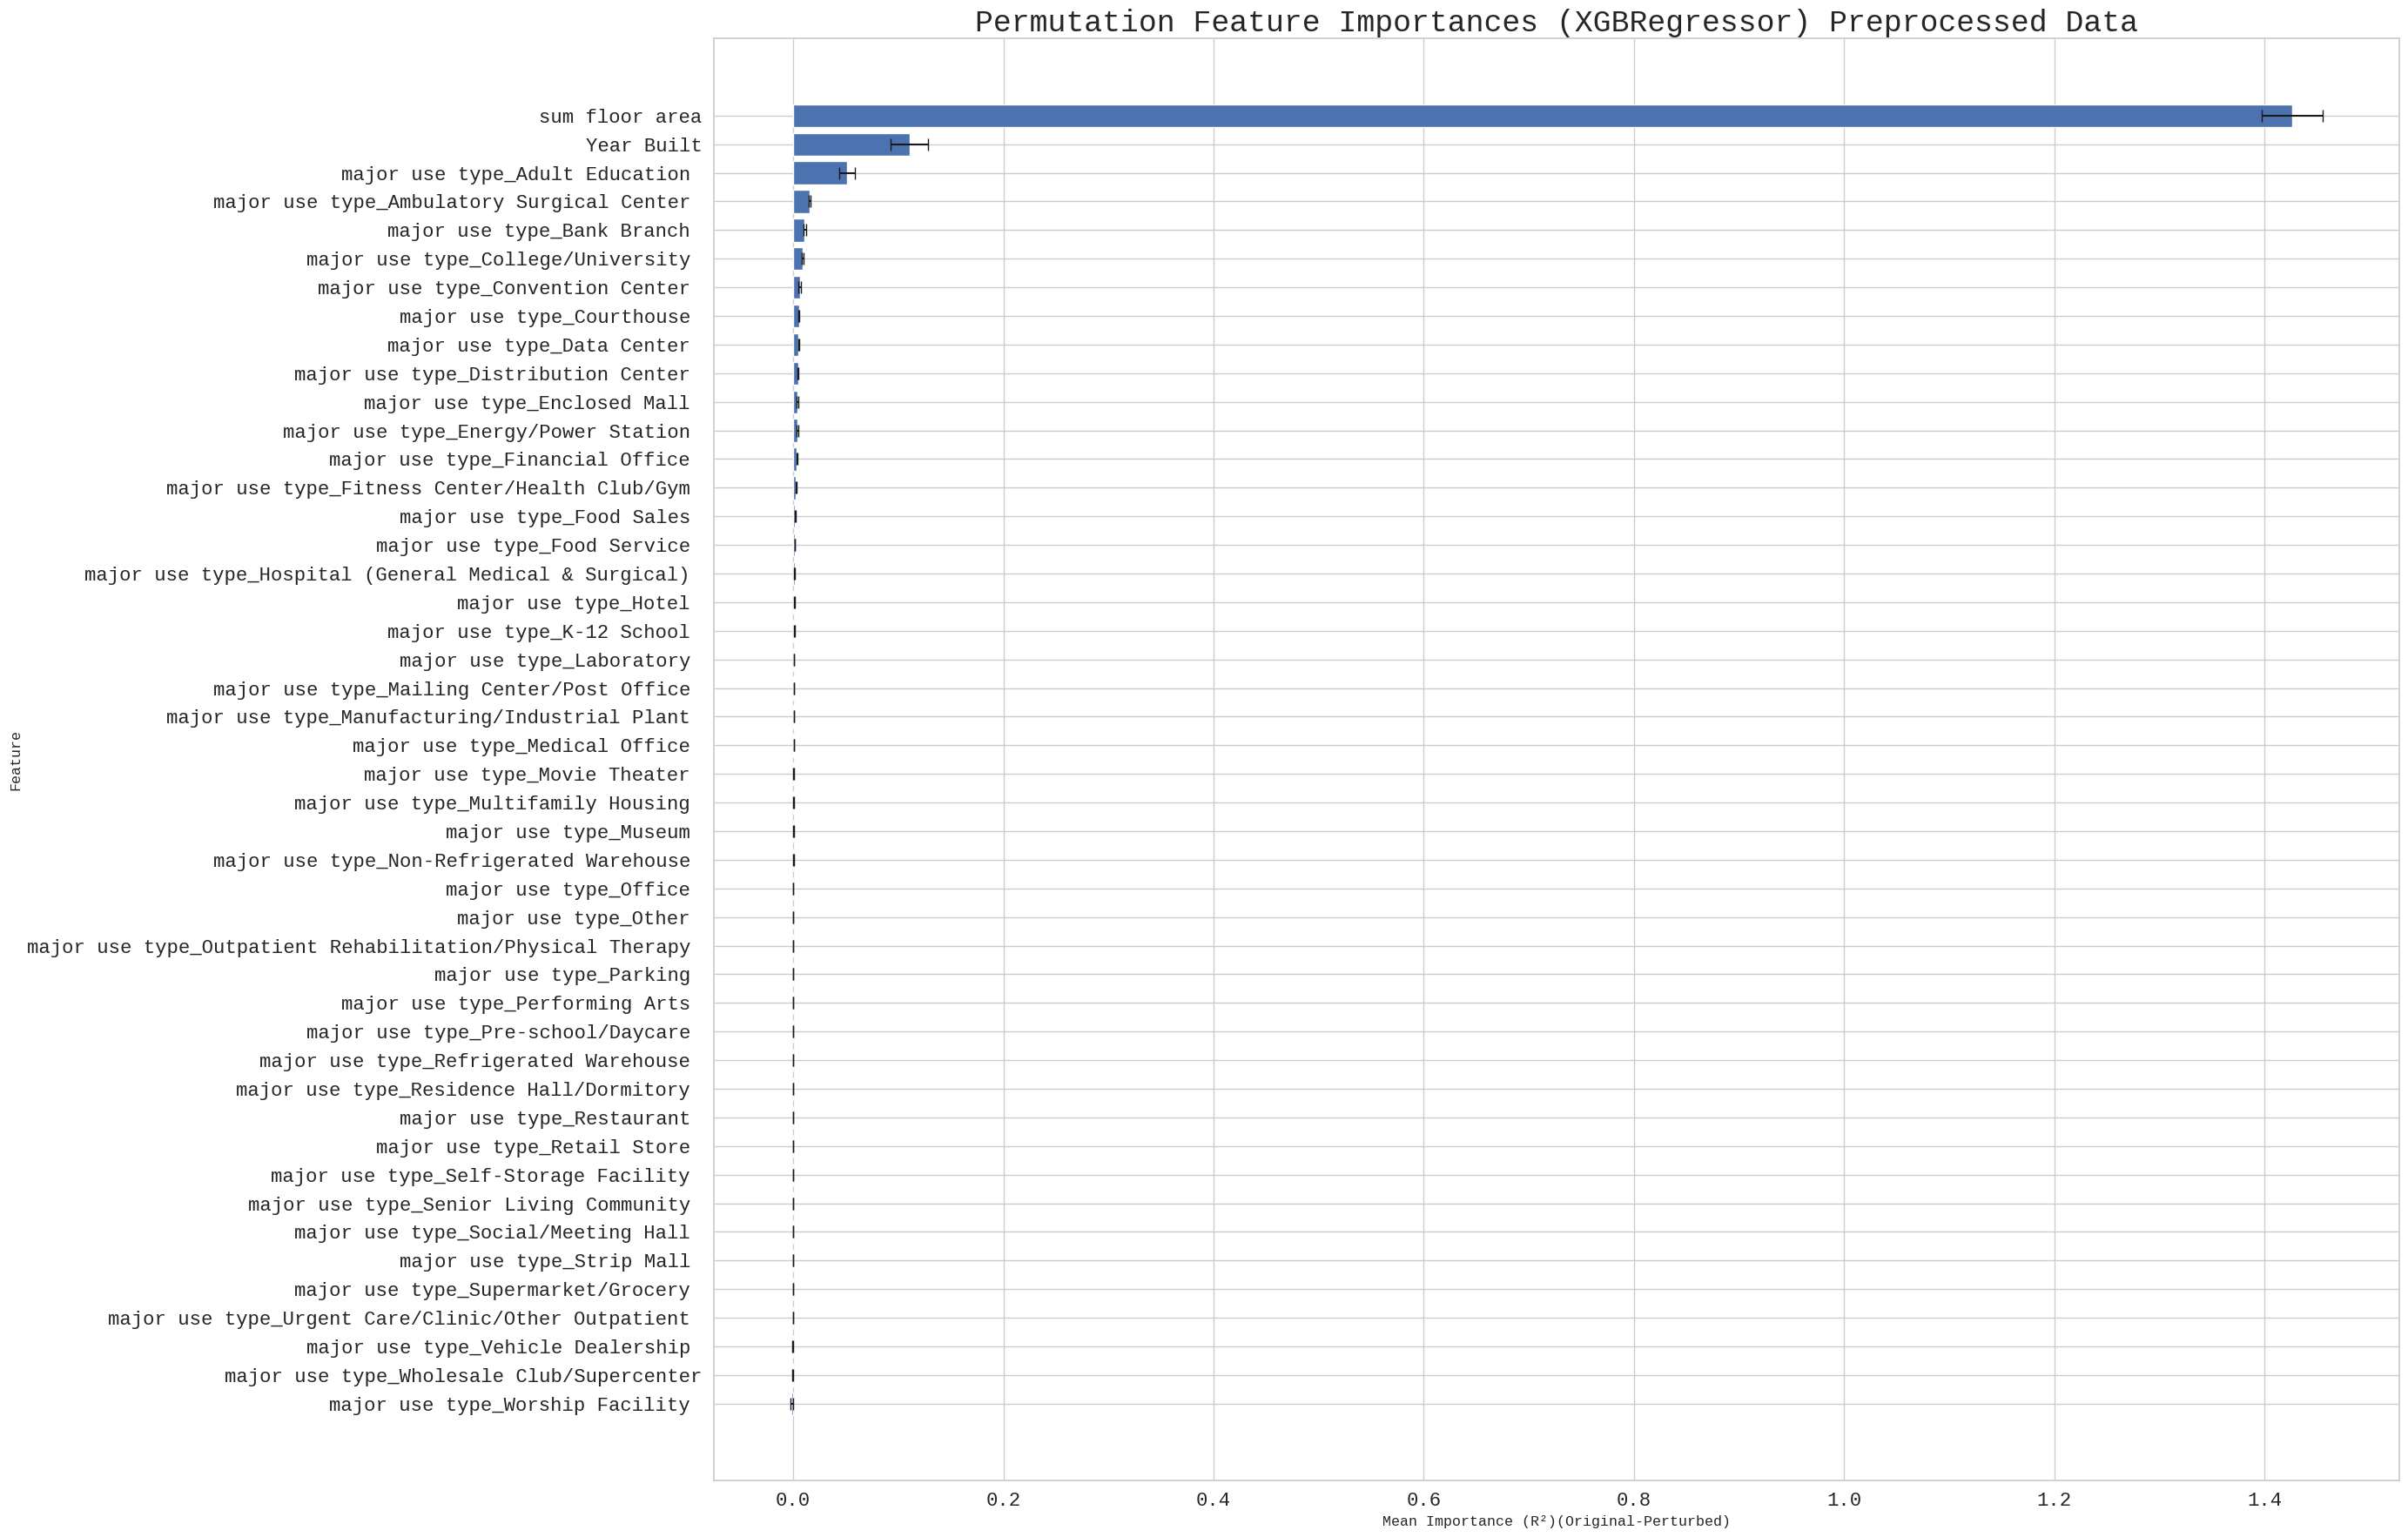

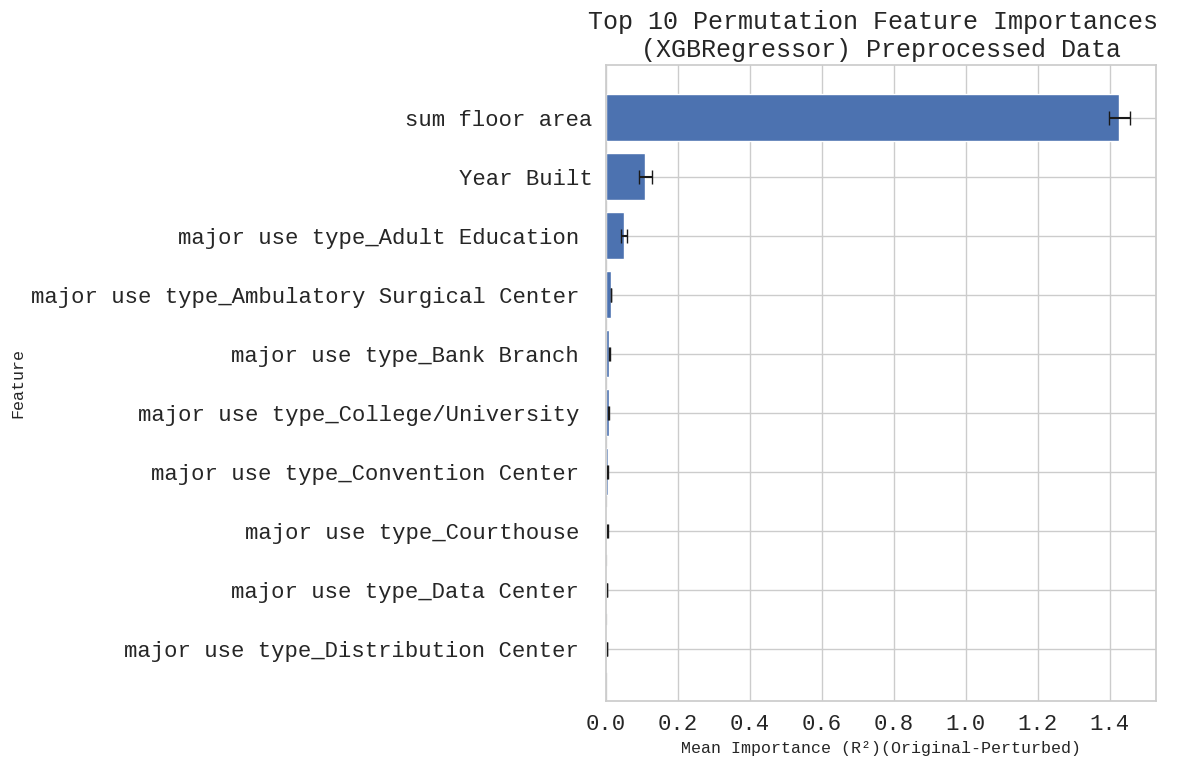


Calculating permutation importance for KNeighborsRegressor...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_1.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_2.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_3.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_4.pkl...
Loading model from results/saved_models/KNeighborsRegressor_model_fold_5.pkl...
Loaded 5 models for KNeighborsRegressor.
progress[algo_name] [                                              Feature  Importance
0                                      sum floor area    1.263554
1                                          Year Built    0.055571
24                major use type_Multifamily Housing     0.022645
37              major use type_Self-Storage Facility     0.007751
41                major use type_Supermarket/Grocery     0.007378
18                        major use type_K-12 School     0.005022
27           

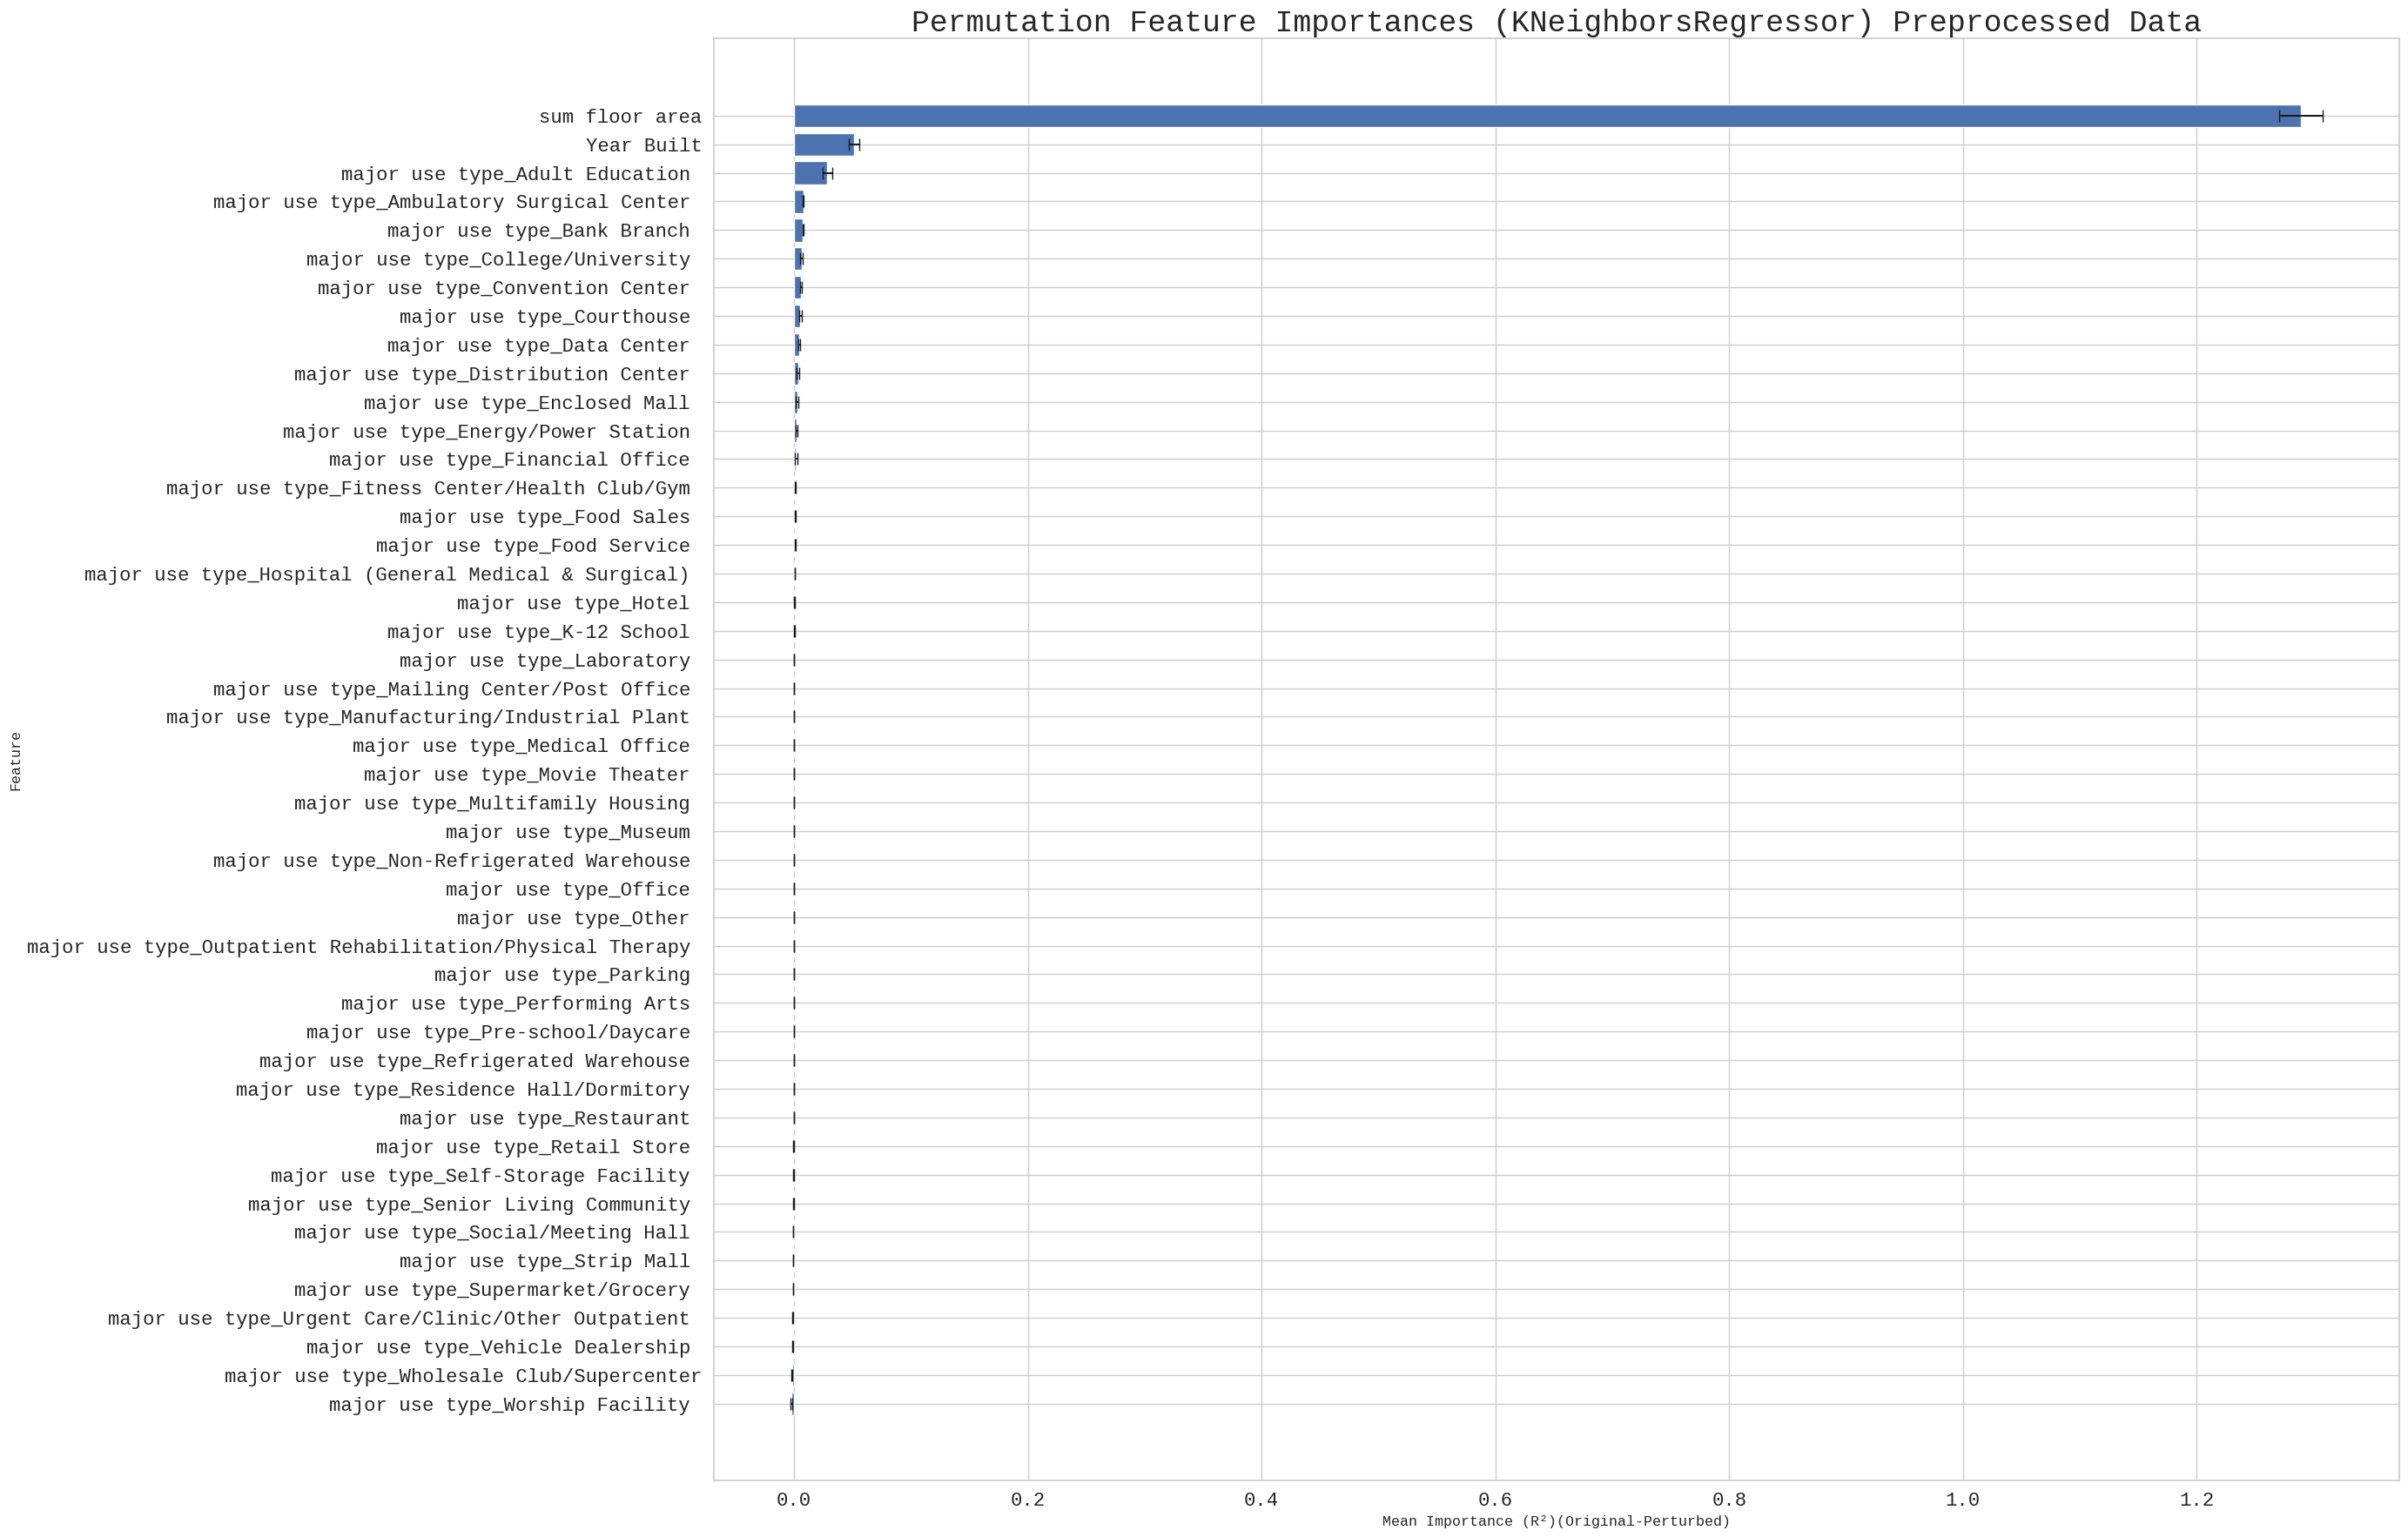

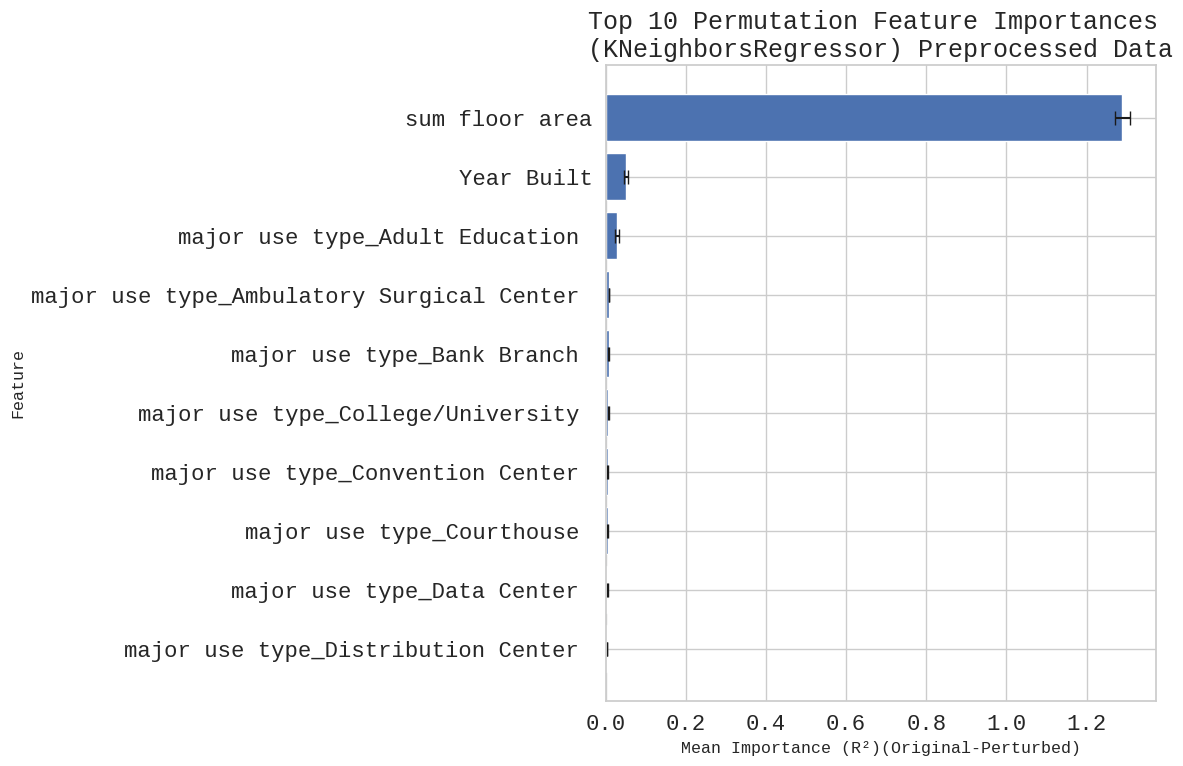

In [ ]:
def save_progress(data, filename):
    """Save progress to a pickle file."""
    with open(filename, "wb") as f:
        pickle.dump(data, f)

def load_progress(filename):
    """Load progress from a pickle file if it exists."""
    if os.path.exists(filename):
      with open(filename, "rb") as f:
        progress=pickle.load(f)
        return progress
    else:
      return {}

def calculate_permutation_importance_preprocessed(
    model, X_test_transformed, y_test, feature_names, nr_runs=10, baseline_score=None
):
    """
    Calculate permutation importance for preprocessed features.

    Parameters:
    - model: Trained model.
    - X_test_transformed: Preprocessed feature matrix for the test set (should be a NumPy array).
    - y_test: Ground truth labels for the test set.
    - feature_names: List of preprocessed feature names.
    - nr_runs: Number of permutation runs.
    - baseline_score: Precomputed baseline R² score.

    Returns:
    - DataFrame containing feature names and their permutation importances.
    """
    np.random.seed(42)

    # Ensure X_test_transformed is a NumPy array
    if not isinstance(X_test_transformed, np.ndarray):
        X_test_transformed = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed.values

    importances = np.zeros(len(feature_names))

    for i, feature in enumerate(feature_names):
        print(f"Shuffling preprocessed feature: {feature}...")
        shuffled_scores = []

        for _ in range(nr_runs):
            # Shuffle the preprocessed feature
            X_test_shuffled = X_test_transformed.copy()

            X_test_shuffled[:, i] = np.random.permutation(X_test_transformed[:, i])
            X_test_transformed_df = pd.DataFrame(
                        X_test_shuffled,
                        columns=feature_names
                    )
            # Evaluate the model on shuffled data
            score = r2_score(y_test, model.predict(X_test_transformed_df))
            shuffled_scores.append(score)

        # Calculate the mean drop in performance
        importances[i] = baseline_score - np.mean(shuffled_scores)

    # Create DataFrame with the results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    return importance_df

# Initialize progress file
progress_file = "results/permutation_importance_progress_processed.pkl"
progress = load_progress(progress_file)
featurenames_file = "results/featue_names_processed.pkl"

best_models = [
    "RandomForestRegressor",
    "XGBRegressor",
    "KNeighborsRegressor"
]

for algo_name in best_models:

    print(f"\nCalculating permutation importance for {algo_name}...")

    models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=algo_name)


    if algo_name not in progress:
        progress[algo_name] = []  # Initialize progress for this algorithm

    if progress[algo_name] != []:
        for i, model in enumerate(models):
              feature_names = load_progress(featurenames_file)

    elif progress[algo_name] == []:
        for i, model in enumerate(models):
            print('progress',progress)

            if i < len(progress[algo_name]):
                print(f"Skipping Fold {i+1} as it is already processed.")
                continue

            print(f"Evaluating model for Fold {i+1}...")

            # Data preparation
            train_indices = train_indices_split[i]
            val_indices = val_indices_split[i]
            test_indices = test_indices_split[i]

            X_train, y_train = X.loc[train_indices], y.loc[train_indices]
            X_val, y_val = X.loc[val_indices], y.loc[val_indices]
            X_test, y_test = X.loc[test_indices], y.loc[test_indices]

            # Drop unwanted columns
            for df in [X_train, X_val, X_test]:
                if 'NYC Building Identification Number (BIN)' in df.columns:
                    df.drop(columns=['NYC Building Identification Number (BIN)'], inplace=True)

            # Preprocessing
            model_actual = model.named_steps[algo_name.lower()]
            pipeline = create_pipeline(cat_features, num_features, model_actual)
            preprocessor = pipeline.named_steps["columntransformer"]

            # Transform data
            X_train_transformed, X_val_transformed, X_test_transformed = preprocess_with_train_encoder(
                pipeline, X_train, X_val, X_test, cat_features, num_features
            )

            # Ensure feature names are correctly derived
            feature_names = X_train_transformed.columns
            print(feature_names)

            # Get baseline score
            baseline_score = all_scores[algo_name]['test_r2'][i]

            # Permutation importance
            fold_importances = calculate_permutation_importance_preprocessed(
                model=model_actual,
                X_test_transformed=X_test_transformed,
                y_test=y_test,
                feature_names=feature_names,
                nr_runs=10,
                baseline_score=baseline_score
            )

            # Append results for this fold
            progress[algo_name].append((fold_importances))
            save_progress(progress, progress_file)  # Save progress
            save_progress(feature_names, featurenames_file)

    print('progress[algo_name]',progress[algo_name])
    print('fold_importances',fold_importances)
    print('feature_names',feature_names)
    # Post-processing

    all_folds_importances = [df["Importance"].values for df in progress[algo_name]]
    all_folds_importances = np.array(all_folds_importances)
    mean_importances = np.mean(all_folds_importances, axis=0)
    std_importances = np.std(all_folds_importances, axis=0)

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean Importance": mean_importances,
        "Std Importance": std_importances
    }).sort_values(by="Mean Importance", ascending=False)

    # Plot
    plt.figure(figsize=(28, 18))
    plt.barh(
        importance_df['Feature'],
        importance_df['Mean Importance'],
        xerr=importance_df['Std Importance'],
        align='center',
        capsize=5
    )
    plt.xlabel('Mean Importance (R²)(Original-Perturbed)')
    plt.ylabel('Feature')
    plt.title(f'Permutation Feature Importances ({algo_name}) Preprocessed Data', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"figures/Permutation Feature Importances ({algo_name}) Preprocessed Data.png", transparent=True, bbox_inches='tight', dpi=300)
    plt.show()

    # Filter to the top 10 features
    top_10_importance_df = importance_df.head(10)

    # Plot
    plt.figure(figsize=(12, 8))  # Adjust the size for a smaller number of features
    plt.barh(
        top_10_importance_df['Feature'],
        top_10_importance_df['Mean Importance'],
        xerr=top_10_importance_df['Std Importance'],
        align='center',
        capsize=5
    )
    plt.xlabel('Mean Importance (R²)(Original-Perturbed)')
    plt.ylabel('Feature')
    plt.title(f'Top 10 Permutation Feature Importances \n({algo_name}) Preprocessed Data', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"figures/Top 10 Permutation Feature Importances ({algo_name}) Preprocessed Data.png", transparent=True, bbox_inches='tight', dpi=300)
    plt.show()



##SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initialize SHAP visualizations
shap.initjs()

best_models = [
    "XGBRegressor",
    "RandomForestRegressor",
]

def calculate_global_importance_xgboost(model, feature_names):
    """
    Calculate all five feature importance metrics for XGBoost with adjusted mapping.

    Parameters:
    - model: Trained XGBoost model.
    - feature_names: List of preprocessed feature names.

    Returns:
    - DataFrame with all five importance metrics.
    """
    print("Calculating global feature importance for XGBoost...")
    metrics = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    booster = model.get_booster()

    # Get raw importance values for each metric
    importance_data = {metric: booster.get_score(importance_type=metric) for metric in metrics}

    # Strip prefixes ("num__" or "cat__") from feature names
    stripped_feature_names = [name.split('__')[-1] for name in feature_names]

    # Map stripped names to the original preprocessed feature names
    stripped_to_preprocessed_mapping = {stripped: preprocessed for stripped, preprocessed in zip(stripped_feature_names, feature_names)}

    # Replace stripped names with preprocessed names in importance_data
    mapped_importance_data = {
        metric: {stripped_to_preprocessed_mapping.get(k, k): v for k, v in importance_data[metric].items()}
        for metric in metrics
    }

    # Create a DataFrame for importance values
    importance_df = pd.DataFrame({'Feature': feature_names})
    for metric in metrics:
        # Add metric values to the DataFrame
        importance_df[metric] = importance_df['Feature'].map(mapped_importance_data[metric]).fillna(0)

    # Sort by gain (default metric)
    importance_df.sort_values(by='gain', ascending=False, inplace=True)

    print("XGBoost global feature importance calculated.")
    return importance_df


def calculate_global_importance_randomforest(model, X_test_transformed, feature_names):
    """
    Calculate Gini importance for Random Forest.

    Parameters:
    - model: Trained Random Forest model.
    - X_test_transformed: Transformed test dataset (should be a NumPy array or DataFrame).
    - feature_names: List of feature names.

    Returns:
    - DataFrame with Gini importance.
    """
    print("Calculating global feature importance for Random Forest...")

    # Ensure X_test_transformed is a DataFrame with the correct feature names
    if not isinstance(X_test_transformed, pd.DataFrame):
        X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

    # Check that the feature names match
    if list(model.feature_names_in_) != list(X_test_transformed.columns):
        print('Feature names in the model',model.feature_names_in_)
        print('Feature names in the test data',X_test_transformed.columns)
        raise ValueError("Feature names in the model do not match those in the test data.")

    # Extract Gini importance
    importance = model.feature_importances_

    # Create a DataFrame for the feature importance
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    print("Random Forest global feature importance calculated.")
    return importance_df



def calculate_local_importance(model, X_test_transformed, data_indices):
    """
    Calculate SHAP values for local explanations.

    Parameters:
    - model: Trained model.
    - X_test_transformed: Transformed test data.
    - data_indices: Indices for local explanations.

    Returns:
    - SHAP explainer object.
    - SHAP values for local explanations.
    """
    print("Initializing SHAP TreeExplainer for local importance...")
    explainer = shap.TreeExplainer(model)

    print("Calculating local SHAP values...")
    shap_values_subset = explainer(X_test_transformed[data_indices])
    print("Local SHAP values computed.")

    return explainer, shap_values_subset

for algo_name in best_models:
    print(f"Processing {algo_name}...")

    # Load the trained models
    print("Loading trained models...")
    models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=algo_name)

    for i, model in enumerate(models):
        print(f"Evaluating model for Fold {i+1}...")

        # Get corresponding data
        train_indices = train_indices_split[i]
        val_indices = val_indices_split[i]
        test_indices = test_indices_split[i]
        X_train, y_train = X.loc[train_indices], y.loc[train_indices]
        X_val, y_val = X.loc[val_indices], y.loc[val_indices]
        X_test, y_test = X.loc[test_indices], y.loc[test_indices]

        # Drop unwanted columns
        for df in [X_train,X_val, X_test]:
            if "NYC Building Identification Number (BIN)" in df.columns:
                df.drop(columns=["NYC Building Identification Number (BIN)"], inplace=True)

        # Extract model and preprocessor from pipeline
        model_actual = model.named_steps[algo_name.lower()]
        pipeline = create_pipeline(cat_features, num_features, model_actual)
        preprocessor = pipeline.named_steps["columntransformer"]

        # Fit preprocessor and transform test data
        print("Transforming test data...")
        preprocessor.fit(X_train)
        X_val_transformed = preprocessor.transform(X_val)
        X_test_transformed = preprocessor.transform(X_test)
        feature_names = preprocessor.get_feature_names_out()



        # Transform data
        X_train_transformed1, X_val_transformed1, X_test_transformed1 = preprocess_with_train_encoder(
            pipeline, X_train, X_val, X_test, cat_features, num_features
        )

        # Ensure feature names are correctly derived
        feature_names1 = X_train_transformed1.columns

        # Identify indices for best validation and test scores
        predictions_val = model_actual.predict(X_val_transformed)
        predictions_test = model_actual.predict(X_test_transformed)
        best_val_idx = np.argmin(np.abs(predictions_val - y_val.values))
        best_test_idx = np.argmin(np.abs(predictions_test - y_test.values))
        data_indices = [best_val_idx, best_test_idx]

        print(f"Best validation index: {best_val_idx}, Best test index: {best_test_idx}")

        # Calculate global importance
        if algo_name == "XGBRegressor":
            global_importance_df = calculate_global_importance_xgboost(model_actual, feature_names)
        elif algo_name == "RandomForestRegressor":
            global_importance_df = calculate_global_importance_randomforest(model_actual, X_test_transformed1, feature_names1)
        else:
            raise ValueError(f"Unsupported algorithm: {algo_name}")

        # Plot global importance for XGBoost with multiple metrics
        if algo_name == "XGBRegressor":
            metrics = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
            for metric in metrics:
                print(f"Plotting global importance ({metric}) for {algo_name}, Fold {i+1}...")

                # Sort values by the current metric
                global_importance_df.sort_values(by=metric, ascending=False, inplace=True)

                # Check if the metric has non-zero values
                if global_importance_df[metric].sum() > 0:
                    plt.figure(figsize=(10, 6))
                    plt.barh(global_importance_df["Feature"], global_importance_df[metric], align="center")
                    plt.xlabel(metric, fontsize=10)  # Set smaller font size for x-axis label
                    plt.ylabel("Feature", fontsize=10)  # Set smaller font size for y-axis label
                    plt.title(f"XGBoost Feature Importance ({metric})", fontsize=12)  # Title font size
                    plt.tick_params(axis='both', which='major', labelsize=8)  # Set font size for ticks
                    plt.gca().invert_yaxis()
                    plt.tight_layout()
                    plt.savefig(f"figures/XGBoost Feature Importance ({metric}) - Fold {i+1}.png", transparent=True, bbox_inches='tight', dpi=300)
                    plt.show()
                else:
                    print(f"No non-zero importance values for metric: {metric}")
        elif algo_name == "RandomForestRegressor":
            # Plot global importance for Random Forest
            print(f"Plotting global feature importance for {algo_name}, Fold {i+1}...")


            # Plot and save results
            plt.figure(figsize=(10, 6))
            plt.barh(global_importance_df["Feature"], global_importance_df["Importance"], align="center")
            plt.xlabel("Importance", fontsize=10)
            plt.ylabel("Feature", fontsize=10)
            plt.title(f"Global Feature Importance ({algo_name})", fontsize=12)
            plt.tick_params(axis='both', which='major', labelsize=8)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig(f"figures/Global Feature Importance ({algo_name}) - Fold {i+1}.png", dpi=300)
            plt.show()
        else:
            raise ValueError(f"Unsupported algorithm: {algo_name}")

        # Calculate local SHAP importance for specific indices
        explainer, shap_values_subset = calculate_local_importance(model_actual, X_test_transformed, data_indices)

        # Plot local SHAP explanations
        for idx, data_idx in enumerate(data_indices):
            if idx==0:
              print(f"Generating local SHAP explanation for best val score Data Point Index {data_idx}...")
              shap.force_plot(
                  explainer.expected_value,
                  shap_values_subset.values[idx],
                  X_test_transformed[data_idx],
                  feature_names=feature_names,
                  matplotlib=True
              )
              shap.save_html(
                  f"figures/force_plot_{algo_name}_fold{i+1}_index_{data_idx}_val_best.html",
                  shap.force_plot(
                      explainer.expected_value,
                      shap_values_subset.values[idx],
                      X_test_transformed[data_idx],
                      feature_names=feature_names
                  )
              )

            elif idx==1:
              print(f"Generating local SHAP explanation for best test score Data Point Index {data_idx}...")
              shap.force_plot(
                  explainer.expected_value,
                  shap_values_subset.values[idx],
                  X_test_transformed[data_idx],
                  feature_names=feature_names,
                  matplotlib=True
              )
              shap.save_html(
                  f"figures/force_plot_{algo_name}_fold{i+1}_index_{data_idx}_val_best.html",
                  shap.force_plot(
                      explainer.expected_value,
                      shap_values_subset.values[idx],
                      X_test_transformed[data_idx],
                      feature_names=feature_names
                  )
              )
        print(f"Completed SHAP explanations for Fold {i+1}.")

print("All processing completed.")

Output hidden; open in https://colab.research.google.com to view.

##XGBoost SHAP Global

In [ ]:
!pip install cuml

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cuml
  Running setup.py clean for cuml
Failed to build cuml
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cuml)


In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
#from cuml.ensemble import RandomForestRegressor as cumlRandomForest
from sklearn.pipeline import Pipeline

best_models = [
    "XGBRegressor",
]

# Define the pickle file name for progress tracking
progress_file = "results/shap_processing_progress.pkl"

# Function to save progress
def save_progress(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)

# Function to load progress
def load_progress(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            return pickle.load(f)
    return {}

# Load previous progress
completed_models = load_progress(progress_file)

def calculate_shap_global_gain_gpu(model, X_test_transformed, feature_names, algo_name):
    """
    Calculate SHAP global importance (gain metric) using TreeExplainer for supported models.

    Parameters:
    - model: Trained model.
    - X_test_transformed: Transformed test data.
    - feature_names: List of feature names.
    - algo_name: Algorithm name ("XGBRegressor" or "RandomForestRegressor").

    Returns:
    - SHAP importance DataFrame.
    """
    print(f"Initializing SHAP Explainer for {algo_name}...")
    explainer = shap.TreeExplainer(model)
    print("Calculating SHAP values for all test data...")
    shap_values = explainer.shap_values(X_test_transformed)

    print("Calculating mean absolute SHAP values across all test rows...")
    global_importance = np.abs(shap_values).mean(axis=0)

    # Create a DataFrame for global importance
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": global_importance
    }).sort_values(by="Importance", ascending=False)

    print(f"SHAP global importance calculated for {algo_name}.")
    return importance_df

# Main loop for processing models
for algo_name in best_models:
    if algo_name in completed_models:
        print(f"Skipping {algo_name} as it is already processed. Loading previous results...")

        # Load and print saved SHAP results
        result_key = f"{algo_name}_results"
        if result_key in completed_models:
            global_shap_importance_df = completed_models[result_key]
            print(global_shap_importance_df)

            # Plot the previously processed results
            plt.figure(figsize=(10, 6))
            plt.barh(global_shap_importance_df["Feature"], global_shap_importance_df["Importance"], align="center")
            plt.xlabel("SHAP Global Importance", fontsize=10)
            plt.ylabel("Feature", fontsize=10)
            plt.title(f"SHAP Global Importance ({algo_name})", fontsize=12)
            plt.tick_params(axis='both', which='major', labelsize=8)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig(f"figures/SHAP Global Importance ({algo_name}, Fold 1).png", dpi=300)
            plt.show()

        continue

    print(f"Processing {algo_name}...")

    # Load the trained models
    print("Loading trained models...")
    models = load_models_from_pickle(directory="results/saved_models", ML_algo_name=algo_name)

    # Process only Fold 1 (i=0)
    i = 4  # Define the fold index to process
    print(f"Evaluating model for Fold {i+1} (only this fold)...")

    # Get corresponding data
    train_indices = train_indices_split[i]
    test_indices = test_indices_split[i]
    X_train, y_train = X.loc[train_indices], y.loc[train_indices]
    X_test, y_test = X.loc[test_indices], y.loc[test_indices]

    # Drop unwanted columns
    for df in [X_train, X_test]:
        if "NYC Building Identification Number (BIN)" in df.columns:
            df.drop(columns=["NYC Building Identification Number (BIN)"], inplace=True)

    # Extract model and preprocessor from pipeline
    if algo_name == "RandomForestRegressor":
        print("Converting RandomForestRegressor to GPU...")
        model_actual = cumlRandomForest(max_depth=30, max_features=10, n_estimators=100, random_state=42)
        model_actual.fit(X_train.values, y_train.values)  # Train the GPU-based random forest
    else:
        model_actual = models[i].named_steps[algo_name.lower()]

    pipeline = create_pipeline(cat_features, num_features, model_actual)
    preprocessor = pipeline.named_steps["columntransformer"]

    # Fit preprocessor and transform test data
    print("Transforming test data...")
    preprocessor.fit(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Calculate global importance
    print(f"Processing SHAP Global Gain for {algo_name}, Fold {i+1}...")
    global_shap_importance_df = calculate_shap_global_gain_gpu(model_actual, X_test_transformed, feature_names, algo_name)

    # Save SHAP results
    completed_models[f"{algo_name}_results"] = global_shap_importance_df
    save_progress(completed_models, progress_file)

    # Print and plot the results
    print(global_shap_importance_df)
    plt.figure(figsize=(10, 6))
    plt.barh(global_shap_importance_df["Feature"], global_shap_importance_df["Importance"], align="center")
    plt.xlabel("SHAP Global Importance", fontsize=10)
    plt.ylabel("Feature", fontsize=10)
    plt.title(f"SHAP Global Importance ({algo_name})", fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"figures/SHAP Global Importance ({algo_name}, Fold {i+1}}).png", dpi=300)
    plt.show()

    # Mark this model as completed
    completed_models[algo_name] = True
    save_progress(completed_models, progress_file)

print("All processing completed.")